# Gaussian Mixture Model

This is tutorial demonstrates how to marginalize out discrete latent variables in Pyro through the motivating example of a mixture model. We'll focus on the mechanics of parallel enumeration, keeping the model simple by training a trivial 1-D Gaussian model on a tiny 5-point dataset. See also the [enumeration tutorial](http://pyro.ai/examples/enumeration.html) for a broader introduction to parallel enumeration.

#### Table of contents

- [Overview](#Overview)
- [Training a MAP estimator](#Training-a-MAP-estimator)
- [Serving the model: predicting membership](#Serving-the-model:-predicting-membership)
  - [Predicting membership using discrete inference](#Predicting-membership-using-discrete-inference)
  - [Predicting membership by enumerating in the guide](#Predicting-membership-by-enumerating-in-the-guide)
- [MCMC](#MCMC)

In [2]:
from functools import reduce

import os
from collections import defaultdict
import torch
import numpy as np
import scipy.stats
from torch.distributions import constraints
from matplotlib import pyplot
%matplotlib inline

import pyro
import pyro.distributions as dist
from pyro import poutine
from pyro.infer.autoguide import AutoDelta, AutoNormal
from pyro.optim import Adam
from pyro.infer import SVI, TraceEnum_ELBO, TraceMeanField_ELBO, config_enumerate, infer_discrete

smoke_test = ('CI' in os.environ)
assert pyro.__version__.startswith('1.8.0')

from pyro.infer.mcmc.api import MCMC
from pyro.infer.mcmc import NUTS

from itertools import permutations

import os
import os.path as osp
import numpy as np
import matplotlib.pyplot as plt
import pysptools.util as util
import pysptools.eea as eea
import pysptools.abundance_maps as amp

In [3]:
import matplotlib.pyplot as plt
import matplotlib as mpl

import numpy as np
import pandas as pd
from tqdm import tqdm

import torch
import torch.nn.functional as F
from torch.distributions import constraints

import pyro
from pyro.distributions import *
from pyro.infer import Predictive, SVI, Trace_ELBO
from pyro.optim import Adam

from xrdc import featurization as feat
from xrdc import visualization as vis

from scipy.interpolate import CloughTocher2DInterpolator, NearestNDInterpolator

Loading Data from: /home/ollie/anaconda3/lib/python3.8/site-packages/xrdc-1.0-py3.8.egg/xrdc/inputs/
Data Loaded Succesfully
(177, 800)


## Overview

Pyro's [TraceEnum_ELBO](http://docs.pyro.ai/en/dev/inference_algos.html#pyro.infer.traceenum_elbo.TraceEnum_ELBO) can automatically marginalize out variables in both the guide and the model. When enumerating guide variables, Pyro can either enumerate sequentially (which is useful if the variables determine downstream control flow), or enumerate in parallel by allocating a new tensor dimension and using nonstandard evaluation to create a tensor of possible values at the variable's sample site. These nonstandard values are then replayed in the model. When enumerating variables in the model, the variables must be enumerated in parallel and must not appear in the guide. Mathematically, guide-side enumeration simply reduces variance in a stochastic ELBO by enumerating all values, whereas model-side enumeration avoids an application of Jensen's inequality by exactly marginalizing out a variable.

Here is our tiny dataset. It has five points.

In [4]:
from sklearn.utils import resample

In [5]:
ndim = 2
N = 1000
K = T = 3

# weights = Dirichlet(torch.ones(nphases) * .2).expand([N]).sample()

# centers = Normal(0, 1).expand([T, ndim]).sample()

# mixture_centers = torch.matmul(weights, centers)

# X = data = MultivariateNormal(mixture_centers, torch.eye(ndim) / 20).sample()

# #X = data = feat.norm(data)# X / X.abs().mean()


## Training a MAP estimator

Let's start by learning model parameters `weights`, `locs`, and `scale` given priors and data. We will learn point estimates of these using an [AutoDelta](http://docs.pyro.ai/en/dev/infer.autoguide.html#autodelta) guide (named after its delta distributions). Our model will learn global mixture weights, the location of each mixture component, and a shared scale that is common to both components. During inference, [TraceEnum_ELBO](http://docs.pyro.ai/en/dev/inference_algos.html#pyro.infer.traceenum_elbo.TraceEnum_ELBO) will marginalize out the assignments of datapoints to clusters.

In [17]:
# K = T  # Fixed number of components.

# @config_enumerate
# def model(data, scale = .01):
#     # Global variables.
#     weights = pyro.sample('weights', dist.Dirichlet(1 * torch.ones(K)))
    
#     with pyro.plate('dims', ndim):
#         scale = pyro.sample('scale', dist.Uniform(scale * .8, scale * 1.2))#dist.LogNormal(-2.5, 1))

#     with pyro.plate('components', K):
#         locs = pyro.sample('locs', dist.MultivariateNormal(torch.zeros(ndim), torch.eye(ndim)))
#         #print('locs', locs.shape)

#     with pyro.plate('data', N):
#         # Local variables.
#         #assignment = pyro.sample('assignment', dist.Categorical(weights))
#         local_weights = pyro.sample("phase_weights", Dirichlet(weights * alpha))

#         weighted_expectation = torch.einsum('...ji,...j->...i', locs, local_weights)
#         #z = pyro.sample('z', dist.MultivariateNormal(weighted_expectation, torch.eye(ndim) * scale))
#         pyro.sample('obs',
#                     dist.MultivariateNormal(weighted_expectation, torch.eye(ndim) * scale),
#                     obs=data)


#####
# Simple model that allows for covariance between observed dimensions, but uses
# the same covariance for all end members
####
# @config_enumerate
# def model(data, scale = .01):
#     # Global variables.
#     weights = pyro.sample('weights', dist.Dirichlet(1 * torch.ones(K)))
    
#     concentration = torch.ones(
#             ()
#         )
#     # Implies a uniform distribution over correlation matrices
#     L_omega = pyro.sample("L_omega", LKJCholesky(ndim, concentration))
    
#     with pyro.plate('dims', ndim):
#         scale = pyro.sample('scale', dist.Uniform(scale * .8, scale * 1.2))#dist.LogNormal(-2.5, 1))

#     with pyro.plate('components', K):
#         locs = pyro.sample('locs', dist.MultivariateNormal(torch.zeros(ndim), torch.eye(ndim)))
#         #print('locs', locs.shape)

#     with pyro.plate('data', N):
#         # Local variables.
#         #assignment = pyro.sample('assignment', dist.Categorical(weights))
#         local_weights = pyro.sample("phase_weights", Dirichlet(weights * alpha))

#         weighted_expectation = torch.einsum('...ji,...j->...i', locs, local_weights)
        
#         # Lower cholesky factor of the covariance matrix
#         L_Omega = torch.matmul(torch.diag(scale.sqrt()), L_omega)
    
#         #z = pyro.sample('z', dist.MultivariateNormal(weighted_expectation, torch.eye(ndim) * scale))
#         pyro.sample('obs',
#                     dist.MultivariateNormal(weighted_expectation, scale_tril=L_Omega),
#                     obs=data)


alpha = .3
K = T  # Fixed number of components.

params = dict()
#@config_enumerate
def model(data = None, scale = .01, alpha = alpha, covariance = True, alpha_components = 1,
         N = N):
    """
    alpha_components: dirichlet parameter for phase weights
    alpha: dirichlet parameter for phase mixing
    """
    #print('alpha', alpha)
    #print(scale)
    # Global variables.
    weights = pyro.sample('weights', dist.Dirichlet(alpha_components * torch.ones(K)))
    
    concentration = torch.ones(
            ()
        )
    
    # TODO should this be grouped with 'components' instead of 'dims'?
    with pyro.plate('dims', ndim):
        scales = pyro.sample('scales', dist.Uniform(scale * .5, scale * 1.5))#dist.LogNormal(-2.5, 1))

    with pyro.plate('components', K):
        locs = pyro.sample('locs', dist.MultivariateNormal(torch.zeros(ndim), torch.eye(ndim)))
        
        if covariance:
            # Implies a uniform distribution over correlation matrices
            L_omega = pyro.sample("L_omega", LKJCholesky(ndim, concentration))

    with pyro.plate('data', N):
        # Local variables.
        local_weights = pyro.sample("phase_weights", Dirichlet(weights * alpha))

        weighted_expectation = pyro.deterministic('weighted_expectation',
                                    torch.einsum('...ji,...j->...i', locs, local_weights)
                                         )
#         weighted_expectation = torch.einsum('...ji,...j->...i', locs, local_weights)
#         params['weighted_expectation'] = weighted_expectation

#         weighted_expectation = dist.Delta(
#             torch.einsum('...ji,...j->...i', locs, local_weights))

        
        if covariance:
            # Lower cholesky factor of the covariance matrix
            L_Omega = pyro.deterministic('L_Omega',
                torch.matmul(torch.diag(scales.sqrt()),
                                   torch.einsum('...jik,...j->...ik', L_omega, local_weights))
            )

            pyro.sample('obs',
                        dist.MultivariateNormal(weighted_expectation, scale_tril=L_Omega),
                        obs=data)
        else:
            pyro.sample('obs',
                dist.MultivariateNormal(weighted_expectation, torch.eye(ndim) * scales),
                obs=data)
            
def get_log_likelihood(model, guide, data, num_samples = 50):
    posterior = Predictive(model, guide = guide, num_samples=num_samples)()
    return (
        dist.MultivariateNormal(posterior['weighted_expectation'], scale_tril=posterior['L_Omega'])
        .log_prob(data).sum().item()
    )

# def gen_data(N = N):
#     # Global variables.
#     weights = pyro.sample('weights', dist.Dirichlet(1 * torch.ones(K)))
    
#     concentration = torch.ones(
#             ()
#         )
#     # Implies a uniform distribution over correlation matrices
#     L_omega = pyro.sample("L_omega", LKJCholesky(ndim, concentration))

#     with pyro.plate('dims', ndim):
#         scale = pyro.sample('scale', dist.Uniform(.009, .011))#dist.LogNormal(-2.5, 1))
#         #print('scale', scale, scale.shape)

#     with pyro.plate('components', K):
#         locs = pyro.sample('locs', dist.MultivariateNormal(torch.zeros(ndim), torch.eye(ndim)))
#         #print('locs', locs.shape)

#     with pyro.plate('data', N):
#         # Local variables.
#         #assignment = pyro.sample('assignment', dist.Categorical(weights))
#         local_weights = pyro.sample("phase_weights", Dirichlet(weights * alpha))

#         weighted_expectation = torch.einsum('...ji,...j->...i', locs, local_weights)
        
#         # Lower cholesky factor of the covariance matrix
#         L_Omega = torch.matmul(torch.diag(scale.sqrt()), L_omega)
        
#         #z = pyro.sample('z', dist.MultivariateNormal(weighted_expectation, torch.eye(ndim) * scale))
#         data = dist.MultivariateNormal(weighted_expectation, scale_tril = L_Omega).sample()
#     return weighted_expectation, locs, data

# def gen_data(N = N, alpha = alpha, noise_scale = 1.):
#     alpha_components = 5
#     # Global variables.
#     weights = pyro.sample('weights', dist.Dirichlet(alpha_components * torch.ones(K)))
    
#     concentration = torch.ones(
#             ()
#         )

#     with pyro.plate('dims', ndim):
#         scale = pyro.sample('scale', dist.Uniform(noise_scale * .009, noise_scale * .011))#dist.LogNormal(-2.5, 1))
#         #print('scale', scale, scale.shape)

#     with pyro.plate('components', K):
#         locs = pyro.sample('locs', dist.MultivariateNormal(torch.zeros(ndim), torch.eye(ndim)))

#         # Implies a uniform distribution over correlation matrices
#         L_omega = pyro.sample("L_omega", LKJCholesky(ndim, concentration))
        
#     with pyro.plate('data', N):
#         # Local variables.
#         #assignment = pyro.sample('assignment', dist.Categorical(weights))
#         local_weights = pyro.sample("phase_weights", Dirichlet(weights * alpha))

#         weighted_expectation = torch.einsum('...ji,...j->...i', locs, local_weights)
        
#         # Lower cholesky factor of the covariance matrix
#         L_Omega = torch.matmul(torch.diag(scale.sqrt()),
#                                torch.einsum('...jik,...j->...ik', L_omega, local_weights))
        
#         #z = pyro.sample('z', dist.MultivariateNormal(weighted_expectation, torch.eye(ndim) * scale))
#         data = dist.MultivariateNormal(weighted_expectation, scale_tril = L_Omega).sample()
#     return weighted_expectation, locs, data

def gen_data(N = N, alpha = alpha, noise_scale = .01, alpha_components = 5):
    def _model(*args, **kwargs):
        return model(data = None, scale = noise_scale, alpha = alpha, alpha_components =\
                    alpha_components, N = N)

    prior_samples = Predictive(_model, {}, num_samples=1)()
    
    # TODO what's the difference between Predictive(model) and 
    # Predictive(model, guide = guide)?

    return prior_samples['weighted_expectation'][0],\
        prior_samples['locs'][0], prior_samples['obs'][0]

In [7]:
concentration = torch.ones(
        ()
    )
LKJCholesky(ndim, concentration).sample()

tensor([[1.0000, 0.0000],
        [0.7958, 0.6055]])

In [8]:
def model2(args, **kwargs):
    return model(args, covariance = False, **kwargs)

In [9]:
def guide(data = None, scale = .01, alpha = alpha, covariance = True, alpha_components = 1,
         N = N):
    """
    alpha_components: dirichlet parameter for phase weights
    alpha: dirichlet parameter for phase mixing
    """
    
    kappa = pyro.param('kappa', lambda: Uniform(scale * .5, scale * 1.5).sample([ndim]), constraint=constraints.positive)
    tau = pyro.param('tau', lambda: dist.MultivariateNormal(torch.zeros(ndim), torch.eye(ndim)).sample([K]))
    phi = pyro.param('phi', lambda: Dirichlet(alpha/K * torch.ones(K)).sample([N]), constraint=constraints.simplex)

        
    # Global variables.
    weights = pyro.sample('weights', dist.Dirichlet(alpha_components * torch.ones(K)))
    
    concentration = torch.ones(
            ()
        )
    
    with pyro.plate('dims', ndim):
        scale = pyro.sample('scale', dist.Delta(kappa))

    with pyro.plate('components', K):
        locs = pyro.sample('locs', dist.MultivariateNormal(tau, torch.eye(ndim)))
        
# #         if covariance:
#             # Implies a uniform distribution over correlation matrices
#         L_omega = pyro.sample("L_omega", LKJCholesky(ndim, concentration))

    with pyro.plate('data', N):
        # Local variables.
        local_weights = pyro.sample("phase_weights", dist.Delta(phi).to_event(1))

#         weighted_expectation = pyro.param('weighted_expectation',
#                                     torch.einsum('...ji,...j->...i', locs, local_weights)
#                                          )
        weighted_expectation = torch.einsum('...ji,...j->...i', locs, local_weights)
        params['weighted_expectation'] = weighted_expectation
        
# #         if covariance:
#         # Lower cholesky factor of the covariance matrix
#         L_Omega = torch.matmul(torch.diag(scale.sqrt()),
#                                torch.einsum('...jik,...j->...ik', L_omega, local_weights))

#         pyro.sample('obs',
#                     dist.MultivariateNormal(weighted_expectation, scale_tril=L_Omega),
#                     obs=data)
#         else:
        pyro.sample('obs',
            dist.MultivariateNormal(weighted_expectation, scale * torch.eye(ndim)),
            obs=data)

In [353]:
%pdb

Automatic pdb calling has been turned OFF


In [438]:
kernel = NUTS(model)
mcmc = MCMC(kernel, num_samples=num_samples, warmup_steps=50)
mcmc.run(data)
posterior_samples = mcmc.get_samples()

Sample: 100%|██████████| 100/100 [04:52,  2.93s/it, step size=2.78e-03, acc. prob=0.496]


In [439]:
# def add_components(posterior_samples):
#     posterior_samples['components'] = [posterior_samples["locs"][:, i, :] for i in range(T)]

In [167]:
#guide = AutoDelta(model)

n_iter = 1600


optim = Adam({'lr': 0.05})
elbo = Trace_ELBO()

def vi_inference(data, num_samples, N, alpha, n_iter = n_iter, noise_scale = .01,
                n_likelihood_samples = 100, seed = None):
    #print(noise_scale)
    res = dict()
    losses = []
    log_likelihoods = []
    def f(*args):
        return model(*args, scale = noise_scale, alpha = alpha, N = N)
    
#     pyro.clear_param_store()
#     initial_likelihood = get_log_likelihood(f, guide, data, n_likelihood_samples)
        
    def train(num_iterations):
        pyro.clear_param_store()
#         if seed is not None:
#             pyro.set_rng_seed(seed)
        for j in tqdm(range(num_iterations)):
            if j % 100 == 0:
                ll = get_log_likelihood(f, guide, data, n_likelihood_samples)
                print('ll', ll)
                log_likelihoods.append(ll)
            loss = svi.step(data)
            losses.append(loss)

    guide = AutoNormal(f)

#     svi = SVI(f, guide,
#               optim=Adam({'lr': 0.05}),
#               loss=TraceMeanField_ELBO())
    
    svi = SVI(f, guide,
              optim=optim,
              loss=elbo)
    
    train(n_iter)
    
    res = {'predictive': Predictive(f, guide = guide, num_samples=num_samples)(),
          'model': f,
           'guide': guide,
          'losses': losses,
          'log_likelihoods': log_likelihoods}
    return res

#     return Predictive(model, guide = guide, num_samples=num_samples)(), f, losses

In [158]:
def init_loc_fn(site):
    if site["name"] == "weights":
        # Initialize weights to uniform.
        return torch.ones(K) / K
    if site["name"] == "scale":
        # TODO derive this from data?
        return .01 # data.var(axis = 0).mean().sqrt() / 100 # rms variation
    if site["name"] == 'scales':
        return torch.ones(ndim) * .01#data.var(axis = 0).mean().sqrt() # rms variation
    if site["name"] == "locs":
        return data[torch.multinomial(torch.ones(len(data)) / len(data), K)]
    if site["name"] == "L_omega":
        return torch.eye(ndim) + torch.zeros((K, 1, 1))#torch.eye(ndim)
    if site["name"] == "phase_weights":
        return torch.ones(K) / K
    raise ValueError(site["name"])
    
# def init_loc_fn(site):
# #     prior_sample = init()
# #     pyro.clear_param_store()

#     if site["name"] == "weights":
#         # Initialize weights to uniform.
#         return prior_sample['weights'][0]
#     if site["name"] == "scale":
#         return data.var(axis = 0).mean().sqrt() # rms variation
#     if site["name"] == 'scales':
#         return prior_sample['scales'][0]
#     if site["name"] == "locs":
#         return prior_sample['locs'][0]
#     if site["name"] == "L_omega":
#         return prior_sample['L_omega'][0]
#     if site["name"] == "phase_weights":
#         return prior_sample['phase_weights'][0]
#     raise ValueError(site["name"])


        
#     global_guide = AutoNormal(poutine.block(model, expose=['locs']),
#                              init_loc_fn=init_loc_fn)
#     svi = SVI(model, global_guide, optim, loss=elbo)
#     lossval = svi.loss(model, global_guide, data)
#     #print(lossval)

#     return lossval

# simulate data
# pyro.set_rng_seed(10
#                  )

pyro.set_rng_seed(92)

we, locs, data = gen_data(N, alpha = alpha, noise_scale=.01)

# i = 2
# data, locs = res_noise2[i]['data'], res_noise2[i]['locs']

# # Choose the best among 100 random initializations.
# loss, seed = min((initialize(seed), seed) for seed in range(100))
# initialize(seed)
# print('seed = {}, initial_loss = {}'.format(seed, loss))

def train(num_iterations):
    pyro.clear_param_store()
    for j in tqdm(range(num_iterations)):
        loss = svi.step(data)
        losses.append(loss)

pyro.set_rng_seed(10)

#guide = AutoDelta(model)
guide = AutoNormal(model)
#guide = global_guide

svi = SVI(model, guide,
          optim=Adam({'lr': 0.05}),
          loss=Trace_ELBO())

n_iter = 800

pyro.clear_param_store()
# posterior = Predictive(model, guide = guide, num_samples=50)()
# (
#     dist.MultivariateNormal(posterior['weighted_expectation'], scale_tril=posterior['L_Omega'])
#     .log_prob(data).sum()
# )

get_log_likelihood(model, guide, data)

KeyError: 'weighted_expectation'

In [55]:
data_seed = 2
#pyro.set_rng_seed(seed)
initialize(data_seed, 1, num_samples = 50, N = 500, noise_scale=.01, inference_posterior_fn=vi_inference,
          inference_seed = 10)

0it [00:00, ?it/s]


(-290886.46875, <function __main__.initialize.<locals>.f()>)

In [61]:
data_seed = 1
(loss, getrun), seed = max((initialize(data_seed, 1, num_samples = 50, N = 500, noise_scale=.01, inference_posterior_fn=vi_inference,
          inference_seed = s), s) for s in range(10))

0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]


In [63]:
getrun()

0it [00:00, ?it/s]


In [ ]:
Run(a, datadict = ddict, noise_scale = ddict['noise_scale'], inference_posterior_fn=inference_posterior_fn).run()

In [1878]:
pyro.clear_param_store()
pyro.set_rng_seed(seed + 14)
r = Run(1, datadict = res_noise2[0], num_samples = 50, N = 500, noise_scale=.01,
        inference_posterior_fn=vi_inference,
        inference_seed = 16, n_warmup = 800)

  2%|▏         | 16/800 [00:00<02:39,  4.92it/s]

ll -683819.6875


 15%|█▍        | 117/800 [00:01<00:18, 36.27it/s]

ll 26490.6328125


 27%|██▋       | 217/800 [00:02<00:07, 78.10it/s]

ll 45165.328125


 40%|███▉      | 316/800 [00:03<00:05, 86.16it/s] 

ll 45088.578125


 54%|█████▎    | 428/800 [00:04<00:04, 87.79it/s] 

ll 46600.29296875


 66%|██████▌   | 526/800 [00:05<00:03, 86.81it/s] 

ll 45899.6875


 78%|███████▊  | 624/800 [00:06<00:02, 86.87it/s] 

ll 46922.6015625


 90%|█████████ | 722/800 [00:07<00:00, 86.62it/s] 

ll 44862.8984375


100%|██████████| 800/800 [00:07<00:00, 101.64it/s]


In [1879]:
r.get_loglikelihood()

22751.583984375

<IPython.core.display.Javascript object>


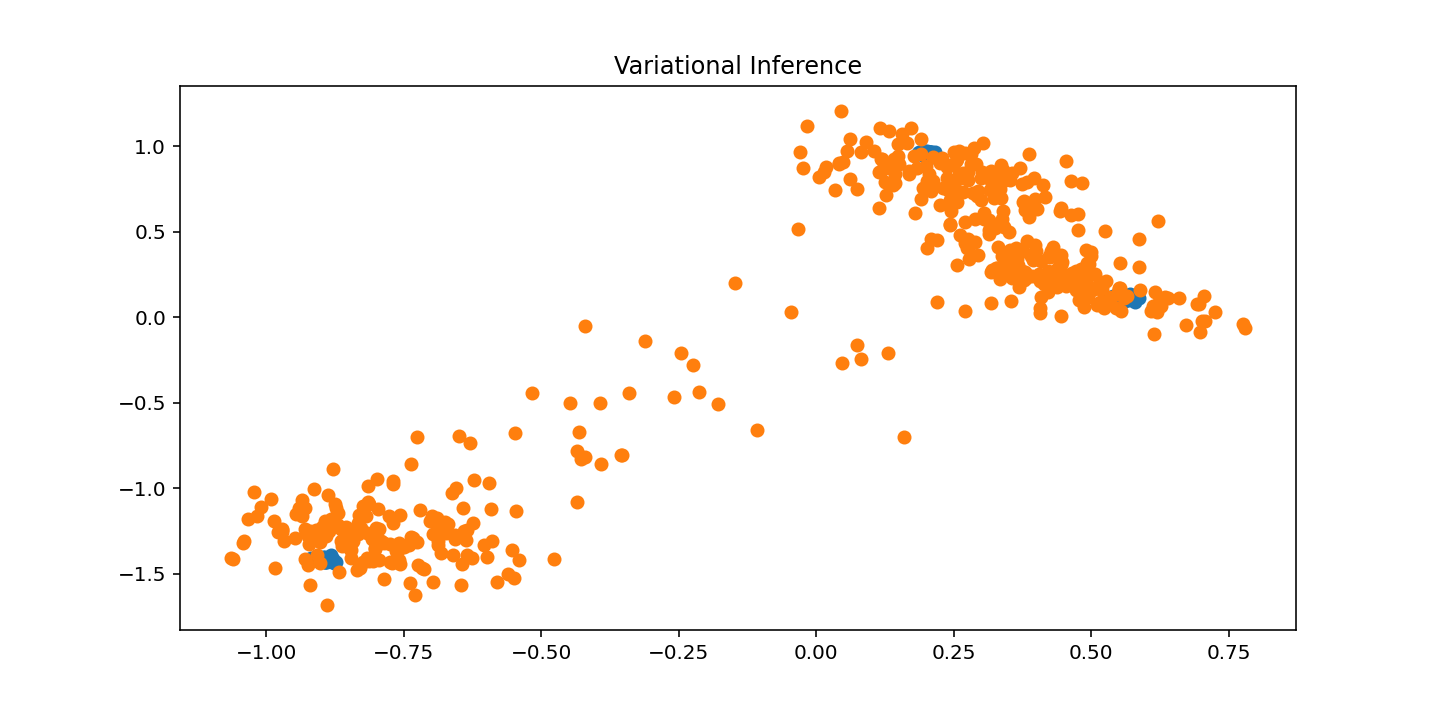

Text(0.5, 1.0, 'Variational Inference')

In [1826]:
mpl.rcParams['figure.figsize'] =(10,5)

#ploti2([r], 0, save = False, xlim = None, ylim = None)
plt.scatter(*r['posterior_locs'].reshape(-1, 2).T)
plt.scatter(*r['data'].T)
plt.title('Variational Inference')

In [1703]:
r.get_loglikelihood()

-1924129.625

In [1705]:
r.run()

  0%|          | 0/1600 [00:00<?, ?it/s]/home/ollie/anaconda3/lib/python3.8/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'obs'}
  warnings.warn(
  1%|          | 15/1600 [00:01<19:38,  1.35it/s]

ll -15625439.0


 26%|██▋       | 421/1600 [00:05<00:26, 43.78it/s] 

ll 358920.40625


 52%|█████▏    | 827/1600 [00:09<00:17, 43.84it/s] 

ll 369434.40625


 76%|███████▌  | 1219/1600 [00:12<00:08, 43.85it/s] 

ll 370391.03125


100%|██████████| 1600/1600 [00:15<00:00, 102.12it/s]


{'data': tensor([[ 5.2504e-01, -1.5097e-02],
         [-3.7256e-02, -2.3523e-01],
         [ 1.2243e+00, -1.5595e-01],
         [ 1.3616e+00, -3.3106e-01],
         [ 1.4934e+00, -6.9403e-01],
         [ 3.9317e-01, -3.6304e-01],
         [ 7.7915e-01,  1.7249e-01],
         [-1.5209e-01, -1.5496e-01],
         [ 1.4959e+00, -7.8707e-01],
         [ 9.1381e-01,  1.4793e-01],
         [ 1.6287e+00, -1.1854e+00],
         [ 1.4406e+00, -9.9750e-01],
         [ 2.6003e-01,  8.9293e-02],
         [ 1.4392e-01, -9.2911e-01],
         [ 5.7303e-01,  7.3920e-03],
         [-7.3991e-01, -4.2409e-01],
         [ 1.1855e+00,  2.9149e-01],
         [ 1.7341e+00, -1.3184e+00],
         [ 1.1049e+00, -1.0378e-01],
         [ 1.1930e+00,  2.6246e-01],
         [ 1.0003e+00,  4.4621e-02],
         [ 1.1180e+00, -3.0978e-02],
         [ 8.3088e-01, -6.5785e-02],
         [ 1.2801e+00,  1.7774e-01],
         [-1.0800e+00, -3.0476e-01],
         [ 9.3479e-01,  2.0539e-01],
         [-6.9918e-01, -1.5793

In [1706]:
r.get_loglikelihood()

46274.81640625

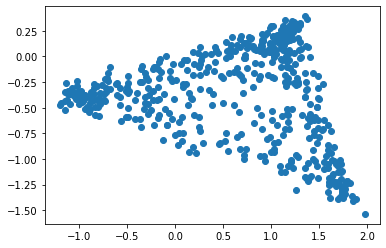

In [1609]:
%matplotlib inline
plt.scatter(*(np.array(r.data).T))

In [1603]:
pyro.set_rng_seed(4)

In [1866]:
train(n_iter)

vires = Predictive(model, guide = guide, num_samples=50)()
vires['components'] = [vires["locs"][:, i, :] for i in range(T)]
vires['data'] = data
vires['locs'] = locs

'weights', 'scale', 'locs'

100%|██████████| 800/800 [00:05<00:00, 139.69it/s]


('weights', 'scale', 'locs')

In [1867]:
# posterior = Predictive(model, guide = guide,  num_samples=50)()
# (
#     dist.MultivariateNormal(posterior['weighted_expectation'], scale_tril=posterior['L_Omega'])
#     .log_prob(data).sum()
# )

get_log_likelihood(model, guide)

35489.37109375

<IPython.core.display.Javascript object>


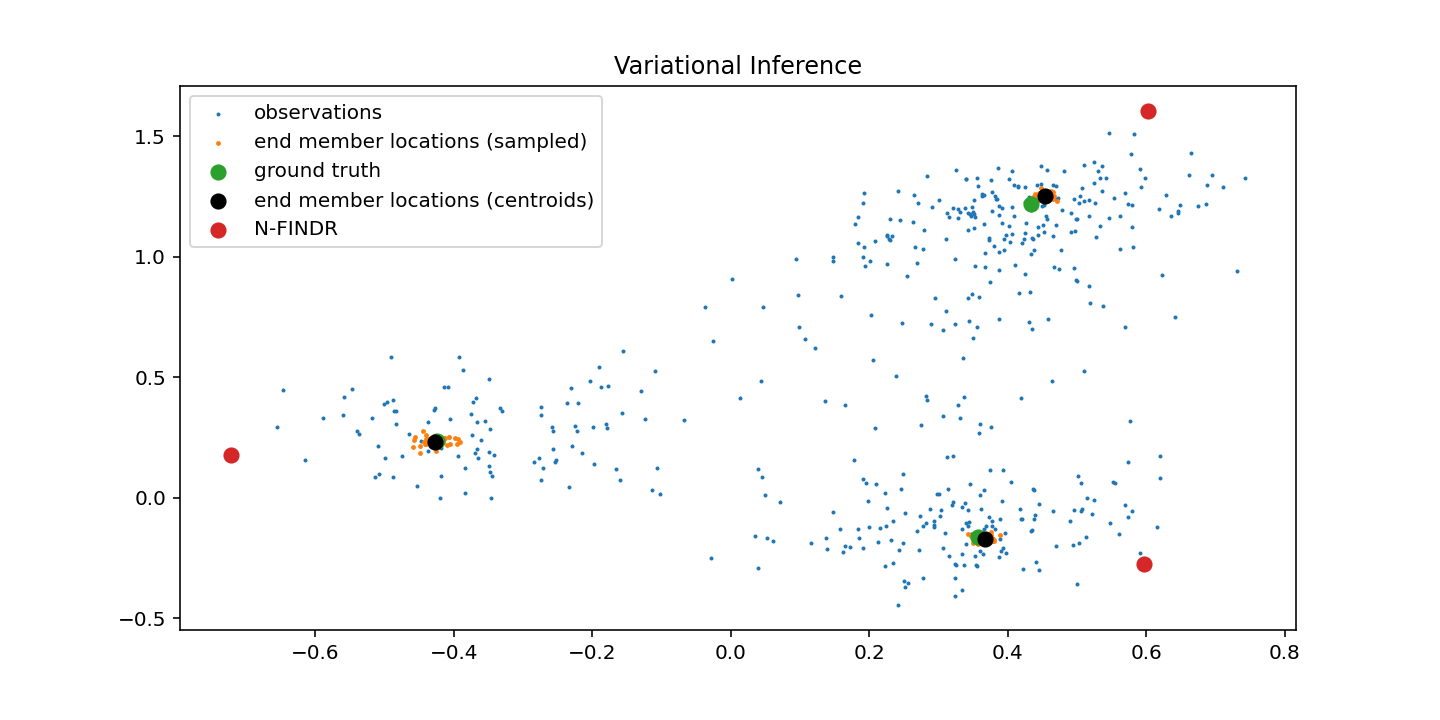

Text(0.5, 1.0, 'Variational Inference')

In [1805]:
mpl.rcParams['figure.figsize'] =(10,5)

ploti2([vires], 0, save = False, xlim = None, ylim = None)
plt.title('Variational Inference')

In [1275]:
posterior.keys()

dict_keys(['weights', 'scales', 'locs', 'L_omega', 'phase_weights', 'obs', 'weighted_expectation', 'L_Omega'])

In [1179]:
key = 'weights'

In [1211]:
pyro.set_rng_seed(3)
Predictive(model, guide = guide, num_samples=50)(torch.zeros_like(data)).keys()

dict_keys(['weights', 'scales', 'locs', 'L_omega', 'phase_weights', 'weighted_expectation', 'obs'])

In [1181]:
pyro.set_rng_seed(3)
Predictive(model, guide = guide, num_samples=50)(data)[key][0]

tensor([[0.3076, 0.3647, 0.3277]])

In [1182]:
pyro.set_rng_seed(3)
Predictive(model, guide = guide, num_samples=50)()[key][0]

tensor([[0.3076, 0.3647, 0.3277]])

In [1240]:
pyro.set_rng_seed(3)
Predictive(model, guide = guide, num_samples=50)()['locs'][0]

tensor([[-0.4097,  0.2527],
        [ 0.4700,  1.2346],
        [ 0.3570, -0.1765]])

In [1509]:
%timeit Predictive(model, guide = guide, num_samples=500)()

1.19 s ± 1.11 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [1241]:
pyro.set_rng_seed(3)
Predictive(model, guide = guide, num_samples=50)()['locs'][0]

tensor([[-0.4097,  0.2527],
        [ 0.4700,  1.2346],
        [ 0.3570, -0.1765]])

In [1232]:
%timeit Predictive(model, num_samples=50)()

67.2 ms ± 50.7 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [1238]:
pyro.set_rng_seed(3)
Predictive(model, num_samples=50)()['locs'][0]

tensor([[ 1.3029, -1.4972],
        [-0.8383, -0.7781],
        [-1.0174, -0.7045]])

In [1239]:
%timeit Predictive(guide, num_samples=50)()

65.8 ms ± 164 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [1237]:
pyro.set_rng_seed(3)
Predictive(guide, num_samples=50)()['weights'][0]

tensor([[0.3076, 0.3647, 0.3277]])

In [1217]:
pyro.set_rng_seed(3)
Predictive(model, num_samples=50)(torch.zeros_like(data))[key][0]

tensor([[0.2918, 0.2060, 0.5021]])

In [1188]:
pyro.set_rng_seed(3)
Predictive(guide, num_samples=50, return_sites=["locs", 'weights'])()[key][0]

tensor([[0.3076, 0.3647, 0.3277]])

In [1191]:
Predictive(guide, num_samples=10)()['locs'].shape

torch.Size([10, 3, 2])

In [1156]:
vires['components'][0][0]

tensor([-0.4042,  0.2592])

In [1377]:
vires['components'][0][0]

tensor([-0.3594,  0.2320])

In [1378]:
data[0]

tensor([ 0.3734, -0.0801])

Text(0.5, 1.0, 'Variational Inference')

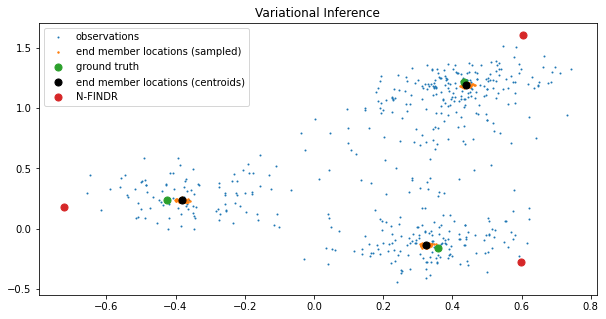

In [1376]:
mpl.rcParams['figure.figsize'] =(10,5)

ploti2([vires], 0, save = False, xlim = None, ylim = None)
plt.title('Variational Inference')

Text(0.5, 1.0, 'Variational Inference')

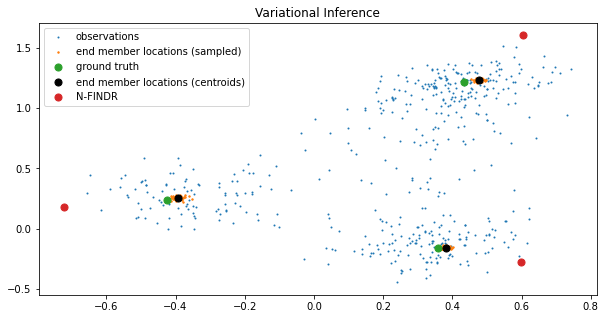

In [1128]:
mpl.rcParams['figure.figsize'] =(10,5)

ploti2([vires], 0, save = False, xlim = None, ylim = None)
plt.title('Variational Inference')

In [899]:
%matplotlib inline
vis.iplot(ploti2, res_noise)

ValueError: cannot find widget or abbreviation for argument: 'res'

> /home/ollie/anaconda3/lib/python3.8/site-packages/ipywidgets/widgets/interaction.py(288)find_abbreviations()
    286             for name, value, default in _yield_abbreviations_for_parameter(param, kwargs):
    287                 if value is empty:
--> 288                     raise ValueError('cannot find widget or abbreviation for argument: {!r}'.format(name))
    289                 new_kwargs.append((name, value, default))
    290         return new_kwargs

ipdb> c


In [904]:
res_noise[i].keys()

dict_keys(['data', 'locs', 'samples', 'rms_locs', 'diff_locs', 'permutation', 'alpha', 'beta', 'components', 'latents', 'noise_scale'])

In [1252]:
pyro.set_rng_seed(3)

vires = run_instance(alphas[i], datadict = res_noise[i], num_samples = 50, N = 500,
                      noise_scale = res_noise[i]['noise_scale'],
                inference_posterior_fn = vi_inference)

100%|██████████| 1600/1600 [00:10<00:00, 154.50it/s]


<IPython.core.display.Javascript object>


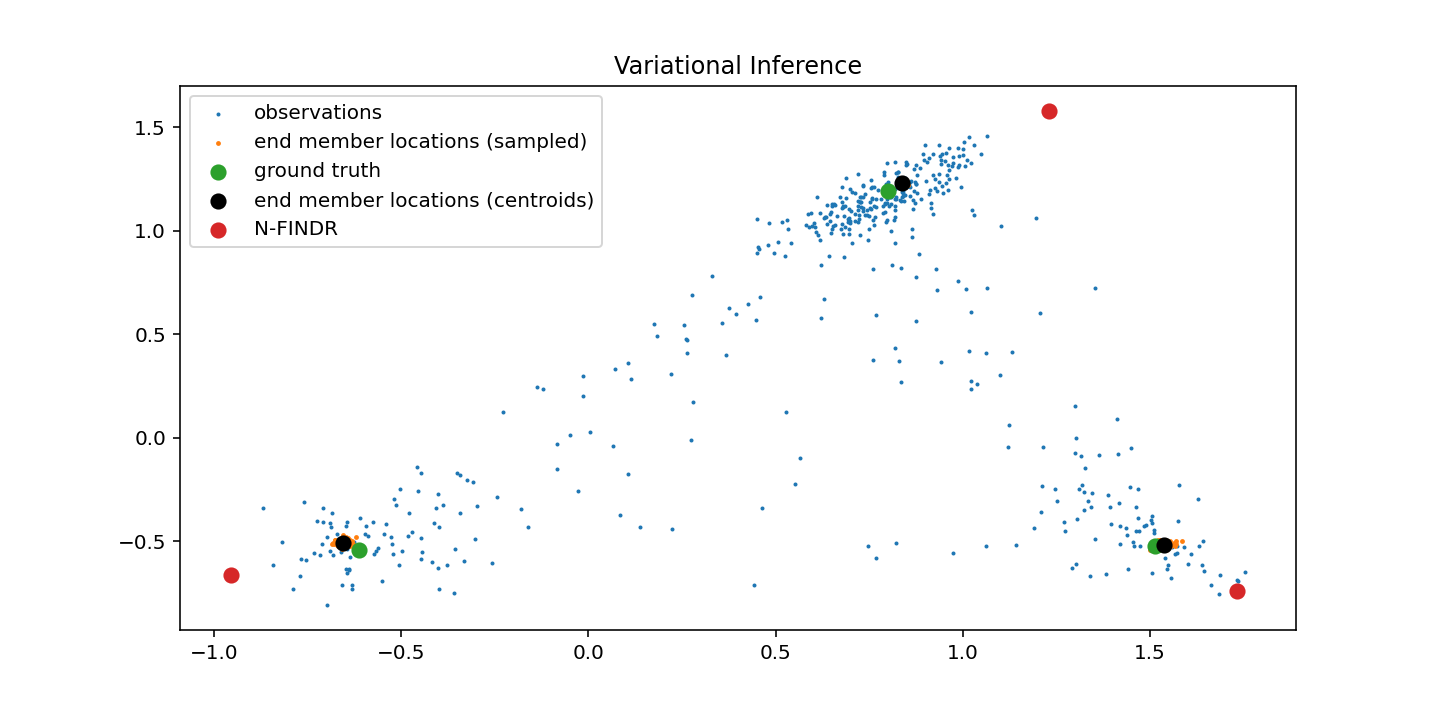

Text(0.5, 1.0, 'Variational Inference')

In [1778]:
mpl.rcParams['figure.figsize'] =(10,5)

ploti2([vires], 0, save = False, xlim = None, ylim = None)
plt.title('Variational Inference')

Text(0.5, 1.0, 'Variational Inference')

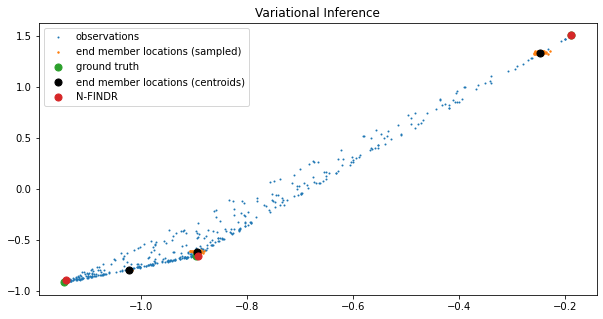

In [923]:
mpl.rcParams['figure.figsize'] =(10,5)

ploti2([vires], 0, save = False, xlim = None, ylim = None)
plt.title('Variational Inference')

Text(0.5, 1.0, 'Variational Inference')

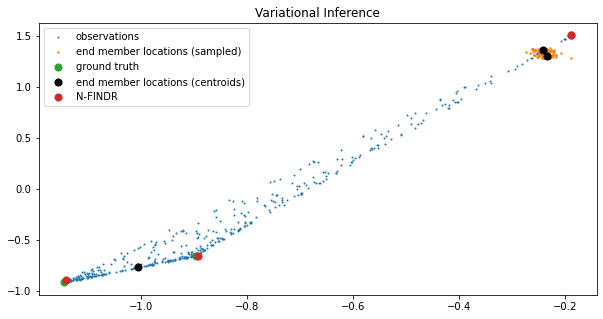

In [918]:
mpl.rcParams['figure.figsize'] =(10,5)

ploti2(res_noise, 2, save = False, xlim = None, ylim = None)
plt.title('Variational Inference')

In [ ]:
mpl.rcParams['figure.figsize'] =(10,5)

ploti2(res_noise, 0, save = False, xlim = None, ylim = None)
plt.title('Variational Inference')

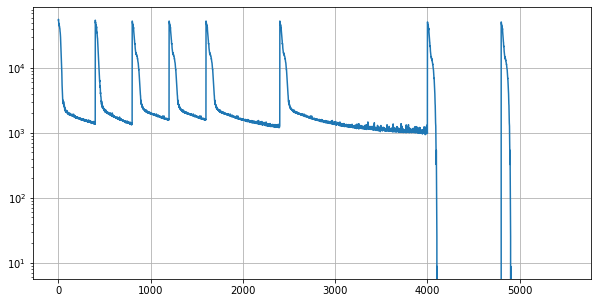

In [888]:
plt.plot(losses)
plt.semilogy()
plt.grid()

In [1258]:
pyro.set_rng_seed(1)

vires = run_instance(1, num_samples = 50, N = 500, noise_scale=.01, inference_posterior_fn=vi_inference)

100%|██████████| 1600/1600 [00:10<00:00, 154.68it/s]


Text(0.5, 1.0, 'Variational Inference')

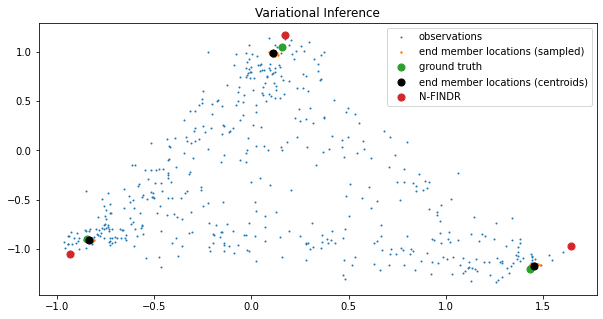

In [1260]:
mpl.rcParams['figure.figsize'] =(10,5)

ploti2([vires], 0, save = False, xlim = None, ylim = None)
plt.title('Variational Inference')

In [482]:
for k, v in vires.items():
    if type(v) == torch.Tensor:
        print(k, v.shape)

data torch.Size([500, 2])
locs torch.Size([3, 2])
latents torch.Size([500, 2])


In [947]:
pyro.set_rng_seed(1)

mcmcres = run_instance(1, num_samples = 50, N = 500, noise_scale=.01, inference_posterior_fn=mcmc_posterior)

Sample: 100%|██████████| 100/100 [04:38,  2.78s/it, step size=1.19e-03, acc. prob=0.939]


In [481]:
for k, v in mcmcres.items():
    if type(v) == torch.Tensor:
        print(k, v.shape)

data torch.Size([500, 2])
locs torch.Size([3, 2])
latents torch.Size([500, 2])


Text(0.5, 1.0, 'MCMC')

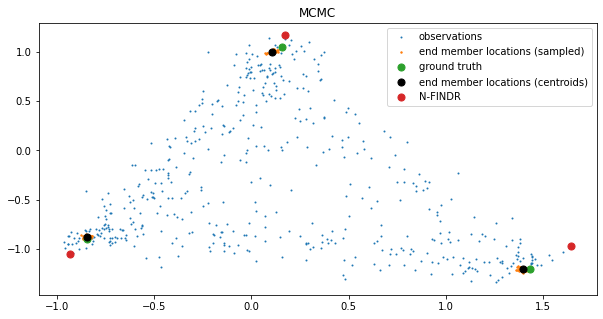

In [508]:
mpl.rcParams['figure.figsize'] =(10,5)

ploti2([mcmcres], 0, save = False, xlim = None, ylim = None)
plt.title('MCMC')

In [786]:
def init(alpha = alpha, noise_scale = .01, alpha_components = 5):
    # TODO refactor
    def _model(*args, **kwargs):
        return model(data = None, scale = noise_scale, alpha = alpha, alpha_components =\
                    alpha_components, N = 1)

    return Predictive(_model, {}, num_samples=1)()
    
# guide = AutoNormal(model)

#     # svi = SVI(model, guide,
#     #           optim=Adam({'lr': 0.05}),
#     #           loss=Trace_ELBO())

#     svi = SVI(model, guide,
#               optim=Adam({'lr': 0.05}),
#               loss=TraceMeanField_ELBO())


#     return Predictive(guide, num_samples=1)()

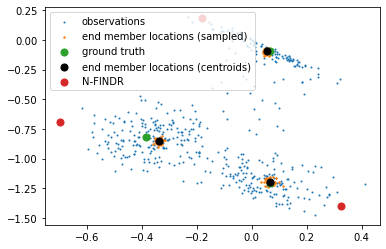

In [700]:
ploti2([vires], 0, save = False, xlim = None, ylim = None)

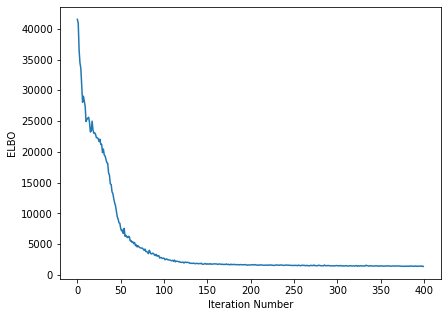

In [392]:
elbo_plot = plt.figure(figsize=(15, 5))

elbo_ax = elbo_plot.add_subplot(1, 2, 1)
elbo_ax.set_ylabel("ELBO")
elbo_ax.set_xlabel("Iteration Number")
elbo_ax.plot(np.arange(n_iter), losses)

In [956]:
rn0 = res_noise

In [189]:
def plt_heatmap_alpha_noise(res3, zname = 'diff_locs', yscale = 300, label = None, vmax = 1):    
    noise = np.array([elt['noise_scale'] for elt in res3])

    x = alphas
    y = noise * yscale
    z = np.array([np.linalg.norm(elt[zname]) for elt in res3])

    X = np.logspace(np.log10(min(x)), np.log10(max(x)))
    Y = np.linspace(min(y), max(y))
    X, Y = np.meshgrid(X, Y)  # 2D grid for interpolation
    #interp = CloughTocher2DInterpolator(list(zip(x, y)), z)
    interp = NearestNDInterpolator(list(zip(x, y)), z)
    Z = interp(X, Y)
    plt.pcolormesh(X, Y, Z, shading='auto', cmap = 'jet', vmin = 0, vmax = vmax)
    plt.plot(x, y, "ok")#, label="input point")
    plt.legend()
    plt.colorbar()
    #plt.axis("equal")
    plt.xlabel('alpha')
    plt.ylabel('noise scale')
    plt.title(label)
    plt.semilogx()
    plt.show()
    
def initialize(seed, *args, **kwargs):
    global global_guide, svi, prior_sample
        
    def f():
        pyro.clear_param_store()
        if seed is not None:
            pyro.set_rng_seed(seed + 1000) # add offset to avoid collision with other places where we're setting the seed
        return Run(*args, **kwargs)
    run = f()
    vi_init = run.inference_output
    ll = run.get_loglikelihood(num_samples = 50)
    print(ll)
    return ll, run

def get_inference_seed(data_seed, *args, **kwargs):
    (loss, run), seed = max((initialize(data_seed, *args, **kwargs,
          inference_seed = s), s) for s in range(10))
    return loss, run, seed

In [ ]:
    res_noise.append(Run(a, num_samples = 50, N = 500,
                            noise_scale= .03 * np.random.uniform() + 1e-3,
                            inference_posterior_fn=vi_inference, inference_seed = None).run()
                    )

In [99]:
run.get_loglikelihood()

52503.1640625

In [226]:
start_seed = 1
pyro.set_rng_seed(start_seed)

K = T = 3
ndim = T - 1

alphas = np.logspace(-1, 1, 10)

res_noise = []
for data_seed, a in enumerate(alphas):
#     res_noise.append(Run(a, num_samples = 50, N = 500,
#                             noise_scale= .03 * np.random.uniform() + 1e-3,
#                             inference_posterior_fn=vi_inference, inference_seed = None).run()
#                     )
    noise_scale = .03 * np.random.uniform() + 1e-3
    print(noise_scale)
    loss, run, seed = get_inference_seed(data_seed, a, num_samples = 100, N = 500,
                                noise_scale= noise_scale,
                                infer_noise_scale = noise_scale,
                                inference_posterior_fn=vi_inference)
    res_noise.append(run.run())
    print(loss, seed)

0it [00:00, ?it/s]

0.01351066014107722



0it [00:00, ?it/s]

-4231159.5



0it [00:00, ?it/s]

-4228465.0



0it [00:00, ?it/s]

-4247347.0



0it [00:00, ?it/s]

-4282072.0



0it [00:00, ?it/s]

-4255685.0



0it [00:00, ?it/s]

-4253110.0



0it [00:00, ?it/s]

-4293329.0



0it [00:00, ?it/s]

-4246017.5



0it [00:00, ?it/s]

-4286089.5



  0%|          | 0/1600 [00:00<?, ?it/s]/home/ollie/anaconda3/lib/python3.8/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'obs'}
  warnings.warn(
  0%|          | 1/1600 [00:00<03:49,  6.97it/s]

-4229008.5
ll -4280711.0


  7%|▋         | 119/1600 [00:01<00:25, 58.51it/s]

ll 23242.693359375


 14%|█▍        | 223/1600 [00:01<00:13, 100.93it/s]

ll 31490.765625


 20%|██        | 327/1600 [00:02<00:11, 107.55it/s]

ll 33149.2109375


 26%|██▌       | 416/1600 [00:03<00:11, 107.15it/s]

ll 33400.0625


 32%|███▎      | 520/1600 [00:04<00:09, 108.27it/s]

ll 34139.28125


 39%|███▉      | 624/1600 [00:05<00:08, 108.68it/s]

ll 35051.8125


 46%|████▌     | 728/1600 [00:06<00:08, 108.67it/s]

ll 35328.26171875


 51%|█████     | 817/1600 [00:06<00:07, 107.69it/s]

ll 36428.74609375


 58%|█████▊    | 921/1600 [00:07<00:06, 108.02it/s]

ll 37360.4453125


 64%|██████▍   | 1025/1600 [00:08<00:05, 107.94it/s]

ll 36499.875


 70%|██████▉   | 1114/1600 [00:09<00:04, 98.33it/s] 

ll 38746.44140625


 76%|███████▌  | 1218/1600 [00:10<00:03, 107.06it/s]

ll 39056.40234375


 83%|████████▎ | 1321/1600 [00:11<00:02, 107.64it/s]

ll 39713.171875


 89%|████████▉ | 1425/1600 [00:12<00:01, 108.08it/s]

ll 38887.37109375


 95%|█████████▍| 1514/1600 [00:12<00:00, 98.24it/s] 

ll 39944.4453125


100%|██████████| 1600/1600 [00:13<00:00, 118.96it/s]
0it [00:00, ?it/s]

-4228465.0 1
0.026163735811174274



0it [00:00, ?it/s]

-688929.375



0it [00:00, ?it/s]

-695646.6875



0it [00:00, ?it/s]

-696337.375



0it [00:00, ?it/s]

-703873.625



0it [00:00, ?it/s]

-697758.25



0it [00:00, ?it/s]

-694473.5625



0it [00:00, ?it/s]

-686468.875



0it [00:00, ?it/s]

-696327.75



0it [00:00, ?it/s]

-698819.1875



  0%|          | 1/1600 [00:00<03:49,  6.97it/s]

-696262.375
ll -697620.4375


  7%|▋         | 119/1600 [00:01<00:25, 58.43it/s]

ll -31040.146484375


 14%|█▍        | 223/1600 [00:01<00:13, 100.70it/s]

ll -11125.9912109375


 20%|██        | 327/1600 [00:02<00:11, 106.91it/s]

ll -2476.821533203125


 25%|██▌       | 401/1600 [00:03<00:12, 96.38it/s] 

ll 2098.30126953125


 32%|███▏      | 517/1600 [00:04<00:10, 102.54it/s]

ll 7129.05810546875


 39%|███▉      | 621/1600 [00:05<00:09, 107.30it/s]

ll 14348.322265625


 45%|████▌     | 725/1600 [00:06<00:08, 107.66it/s]

ll 15754.15625


 51%|█████     | 814/1600 [00:07<00:08, 97.78it/s] 

ll 15467.5302734375


 57%|█████▋    | 918/1600 [00:08<00:06, 106.84it/s]

ll 15948.5634765625


 64%|██████▍   | 1022/1600 [00:08<00:05, 107.64it/s]

ll 16839.466796875


 70%|███████   | 1125/1600 [00:09<00:04, 107.52it/s]

ll 17201.560546875


 77%|███████▋  | 1228/1600 [00:10<00:03, 107.25it/s]

ll 18345.681640625


 82%|████████▏ | 1317/1600 [00:11<00:02, 106.30it/s]

ll 18628.89453125


 88%|████████▊ | 1416/1600 [00:12<00:01, 106.38it/s]

ll 18870.455078125


 95%|█████████▍| 1518/1600 [00:13<00:00, 106.17it/s]

ll 18935.611328125


100%|██████████| 1600/1600 [00:13<00:00, 116.20it/s]
0it [00:00, ?it/s]

-686468.875 6
0.02971440957256274



0it [00:00, ?it/s]

-1108220.125



0it [00:00, ?it/s]

-1101799.5



0it [00:00, ?it/s]

-1079673.75



0it [00:00, ?it/s]

-1099788.25



0it [00:00, ?it/s]

-1088663.0



0it [00:00, ?it/s]

-1091304.625



0it [00:00, ?it/s]

-1110377.5



0it [00:00, ?it/s]

-1104178.875



0it [00:00, ?it/s]

-1111124.5



  0%|          | 1/1600 [00:00<03:48,  6.98it/s]

-1096968.5
ll -1090894.0


  7%|▋         | 119/1600 [00:01<00:25, 58.65it/s]

ll -2108.568115234375


 14%|█▍        | 223/1600 [00:01<00:13, 101.45it/s]

ll 4767.466796875


 20%|██        | 327/1600 [00:02<00:11, 107.76it/s]

ll 5946.35009765625


 26%|██▌       | 416/1600 [00:03<00:11, 106.99it/s]

ll 6625.359375


 32%|███▎      | 520/1600 [00:04<00:10, 107.71it/s]

ll 8419.236328125


 39%|███▉      | 623/1600 [00:05<00:09, 107.85it/s]

ll 8029.21240234375


 45%|████▌     | 727/1600 [00:06<00:08, 108.27it/s]

ll 8118.5185546875


 51%|█████     | 816/1600 [00:06<00:07, 106.95it/s]

ll 9055.6640625


 57%|█████▊    | 920/1600 [00:07<00:06, 108.33it/s]

ll 9136.44140625


 64%|██████▍   | 1024/1600 [00:08<00:05, 108.44it/s]

ll 9164.5048828125


 70%|███████   | 1128/1600 [00:09<00:04, 108.42it/s]

ll 9843.943359375


 76%|███████▌  | 1217/1600 [00:10<00:03, 106.79it/s]

ll 10529.02734375


 82%|████████▏ | 1319/1600 [00:11<00:02, 107.46it/s]

ll 10702.111328125


 89%|████████▉ | 1421/1600 [00:12<00:01, 107.71it/s]

ll 10411.71875


 95%|█████████▌| 1525/1600 [00:12<00:00, 107.69it/s]

ll 11298.6845703125


100%|██████████| 1600/1600 [00:13<00:00, 118.80it/s]
0it [00:00, ?it/s]

-1079673.75 2
0.016575836113562132



0it [00:00, ?it/s]

-1504586.25



0it [00:00, ?it/s]

-1551545.25



0it [00:00, ?it/s]

-1511742.875



0it [00:00, ?it/s]

-1511325.5



0it [00:00, ?it/s]

-1492593.25



0it [00:00, ?it/s]

-1516195.5



0it [00:00, ?it/s]

-1532151.375



0it [00:00, ?it/s]

-1511165.5



0it [00:00, ?it/s]

-1536183.5



  0%|          | 1/1600 [00:00<03:48,  6.99it/s]

-1496505.875
ll -1500398.25


  7%|▋         | 118/1600 [00:01<00:25, 58.41it/s]

ll -26986.6171875


 14%|█▎        | 217/1600 [00:02<00:16, 84.54it/s]

ll 6859.49462890625


 20%|█▉        | 319/1600 [00:03<00:12, 105.11it/s]

ll 16238.3115234375


 26%|██▋       | 422/1600 [00:03<00:10, 107.31it/s]

ll 18347.521484375


 33%|███▎      | 525/1600 [00:04<00:10, 107.41it/s]

ll 18775.15234375


 39%|███▉      | 626/1600 [00:05<00:09, 107.39it/s]

ll 19122.91796875


 45%|████▍     | 714/1600 [00:06<00:09, 97.67it/s] 

ll 18859.583984375


 51%|█████     | 818/1600 [00:07<00:07, 106.64it/s]

ll 18137.970703125


 57%|█████▊    | 920/1600 [00:08<00:06, 107.31it/s]

ll 17858.029296875


 64%|██████▍   | 1021/1600 [00:08<00:05, 107.30it/s]

ll 17442.75


 70%|███████   | 1123/1600 [00:09<00:04, 107.42it/s]

ll 17652.296875


 77%|███████▋  | 1226/1600 [00:10<00:03, 107.55it/s]

ll 17621.041015625


 83%|████████▎ | 1328/1600 [00:11<00:02, 107.46it/s]

ll 17089.4375


 88%|████████▊ | 1416/1600 [00:12<00:01, 108.07it/s]

ll 17469.453125


 95%|█████████▍| 1518/1600 [00:13<00:00, 107.40it/s]

ll 17531.0234375


100%|██████████| 1600/1600 [00:13<00:00, 116.27it/s]
0it [00:00, ?it/s]

-1492593.25 4
0.023613122316916046



0it [00:00, ?it/s]

-320216.25



0it [00:00, ?it/s]

-334387.0



0it [00:00, ?it/s]

-328078.46875



0it [00:00, ?it/s]

-330916.6875



0it [00:00, ?it/s]

-333535.875



0it [00:00, ?it/s]

-332889.5625



0it [00:00, ?it/s]

-323302.28125



0it [00:00, ?it/s]

-326460.15625



0it [00:00, ?it/s]

-330521.5625



  0%|          | 1/1600 [00:00<03:48,  6.98it/s]

-327045.125
ll -325530.65625


  7%|▋         | 119/1600 [00:01<00:25, 58.74it/s]

ll 9690.587890625


 14%|█▍        | 223/1600 [00:01<00:13, 101.46it/s]

ll 12097.896484375


 20%|██        | 327/1600 [00:02<00:11, 108.05it/s]

ll 12391.4306640625


 26%|██▌       | 416/1600 [00:03<00:10, 107.67it/s]

ll 12120.529296875


 32%|███▎      | 520/1600 [00:04<00:09, 108.56it/s]

ll 12343.134765625


 39%|███▉      | 624/1600 [00:05<00:08, 108.55it/s]

ll 11487.6376953125


 46%|████▌     | 728/1600 [00:06<00:08, 108.67it/s]

ll 11966.8173828125


 51%|█████     | 817/1600 [00:06<00:07, 107.78it/s]

ll 11403.7529296875


 58%|█████▊    | 921/1600 [00:07<00:06, 108.52it/s]

ll 10667.484375


 64%|██████▍   | 1025/1600 [00:08<00:05, 108.60it/s]

ll 11472.478515625


 70%|██████▉   | 1114/1600 [00:09<00:04, 98.56it/s] 

ll 10362.19140625


 76%|███████▌  | 1218/1600 [00:10<00:03, 107.69it/s]

ll 10696.494140625


 83%|████████▎ | 1322/1600 [00:11<00:02, 108.57it/s]

ll 10307.7265625


 89%|████████▉ | 1426/1600 [00:12<00:01, 108.59it/s]

ll 10583.1328125


 95%|█████████▍| 1516/1600 [00:12<00:00, 109.26it/s]

ll 9639.966796875


100%|██████████| 1600/1600 [00:13<00:00, 119.53it/s]
0it [00:00, ?it/s]

-320216.25 0
0.015581419690646511



0it [00:00, ?it/s]

-3069586.0



0it [00:00, ?it/s]

-2994116.5



0it [00:00, ?it/s]

-3076575.5



0it [00:00, ?it/s]

-3031881.5



0it [00:00, ?it/s]

-3021522.75



0it [00:00, ?it/s]

-3084469.5



0it [00:00, ?it/s]

-3073500.5



0it [00:00, ?it/s]

-3045514.5



0it [00:00, ?it/s]

-3035306.75



  0%|          | 1/1600 [00:00<03:49,  6.96it/s]

-3077020.25
ll -3058303.5


  7%|▋         | 119/1600 [00:01<00:25, 58.42it/s]

ll -58545.20703125


 14%|█▍        | 223/1600 [00:01<00:13, 101.04it/s]

ll -26878.65625


 20%|██        | 327/1600 [00:02<00:11, 107.65it/s]

ll -17168.72265625


 26%|██▌       | 416/1600 [00:03<00:11, 107.16it/s]

ll -11622.9794921875


 32%|███▎      | 520/1600 [00:04<00:10, 107.73it/s]

ll -9040.748046875


 39%|███▉      | 624/1600 [00:05<00:09, 107.68it/s]

ll -6389.7333984375


 46%|████▌     | 728/1600 [00:06<00:08, 107.87it/s]

ll -3658.9248046875


 51%|█████     | 817/1600 [00:06<00:07, 107.02it/s]

ll -948.8025512695312


 58%|█████▊    | 921/1600 [00:07<00:06, 107.98it/s]

ll 6675.64599609375


 64%|██████▍   | 1025/1600 [00:08<00:05, 107.86it/s]

ll 14749.900390625


 70%|██████▉   | 1114/1600 [00:09<00:04, 98.07it/s] 

ll 18991.701171875


 76%|███████▌  | 1218/1600 [00:10<00:03, 107.14it/s]

ll 22103.83984375


 83%|████████▎ | 1322/1600 [00:11<00:02, 108.09it/s]

ll 22489.134765625


 89%|████████▉ | 1426/1600 [00:12<00:01, 108.27it/s]

ll 24335.6796875


 95%|█████████▍| 1516/1600 [00:12<00:00, 109.13it/s]

ll 24512.193359375


100%|██████████| 1600/1600 [00:13<00:00, 118.81it/s]
0it [00:00, ?it/s]

-2994116.5 1
0.026163735811174274



0it [00:00, ?it/s]

-607642.625



0it [00:00, ?it/s]

-598543.375



0it [00:00, ?it/s]

-610826.3125



0it [00:00, ?it/s]

-604973.0625



0it [00:00, ?it/s]

-601576.3125



0it [00:00, ?it/s]

-614442.375



0it [00:00, ?it/s]

-602690.125



0it [00:00, ?it/s]

-612742.5625



0it [00:00, ?it/s]

-604740.125



  0%|          | 1/1600 [00:00<03:49,  6.96it/s]

-591895.75
ll -599907.25


  7%|▋         | 119/1600 [00:01<00:25, 58.52it/s]

ll -46596.125


 14%|█▍        | 223/1600 [00:01<00:13, 101.17it/s]

ll -3377.600830078125


 20%|██        | 327/1600 [00:02<00:11, 107.96it/s]

ll 6881.29833984375


 26%|██▌       | 416/1600 [00:03<00:10, 107.65it/s]

ll 9609.5244140625


 32%|███▎      | 520/1600 [00:04<00:09, 108.24it/s]

ll 10520.4775390625


 39%|███▉      | 624/1600 [00:05<00:08, 108.59it/s]

ll 11012.6767578125


 46%|████▌     | 728/1600 [00:06<00:08, 108.62it/s]

ll 11359.029296875


 51%|█████     | 817/1600 [00:06<00:07, 107.69it/s]

ll 11946.1591796875


 58%|█████▊    | 921/1600 [00:07<00:06, 108.27it/s]

ll 12376.412109375


 64%|██████▍   | 1025/1600 [00:08<00:05, 108.53it/s]

ll 12825.7275390625


 70%|██████▉   | 1114/1600 [00:09<00:04, 98.56it/s] 

ll 13463.216796875


 76%|███████▌  | 1218/1600 [00:10<00:03, 107.67it/s]

ll 14065.89453125


 83%|████████▎ | 1322/1600 [00:11<00:02, 107.95it/s]

ll 13954.69140625


 89%|████████▉ | 1426/1600 [00:12<00:01, 108.28it/s]

ll 13799.5419921875


 95%|█████████▌| 1527/1600 [00:13<00:00, 95.53it/s] 

ll 13955.859375


100%|██████████| 1600/1600 [00:13<00:00, 117.55it/s]
0it [00:00, ?it/s]

-591895.75 9
0.0241422160895347



0it [00:00, ?it/s]

-482669.125



0it [00:00, ?it/s]

-485335.125



0it [00:00, ?it/s]

-485515.09375



0it [00:00, ?it/s]

-484767.65625



0it [00:00, ?it/s]

-477904.21875



0it [00:00, ?it/s]

-479734.1875



0it [00:00, ?it/s]

-474211.875



0it [00:00, ?it/s]

-483791.59375



0it [00:00, ?it/s]

-484043.25



  0%|          | 1/1600 [00:00<03:48,  6.99it/s]

-483679.875
ll -480615.875


  7%|▋         | 119/1600 [00:01<00:25, 58.61it/s]

ll -3814.783203125


 14%|█▍        | 223/1600 [00:01<00:13, 101.48it/s]

ll 6649.587890625


 20%|██        | 327/1600 [00:02<00:11, 107.59it/s]

ll 11275.830078125


 26%|██▌       | 416/1600 [00:03<00:11, 107.52it/s]

ll 12902.2431640625


 32%|███▎      | 520/1600 [00:04<00:09, 108.69it/s]

ll 12285.5703125


 39%|███▉      | 624/1600 [00:05<00:08, 108.72it/s]

ll 12374.4033203125


 46%|████▌     | 728/1600 [00:06<00:08, 108.34it/s]

ll 11925.6337890625


 51%|█████     | 817/1600 [00:06<00:07, 107.12it/s]

ll 11396.412109375


 58%|█████▊    | 921/1600 [00:07<00:06, 108.52it/s]

ll 11585.6240234375


 64%|██████▍   | 1025/1600 [00:08<00:05, 108.64it/s]

ll 10933.2158203125


 70%|██████▉   | 1114/1600 [00:09<00:04, 98.59it/s] 

ll 10994.244140625


 76%|███████▌  | 1218/1600 [00:10<00:03, 107.68it/s]

ll 11131.7705078125


 83%|████████▎ | 1322/1600 [00:11<00:02, 108.57it/s]

ll 10529.1640625


 89%|████████▉ | 1426/1600 [00:12<00:01, 108.27it/s]

ll 10469.0107421875


 95%|█████████▍| 1516/1600 [00:12<00:00, 109.40it/s]

ll 10682.87890625


100%|██████████| 1600/1600 [00:13<00:00, 119.46it/s]
0it [00:00, ?it/s]

-474211.875 6
0.02971440957256274



0it [00:00, ?it/s]

-325046.96875



0it [00:00, ?it/s]

-320190.78125



0it [00:00, ?it/s]

-326826.46875



0it [00:00, ?it/s]

-325782.34375



0it [00:00, ?it/s]

-331427.125



0it [00:00, ?it/s]

-329442.375



0it [00:00, ?it/s]

-329445.625



0it [00:00, ?it/s]

-329482.03125



0it [00:00, ?it/s]

-315844.25



  0%|          | 1/1600 [00:00<03:49,  6.97it/s]

-320097.875
ll -326830.46875


  7%|▋         | 119/1600 [00:01<00:25, 58.45it/s]

ll 5891.8388671875


 14%|█▍        | 223/1600 [00:01<00:13, 100.85it/s]

ll 9399.3369140625


 20%|██        | 327/1600 [00:02<00:11, 107.29it/s]

ll 10699.17578125


 26%|██▌       | 416/1600 [00:03<00:11, 106.90it/s]

ll 10744.3193359375


 32%|███▎      | 520/1600 [00:04<00:10, 107.73it/s]

ll 11689.7900390625


 39%|███▉      | 621/1600 [00:05<00:09, 98.99it/s] 

ll 11705.583984375


 45%|████▌     | 721/1600 [00:06<00:08, 106.40it/s]

ll 11743.3916015625


 51%|█████▏    | 823/1600 [00:07<00:07, 106.90it/s]

ll 11564.83984375


 58%|█████▊    | 927/1600 [00:07<00:06, 107.60it/s]

ll 11627.5849609375


 64%|██████▎   | 1016/1600 [00:08<00:05, 106.94it/s]

ll 11550.2802734375


 70%|███████   | 1120/1600 [00:09<00:04, 107.68it/s]

ll 11556.8046875


 76%|███████▋  | 1224/1600 [00:10<00:03, 108.03it/s]

ll 11932.3955078125


 83%|████████▎ | 1326/1600 [00:11<00:02, 101.86it/s]

ll 11724.294921875


 88%|████████▊ | 1416/1600 [00:12<00:01, 107.99it/s]

ll 11657.4541015625


 95%|█████████▌| 1520/1600 [00:13<00:00, 107.99it/s]

ll 11659.107421875


100%|██████████| 1600/1600 [00:13<00:00, 116.23it/s]
0it [00:00, ?it/s]

-315844.25 8
0.00588010960093476



0it [00:00, ?it/s]

-1987238.125



0it [00:00, ?it/s]

-1974036.375



0it [00:00, ?it/s]

-2000369.75



0it [00:00, ?it/s]

-1992475.75



0it [00:00, ?it/s]

-1987994.875



0it [00:00, ?it/s]

-2001702.25



0it [00:00, ?it/s]

-2028807.0



0it [00:00, ?it/s]

-1996766.25



0it [00:00, ?it/s]

-2005143.125



  0%|          | 1/1600 [00:00<03:49,  6.98it/s]

-2024646.875
ll -1970515.25


  7%|▋         | 119/1600 [00:01<00:25, 58.55it/s]

ll -30550.54296875


 14%|█▍        | 223/1600 [00:01<00:13, 100.84it/s]

ll 36219.8671875


 20%|██        | 327/1600 [00:02<00:11, 107.38it/s]

ll 42392.5703125


 26%|██▌       | 416/1600 [00:03<00:11, 107.02it/s]

ll 43655.91796875


 32%|███▎      | 520/1600 [00:04<00:10, 108.00it/s]

ll 44557.5234375


 39%|███▉      | 624/1600 [00:05<00:09, 107.88it/s]

ll 45256.65234375


 46%|████▌     | 728/1600 [00:06<00:08, 107.82it/s]

ll 45495.44921875


 51%|█████     | 817/1600 [00:06<00:07, 107.02it/s]

ll 45297.55078125


 58%|█████▊    | 921/1600 [00:07<00:06, 107.93it/s]

ll 45352.9296875


 64%|██████▍   | 1025/1600 [00:08<00:05, 107.81it/s]

ll 45494.7421875


 70%|██████▉   | 1114/1600 [00:09<00:04, 97.75it/s] 

ll 45055.06640625


 76%|███████▌  | 1218/1600 [00:10<00:03, 107.07it/s]

ll 45189.80859375


 83%|████████▎ | 1322/1600 [00:11<00:02, 108.01it/s]

ll 46510.61328125


 89%|████████▉ | 1426/1600 [00:12<00:01, 108.29it/s]

ll 45447.5859375


 95%|█████████▍| 1516/1600 [00:12<00:00, 108.62it/s]

ll 46646.7265625


100%|██████████| 1600/1600 [00:13<00:00, 118.71it/s]


-1974036.375 1


<IPython.core.display.Javascript object>


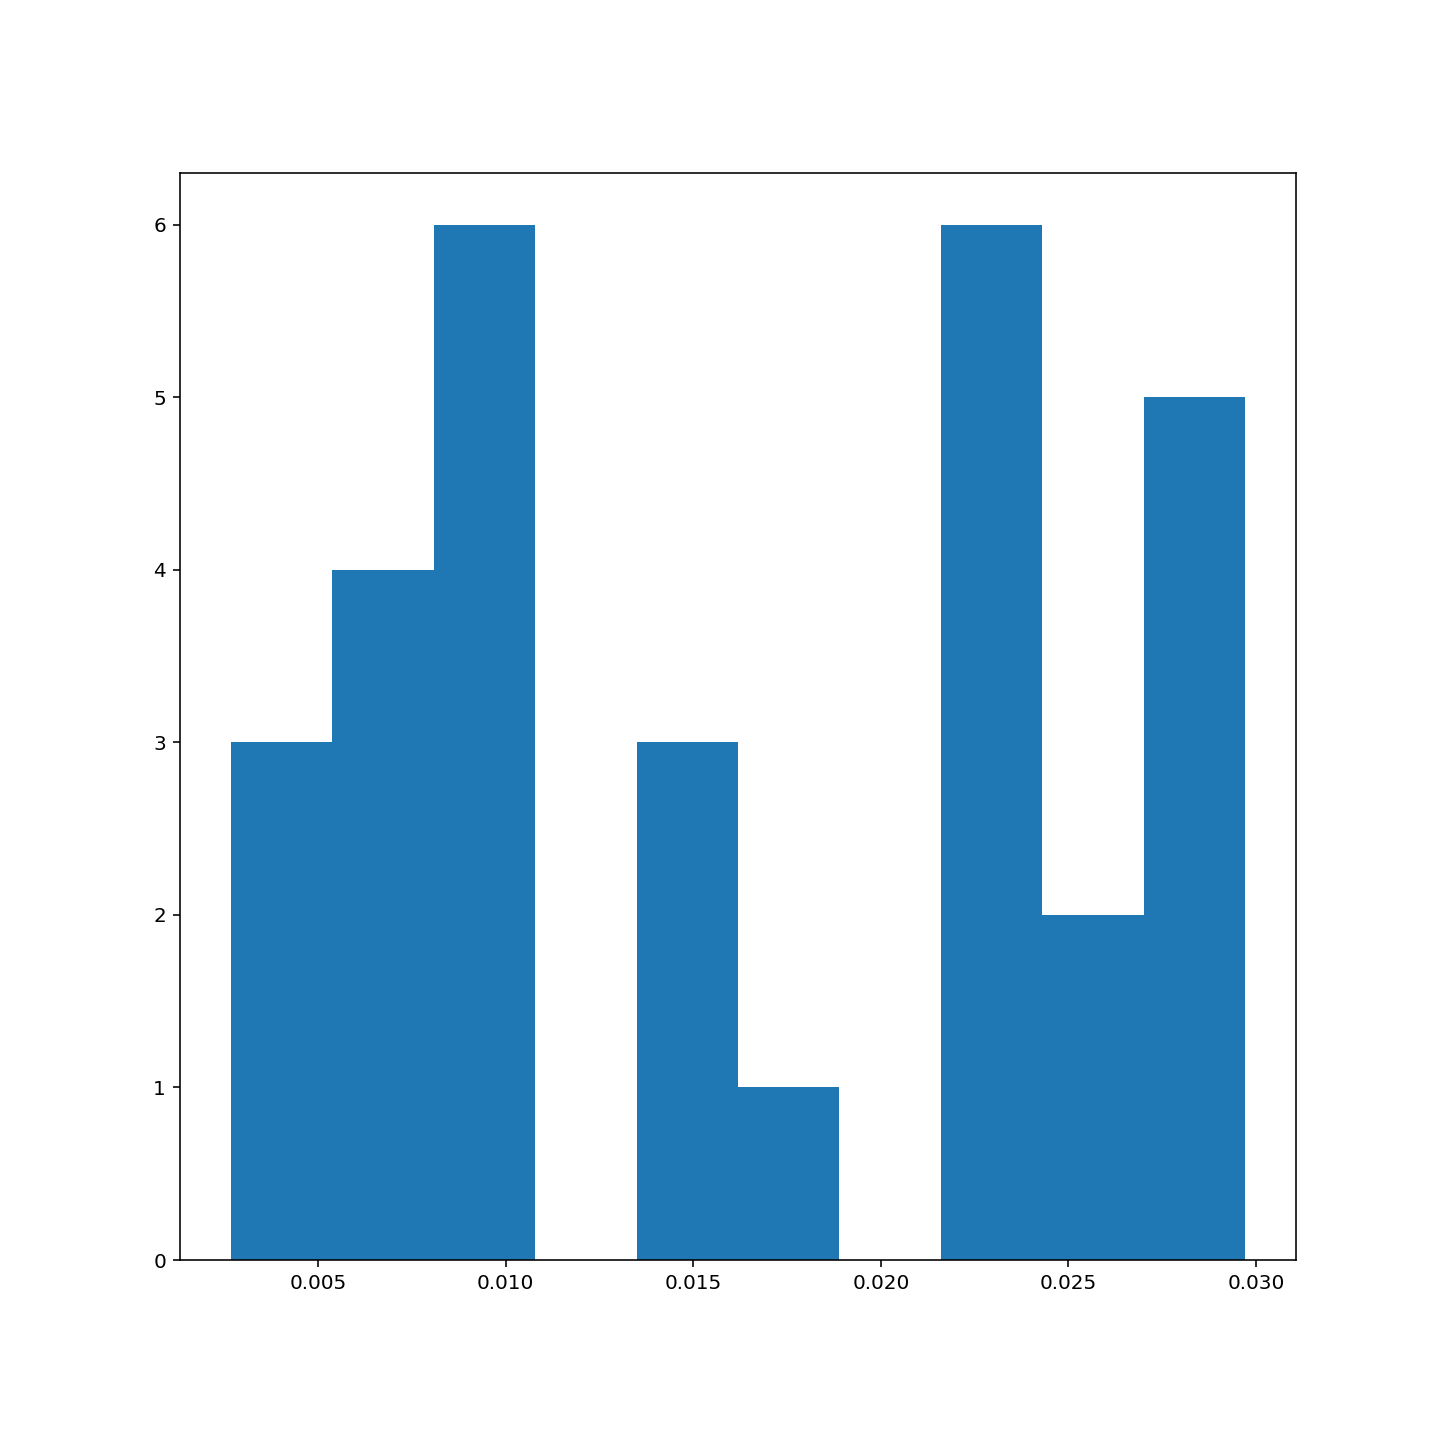

(array([3., 4., 6., 0., 3., 1., 0., 6., 2., 5.]),
 array([0.00267248, 0.00537668, 0.00808087, 0.01078506, 0.01348925,
        0.01619345, 0.01889764, 0.02160183, 0.02430602, 0.02701022,
        0.02971441]),
 <BarContainer object of 10 artists>)

In [199]:
plt.hist([r['noise_scale'] for r in res_noise])

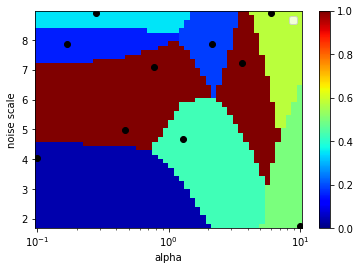

In [245]:
plt_heatmap_alpha_noise(res_noise)

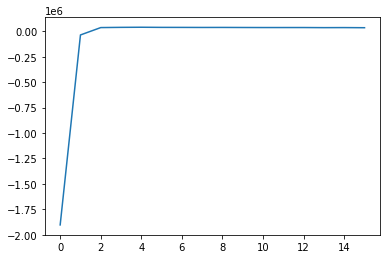

In [205]:
plt.plot(res_noise[1]['log_likelihoods'])

In [252]:
def rerun(alphas, res_noise, seed, inference_posterior_fn=vi_inference):
    newres = []
    pyro.set_rng_seed(seed)
    for a, ddict in zip(alphas, res_noise):
        newres.append(
            Run(a, datadict = ddict, noise_scale = ddict['noise_scale'], inference_posterior_fn=inference_posterior_fn,
               num_samples = 100).run())
    return newres

reruns = [rerun(alphas, res_noise, start_seed + i) for i in range(1, 10)]

0it [00:00, ?it/s]
  0%|          | 0/1600 [00:00<?, ?it/s]/home/ollie/anaconda3/lib/python3.8/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'obs'}
  warnings.warn(
  1%|          | 16/1600 [00:00<02:40,  9.86it/s]

ll -5706742.0


  7%|▋         | 119/1600 [00:01<00:25, 59.00it/s]

ll 28310.255859375


 14%|█▍        | 223/1600 [00:01<00:13, 101.50it/s]

ll 38973.5390625


 20%|██        | 327/1600 [00:02<00:11, 107.89it/s]

ll 39069.640625


 26%|██▌       | 416/1600 [00:03<00:10, 108.00it/s]

ll 39492.34375


 32%|███▎      | 520/1600 [00:04<00:09, 108.38it/s]

ll 40867.9609375


 39%|███▉      | 624/1600 [00:05<00:08, 108.90it/s]

ll 40527.43359375


 46%|████▌     | 728/1600 [00:06<00:07, 109.02it/s]

ll 40978.1015625


 51%|█████     | 817/1600 [00:06<00:07, 108.13it/s]

ll 42645.0859375


 58%|█████▊    | 921/1600 [00:07<00:06, 108.76it/s]

ll 42963.265625


 64%|██████▍   | 1025/1600 [00:08<00:05, 108.82it/s]

ll 44576.7109375


 70%|██████▉   | 1114/1600 [00:09<00:04, 98.43it/s] 

ll 45611.48046875


 76%|███████▌  | 1216/1600 [00:10<00:03, 97.00it/s] 

ll 45580.046875


 82%|████████▎ | 1320/1600 [00:11<00:02, 106.90it/s]

ll 46891.76171875


 89%|████████▉ | 1423/1600 [00:12<00:01, 107.65it/s]

ll 45826.19140625


 95%|█████████▌| 1527/1600 [00:13<00:00, 107.90it/s]

ll 47775.296875


100%|██████████| 1600/1600 [00:13<00:00, 117.15it/s]
0it [00:00, ?it/s]
  1%|          | 16/1600 [00:00<02:41,  9.79it/s]

ll -1867916.25


  7%|▋         | 119/1600 [00:01<00:25, 58.71it/s]

ll -80888.46875


 14%|█▍        | 223/1600 [00:01<00:13, 101.72it/s]

ll 31141.34375


 20%|██        | 327/1600 [00:02<00:11, 107.53it/s]

ll 38403.05078125


 26%|██▌       | 416/1600 [00:03<00:11, 107.20it/s]

ll 38942.0859375


 32%|███▎      | 520/1600 [00:04<00:09, 108.24it/s]

ll 39171.6875


 39%|███▉      | 624/1600 [00:05<00:08, 108.92it/s]

ll 38042.953125


 46%|████▌     | 728/1600 [00:06<00:08, 108.59it/s]

ll 38282.35546875


 51%|█████     | 817/1600 [00:06<00:07, 107.98it/s]

ll 37106.28125


 58%|█████▊    | 921/1600 [00:07<00:06, 108.60it/s]

ll 36480.015625


 64%|██████▍   | 1025/1600 [00:08<00:05, 108.50it/s]

ll 37445.81640625


 70%|██████▉   | 1114/1600 [00:09<00:04, 98.22it/s] 

ll 36351.30078125


 76%|███████▌  | 1218/1600 [00:10<00:03, 107.41it/s]

ll 36900.31640625


 83%|████████▎ | 1322/1600 [00:11<00:02, 108.65it/s]

ll 35824.9140625


 89%|████████▉ | 1426/1600 [00:12<00:01, 108.20it/s]

ll 35695.41015625


 95%|█████████▍| 1516/1600 [00:12<00:00, 108.86it/s]

ll 35652.26953125


100%|██████████| 1600/1600 [00:13<00:00, 119.39it/s]
0it [00:00, ?it/s]
  1%|          | 16/1600 [00:00<02:41,  9.81it/s]

ll -3357771.75


  7%|▋         | 119/1600 [00:01<00:25, 58.62it/s]

ll -2249.972412109375


 14%|█▍        | 223/1600 [00:01<00:13, 101.80it/s]

ll 16717.203125


 20%|██        | 327/1600 [00:02<00:11, 108.32it/s]

ll 22491.939453125


 26%|██▌       | 416/1600 [00:03<00:10, 107.99it/s]

ll 24630.1796875


 32%|███▎      | 520/1600 [00:04<00:09, 108.87it/s]

ll 26412.796875


 39%|███▉      | 624/1600 [00:05<00:08, 109.07it/s]

ll 27036.828125


 46%|████▌     | 728/1600 [00:06<00:08, 108.81it/s]

ll 26970.041015625


 51%|█████     | 817/1600 [00:06<00:07, 108.14it/s]

ll 27095.18359375


 58%|█████▊    | 921/1600 [00:07<00:06, 108.92it/s]

ll 26880.7578125


 64%|██████▍   | 1025/1600 [00:08<00:05, 108.60it/s]

ll 26951.96484375


 70%|██████▉   | 1114/1600 [00:09<00:04, 98.88it/s] 

ll 27840.91796875


 76%|███████▌  | 1218/1600 [00:10<00:03, 107.45it/s]

ll 26842.931640625


 82%|████████▏ | 1307/1600 [00:11<00:02, 98.12it/s] 

ll 26978.23046875


 89%|████████▉ | 1423/1600 [00:12<00:01, 103.36it/s]

ll 27825.50390625


 95%|█████████▌| 1527/1600 [00:13<00:00, 108.02it/s]

ll 27827.466796875


100%|██████████| 1600/1600 [00:13<00:00, 117.82it/s]
0it [00:00, ?it/s]
  1%|          | 16/1600 [00:00<02:41,  9.78it/s]

ll -2525420.75


  7%|▋         | 119/1600 [00:01<00:25, 58.53it/s]

ll -15046.1015625


 14%|█▍        | 223/1600 [00:01<00:13, 100.69it/s]

ll 21728.46875


 20%|██        | 327/1600 [00:02<00:11, 107.20it/s]

ll 27805.28515625


 26%|██▌       | 416/1600 [00:03<00:11, 106.91it/s]

ll 28609.32421875


 32%|███▎      | 520/1600 [00:04<00:10, 107.88it/s]

ll 29023.404296875


 39%|███▉      | 624/1600 [00:05<00:09, 107.75it/s]

ll 29402.27734375


 46%|████▌     | 728/1600 [00:06<00:08, 107.75it/s]

ll 29035.615234375


 51%|█████     | 817/1600 [00:07<00:07, 106.90it/s]

ll 29242.91015625


 58%|█████▊    | 921/1600 [00:07<00:06, 107.98it/s]

ll 30021.779296875


 64%|██████▍   | 1025/1600 [00:08<00:05, 108.36it/s]

ll 29264.984375


 70%|██████▉   | 1114/1600 [00:09<00:04, 97.97it/s] 

ll 29485.74609375


 76%|███████▌  | 1218/1600 [00:10<00:03, 107.13it/s]

ll 29245.197265625


 83%|████████▎ | 1322/1600 [00:11<00:02, 108.59it/s]

ll 28919.23046875


 89%|████████▉ | 1426/1600 [00:12<00:01, 108.57it/s]

ll 29604.87890625


 95%|█████████▍| 1516/1600 [00:12<00:00, 109.33it/s]

ll 29563.76953125


100%|██████████| 1600/1600 [00:13<00:00, 118.87it/s]
0it [00:00, ?it/s]
  1%|          | 16/1600 [00:00<02:41,  9.79it/s]

ll -825060.625


  7%|▋         | 119/1600 [00:01<00:25, 58.75it/s]

ll -6997.75048828125


 14%|█▍        | 223/1600 [00:01<00:13, 101.35it/s]

ll 16177.060546875


 20%|██        | 327/1600 [00:02<00:11, 107.71it/s]

ll 22500.6953125


 26%|██▌       | 416/1600 [00:03<00:10, 107.73it/s]

ll 24312.357421875


 32%|███▎      | 520/1600 [00:04<00:09, 108.69it/s]

ll 25833.216796875


 39%|███▉      | 624/1600 [00:05<00:08, 108.77it/s]

ll 26926.30078125


 46%|████▌     | 728/1600 [00:06<00:08, 108.74it/s]

ll 26653.037109375


 51%|█████     | 817/1600 [00:06<00:07, 107.80it/s]

ll 26132.87109375


 58%|█████▊    | 921/1600 [00:07<00:06, 108.26it/s]

ll 26996.845703125


 64%|██████▍   | 1025/1600 [00:08<00:05, 107.78it/s]

ll 27483.240234375


 70%|██████▉   | 1114/1600 [00:09<00:04, 97.96it/s] 

ll 27337.404296875


 76%|███████▌  | 1218/1600 [00:10<00:03, 107.78it/s]

ll 27567.890625


 83%|████████▎ | 1322/1600 [00:11<00:02, 108.61it/s]

ll 27279.73828125


 89%|████████▉ | 1426/1600 [00:12<00:01, 108.69it/s]

ll 27091.609375


 96%|█████████▌| 1528/1600 [00:13<00:00, 95.47it/s] 

ll 27297.6015625


100%|██████████| 1600/1600 [00:13<00:00, 117.60it/s]
0it [00:00, ?it/s]
  1%|          | 16/1600 [00:00<02:41,  9.78it/s]

ll -4811609.5


  7%|▋         | 119/1600 [00:01<00:25, 58.72it/s]

ll -26241.830078125


 14%|█▍        | 223/1600 [00:01<00:13, 101.41it/s]

ll 25695.6484375


 20%|██        | 327/1600 [00:02<00:11, 107.82it/s]

ll 30283.36328125


 26%|██▌       | 416/1600 [00:03<00:11, 107.47it/s]

ll 31899.712890625


 32%|███▎      | 520/1600 [00:04<00:10, 107.76it/s]

ll 32604.90234375


 39%|███▉      | 624/1600 [00:05<00:09, 107.94it/s]

ll 34144.28125


 46%|████▌     | 728/1600 [00:06<00:08, 107.63it/s]

ll 33761.26171875


 51%|█████     | 817/1600 [00:06<00:07, 106.74it/s]

ll 34132.12890625


 58%|█████▊    | 921/1600 [00:07<00:06, 107.82it/s]

ll 34274.80078125


 64%|██████▍   | 1025/1600 [00:08<00:05, 107.96it/s]

ll 35341.796875


 70%|██████▉   | 1114/1600 [00:09<00:04, 97.49it/s] 

ll 34864.3515625


 76%|███████▌  | 1218/1600 [00:10<00:03, 106.71it/s]

ll 34737.734375


 83%|████████▎ | 1322/1600 [00:11<00:02, 107.82it/s]

ll 34225.45703125


 89%|████████▉ | 1426/1600 [00:12<00:01, 107.62it/s]

ll 34902.1484375


 95%|█████████▍| 1516/1600 [00:12<00:00, 108.39it/s]

ll 34624.00390625


100%|██████████| 1600/1600 [00:13<00:00, 118.82it/s]
0it [00:00, ?it/s]
  1%|          | 16/1600 [00:00<02:41,  9.79it/s]

ll -1637737.0


  7%|▋         | 119/1600 [00:01<00:25, 58.75it/s]

ll 10087.7939453125


 14%|█▍        | 223/1600 [00:01<00:13, 101.35it/s]

ll 29715.361328125


 20%|██        | 327/1600 [00:02<00:11, 107.48it/s]

ll 31937.16015625


 26%|██▌       | 416/1600 [00:03<00:11, 106.95it/s]

ll 33094.4921875


 32%|███▎      | 520/1600 [00:04<00:09, 108.45it/s]

ll 33765.08203125


 39%|███▉      | 624/1600 [00:05<00:08, 108.53it/s]

ll 34754.953125


 46%|████▌     | 728/1600 [00:06<00:08, 108.60it/s]

ll 34530.796875


 51%|█████     | 817/1600 [00:06<00:07, 106.91it/s]

ll 34056.3671875


 58%|█████▊    | 921/1600 [00:07<00:06, 107.64it/s]

ll 34318.7109375


 64%|██████▍   | 1025/1600 [00:08<00:05, 107.62it/s]

ll 35424.32421875


 70%|██████▉   | 1114/1600 [00:09<00:04, 97.58it/s] 

ll 35020.16796875


 76%|███████▌  | 1218/1600 [00:10<00:03, 106.75it/s]

ll 35439.078125


 83%|████████▎ | 1322/1600 [00:11<00:02, 107.83it/s]

ll 35042.03515625


 89%|████████▉ | 1426/1600 [00:12<00:01, 108.14it/s]

ll 34748.58984375


 95%|█████████▍| 1516/1600 [00:12<00:00, 108.43it/s]

ll 35017.73828125


100%|██████████| 1600/1600 [00:13<00:00, 118.86it/s]
0it [00:00, ?it/s]
  1%|          | 16/1600 [00:00<02:42,  9.75it/s]

ll -1211931.125


  7%|▋         | 119/1600 [00:01<00:25, 58.61it/s]

ll -5972.232421875


 14%|█▍        | 223/1600 [00:01<00:13, 100.90it/s]

ll 19703.65625


 20%|██        | 327/1600 [00:02<00:11, 107.43it/s]

ll 24858.3046875


 26%|██▌       | 416/1600 [00:03<00:11, 106.84it/s]

ll 27080.955078125


 32%|███▎      | 520/1600 [00:04<00:10, 107.47it/s]

ll 28594.4375


 39%|███▉      | 624/1600 [00:05<00:09, 107.63it/s]

ll 28689.34765625


 46%|████▌     | 728/1600 [00:06<00:08, 107.88it/s]

ll 29566.5859375


 51%|█████     | 817/1600 [00:06<00:07, 106.94it/s]

ll 29539.908203125


 58%|█████▊    | 921/1600 [00:07<00:06, 107.59it/s]

ll 30131.66015625


 64%|██████▍   | 1025/1600 [00:08<00:05, 107.51it/s]

ll 29051.689453125


 70%|██████▉   | 1114/1600 [00:09<00:04, 97.74it/s] 

ll 29768.97265625


 76%|███████▌  | 1218/1600 [00:10<00:03, 106.96it/s]

ll 28811.341796875


 83%|████████▎ | 1322/1600 [00:11<00:02, 107.92it/s]

ll 29573.33984375


 89%|████████▉ | 1426/1600 [00:12<00:01, 107.98it/s]

ll 30042.1171875


 95%|█████████▍| 1516/1600 [00:12<00:00, 108.56it/s]

ll 28540.03515625


100%|██████████| 1600/1600 [00:13<00:00, 118.67it/s]
0it [00:00, ?it/s]
  1%|          | 16/1600 [00:00<02:42,  9.74it/s]

ll -1004000.375


  7%|▋         | 119/1600 [00:01<00:25, 58.39it/s]

ll 9363.810546875


 14%|█▍        | 223/1600 [00:01<00:13, 100.71it/s]

ll 23498.009765625


 20%|██        | 327/1600 [00:02<00:11, 106.96it/s]

ll 29309.19140625


 26%|██▌       | 416/1600 [00:03<00:11, 106.70it/s]

ll 31686.98046875


 32%|███▎      | 520/1600 [00:04<00:10, 107.40it/s]

ll 31904.23828125


 39%|███▉      | 624/1600 [00:05<00:09, 107.50it/s]

ll 31672.72265625


 46%|████▌     | 728/1600 [00:06<00:08, 107.81it/s]

ll 31868.697265625


 51%|█████     | 817/1600 [00:07<00:07, 106.88it/s]

ll 31880.205078125


 58%|█████▊    | 921/1600 [00:07<00:06, 107.58it/s]

ll 31460.490234375


 64%|██████▍   | 1025/1600 [00:08<00:05, 107.82it/s]

ll 32479.02734375


 70%|██████▉   | 1114/1600 [00:09<00:04, 97.61it/s] 

ll 32093.150390625


 76%|███████▌  | 1218/1600 [00:10<00:03, 106.77it/s]

ll 31582.748046875


 83%|████████▎ | 1322/1600 [00:11<00:02, 107.54it/s]

ll 31447.76171875


 89%|████████▉ | 1426/1600 [00:12<00:01, 107.57it/s]

ll 32183.47265625


 95%|█████████▍| 1516/1600 [00:12<00:00, 108.10it/s]

ll 31840.8203125


100%|██████████| 1600/1600 [00:13<00:00, 118.35it/s]
0it [00:00, ?it/s]
  1%|          | 16/1600 [00:00<02:42,  9.75it/s]

ll -1157935.375


  7%|▋         | 119/1600 [00:01<00:25, 58.37it/s]

ll -26677.23828125


 14%|█▍        | 220/1600 [00:02<00:15, 91.71it/s]

ll 13451.490234375


 20%|██        | 324/1600 [00:03<00:12, 106.08it/s]

ll 30974.591796875


 27%|██▋       | 428/1600 [00:03<00:10, 107.36it/s]

ll 33617.87109375


 32%|███▏      | 517/1600 [00:04<00:10, 106.77it/s]

ll 34442.28125


 39%|███▉      | 621/1600 [00:05<00:09, 107.50it/s]

ll 35217.9140625


 45%|████▌     | 725/1600 [00:06<00:08, 107.49it/s]

ll 35227.4921875


 51%|█████     | 814/1600 [00:07<00:08, 97.70it/s] 

ll 34795.1328125


 57%|█████▋    | 918/1600 [00:08<00:06, 107.45it/s]

ll 35096.296875


 64%|██████▍   | 1022/1600 [00:08<00:05, 108.31it/s]

ll 34840.9765625


 70%|███████   | 1126/1600 [00:09<00:04, 108.45it/s]

ll 34617.375


 76%|███████▌  | 1216/1600 [00:10<00:03, 108.91it/s]

ll 35409.828125


 82%|████████▎ | 1320/1600 [00:11<00:02, 108.36it/s]

ll 34846.0859375


 89%|████████▉ | 1424/1600 [00:12<00:01, 107.82it/s]

ll 35076.1640625


 96%|█████████▌| 1528/1600 [00:13<00:00, 108.29it/s]

ll 36042.640625


100%|██████████| 1600/1600 [00:13<00:00, 116.92it/s]
0it [00:00, ?it/s]
  1%|          | 16/1600 [00:00<02:43,  9.68it/s]

ll -5747832.0


  7%|▋         | 119/1600 [00:01<00:25, 58.36it/s]

ll -54955.03125


 14%|█▍        | 223/1600 [00:01<00:13, 101.09it/s]

ll 28912.166015625


 20%|██        | 327/1600 [00:02<00:11, 107.56it/s]

ll 34655.375


 26%|██▌       | 416/1600 [00:03<00:11, 107.23it/s]

ll 38165.5859375


 32%|███▎      | 520/1600 [00:04<00:10, 107.92it/s]

ll 39691.15625


 39%|███▉      | 624/1600 [00:05<00:09, 108.18it/s]

ll 40746.7578125


 46%|████▌     | 728/1600 [00:06<00:08, 107.94it/s]

ll 42702.6015625


 51%|█████     | 817/1600 [00:06<00:07, 107.35it/s]

ll 44097.296875


 58%|█████▊    | 921/1600 [00:07<00:06, 108.23it/s]

ll 45024.97265625


 64%|██████▍   | 1025/1600 [00:08<00:05, 108.20it/s]

ll 46394.9140625


 70%|██████▉   | 1114/1600 [00:09<00:04, 98.19it/s] 

ll 45525.5234375


 76%|███████▌  | 1218/1600 [00:10<00:03, 106.95it/s]

ll 44606.82421875


 83%|████████▎ | 1322/1600 [00:11<00:02, 108.13it/s]

ll 47299.41796875


 89%|████████▉ | 1426/1600 [00:12<00:01, 108.19it/s]

ll 48946.8125


 95%|█████████▍| 1516/1600 [00:12<00:00, 108.95it/s]

ll 47482.1328125


100%|██████████| 1600/1600 [00:13<00:00, 119.08it/s]
0it [00:00, ?it/s]
  1%|          | 16/1600 [00:00<02:42,  9.76it/s]

ll -1899430.375


  7%|▋         | 119/1600 [00:01<00:25, 58.52it/s]

ll 22857.0703125


 14%|█▍        | 223/1600 [00:01<00:13, 100.77it/s]

ll 37477.109375


 19%|█▊        | 298/1600 [00:02<00:09, 132.67it/s]

ll 38685.15625


 26%|██▌       | 414/1600 [00:03<00:12, 93.87it/s] 

ll 38173.39453125


 33%|███▎      | 528/1600 [00:04<00:10, 107.13it/s]

ll 37201.67578125


 38%|███▊      | 614/1600 [00:05<00:10, 97.26it/s] 

ll 37308.890625


 45%|████▍     | 714/1600 [00:06<00:09, 97.37it/s] 

ll 36602.4609375


 52%|█████▏    | 828/1600 [00:07<00:07, 107.50it/s]

ll 36618.75390625


 57%|█████▋    | 916/1600 [00:08<00:06, 106.43it/s]

ll 35516.34765625


 64%|██████▎   | 1017/1600 [00:08<00:05, 107.58it/s]

ll 35344.7109375


 70%|██████▉   | 1119/1600 [00:09<00:04, 107.28it/s]

ll 36383.46484375


 76%|███████▋  | 1220/1600 [00:10<00:03, 107.68it/s]

ll 34963.171875


 83%|████████▎ | 1324/1600 [00:11<00:02, 107.97it/s]

ll 35611.8671875


 89%|████████▉ | 1428/1600 [00:12<00:01, 107.81it/s]

ll 34772.5625


 95%|█████████▍| 1516/1600 [00:13<00:00, 106.36it/s]

ll 34990.82421875


100%|██████████| 1600/1600 [00:13<00:00, 116.44it/s]
0it [00:00, ?it/s]
  1%|          | 16/1600 [00:00<02:42,  9.73it/s]

ll -3325599.5


  7%|▋         | 119/1600 [00:01<00:25, 58.46it/s]

ll -3430.324462890625


 14%|█▍        | 223/1600 [00:01<00:13, 101.14it/s]

ll 20618.21484375


 20%|██        | 327/1600 [00:02<00:11, 107.13it/s]

ll 26175.390625


 26%|██▌       | 416/1600 [00:03<00:10, 108.11it/s]

ll 27525.0859375


 32%|███▎      | 520/1600 [00:04<00:09, 108.05it/s]

ll 28883.8203125


 39%|███▉      | 624/1600 [00:05<00:09, 108.07it/s]

ll 29661.474609375


 46%|████▌     | 728/1600 [00:06<00:08, 108.08it/s]

ll 29591.34375


 51%|█████     | 817/1600 [00:06<00:07, 107.21it/s]

ll 29572.001953125


 57%|█████▊    | 920/1600 [00:07<00:06, 107.51it/s]

ll 30291.357421875


 64%|██████▍   | 1024/1600 [00:08<00:05, 107.74it/s]

ll 29648.85546875


 70%|███████   | 1123/1600 [00:09<00:04, 107.17it/s]

ll 29602.4375


 76%|███████▋  | 1223/1600 [00:10<00:03, 107.38it/s]

ll 29591.1640625


 83%|████████▎ | 1325/1600 [00:11<00:02, 107.51it/s]

ll 29569.7265625


 89%|████████▉ | 1427/1600 [00:12<00:01, 107.62it/s]

ll 29724.861328125


 95%|█████████▍| 1516/1600 [00:12<00:00, 107.21it/s]

ll 29485.9140625


100%|██████████| 1600/1600 [00:13<00:00, 118.64it/s]
0it [00:00, ?it/s]
  1%|          | 16/1600 [00:00<02:42,  9.74it/s]

ll -2532321.5


  7%|▋         | 118/1600 [00:01<00:25, 58.33it/s]

ll -26099.876953125


 14%|█▍        | 221/1600 [00:01<00:13, 100.55it/s]

ll 4726.21484375


 20%|██        | 324/1600 [00:02<00:11, 107.00it/s]

ll 12916.416015625


 27%|██▋       | 427/1600 [00:03<00:10, 107.39it/s]

ll 15706.7666015625


 33%|███▎      | 523/1600 [00:04<00:13, 82.63it/s] 

ll 19137.458984375


 39%|███▉      | 622/1600 [00:05<00:09, 104.91it/s]

ll 19700.029296875


 45%|████▌     | 722/1600 [00:06<00:08, 107.20it/s]

ll 20262.453125


 52%|█████▏    | 824/1600 [00:07<00:07, 107.48it/s]

ll 21115.544921875


 58%|█████▊    | 928/1600 [00:08<00:06, 107.97it/s]

ll 21200.2421875


 64%|██████▎   | 1016/1600 [00:08<00:05, 106.66it/s]

ll 21366.58203125


 70%|██████▉   | 1116/1600 [00:09<00:04, 107.25it/s]

ll 21391.900390625


 76%|███████▌  | 1218/1600 [00:10<00:03, 107.40it/s]

ll 21674.76171875


 83%|████████▎ | 1322/1600 [00:11<00:02, 107.93it/s]

ll 21851.798828125


 89%|████████▉ | 1426/1600 [00:12<00:01, 107.93it/s]

ll 22349.5234375


 95%|█████████▍| 1516/1600 [00:13<00:00, 108.39it/s]

ll 22008.28125


100%|██████████| 1600/1600 [00:13<00:00, 116.45it/s]
0it [00:00, ?it/s]
  1%|          | 16/1600 [00:00<02:42,  9.72it/s]

ll -814486.9375


  7%|▋         | 117/1600 [00:01<00:25, 58.22it/s]

ll -2467.743896484375


 14%|█▍        | 220/1600 [00:01<00:13, 100.91it/s]

ll 18391.37890625


 20%|██        | 324/1600 [00:02<00:11, 106.87it/s]

ll 24106.130859375


 27%|██▋       | 425/1600 [00:03<00:10, 107.29it/s]

ll 25045.58984375


 33%|███▎      | 526/1600 [00:04<00:10, 107.30it/s]

ll 24464.7734375


 38%|███▊      | 614/1600 [00:05<00:10, 97.31it/s] 

ll 24766.576171875


 45%|████▍     | 717/1600 [00:06<00:08, 106.51it/s]

ll 25060.22265625


 51%|█████▏    | 821/1600 [00:07<00:07, 107.49it/s]

ll 25002.64453125


 58%|█████▊    | 925/1600 [00:07<00:06, 107.81it/s]

ll 24567.017578125


 63%|██████▎   | 1014/1600 [00:08<00:06, 97.65it/s] 

ll 24441.0078125


 70%|██████▉   | 1117/1600 [00:09<00:04, 106.63it/s]

ll 24955.6875


 76%|███████▋  | 1220/1600 [00:10<00:03, 107.46it/s]

ll 24550.689453125


 83%|████████▎ | 1322/1600 [00:11<00:02, 107.37it/s]

ll 24743.4609375


 89%|████████▉ | 1423/1600 [00:12<00:01, 107.46it/s]

ll 25184.2421875


 95%|█████████▌| 1527/1600 [00:13<00:00, 107.98it/s]

ll 24922.076171875


100%|██████████| 1600/1600 [00:13<00:00, 118.31it/s]
0it [00:00, ?it/s]
  1%|          | 16/1600 [00:00<02:42,  9.76it/s]

ll -4766260.0


  7%|▋         | 119/1600 [00:01<00:25, 58.57it/s]

ll -115659.921875


 14%|█▍        | 223/1600 [00:01<00:13, 101.17it/s]

ll -38430.625


 20%|██        | 327/1600 [00:02<00:11, 107.50it/s]

ll -12989.15625


 26%|██▌       | 416/1600 [00:03<00:11, 107.19it/s]

ll 13969.197265625


 32%|███▎      | 520/1600 [00:04<00:10, 107.95it/s]

ll 25941.154296875


 39%|███▉      | 624/1600 [00:05<00:09, 108.08it/s]

ll 30181.9296875


 45%|████▌     | 725/1600 [00:06<00:09, 89.53it/s] 

ll 32093.96484375


 52%|█████▏    | 826/1600 [00:07<00:07, 105.75it/s]

ll 33635.47265625


 58%|█████▊    | 927/1600 [00:08<00:06, 107.46it/s]

ll 33935.40234375


 64%|██████▎   | 1016/1600 [00:08<00:05, 107.10it/s]

ll 34359.4296875


 70%|██████▉   | 1117/1600 [00:09<00:04, 107.33it/s]

ll 34893.10546875


 76%|███████▌  | 1219/1600 [00:10<00:03, 107.48it/s]

ll 34601.04296875


 82%|████████▎ | 1320/1600 [00:11<00:02, 107.26it/s]

ll 35113.79296875


 89%|████████▉ | 1422/1600 [00:12<00:01, 107.45it/s]

ll 35090.0


 95%|█████████▌| 1526/1600 [00:13<00:00, 108.01it/s]

ll 34979.9296875


100%|██████████| 1600/1600 [00:13<00:00, 116.84it/s]
0it [00:00, ?it/s]
  1%|          | 16/1600 [00:00<02:42,  9.77it/s]

ll -1654946.875


  7%|▋         | 119/1600 [00:01<00:25, 58.59it/s]

ll 4379.837890625


 14%|█▍        | 223/1600 [00:01<00:13, 101.13it/s]

ll 29503.5390625


 20%|██        | 327/1600 [00:02<00:11, 107.37it/s]

ll 32559.48828125


 26%|██▌       | 416/1600 [00:03<00:11, 106.89it/s]

ll 34237.76171875


 32%|███▎      | 520/1600 [00:04<00:10, 107.94it/s]

ll 34522.14453125


 39%|███▉      | 624/1600 [00:05<00:09, 107.79it/s]

ll 34773.73046875


 46%|████▌     | 728/1600 [00:06<00:08, 108.19it/s]

ll 34707.5859375


 51%|█████     | 817/1600 [00:06<00:07, 107.29it/s]

ll 35026.5703125


 58%|█████▊    | 921/1600 [00:07<00:06, 108.11it/s]

ll 34938.7421875


 64%|██████▍   | 1025/1600 [00:08<00:05, 108.18it/s]

ll 35481.796875


 70%|██████▉   | 1114/1600 [00:09<00:04, 98.01it/s] 

ll 35338.21875


 76%|███████▌  | 1218/1600 [00:10<00:03, 107.12it/s]

ll 34881.625


 83%|████████▎ | 1322/1600 [00:11<00:02, 107.61it/s]

ll 35510.0390625


 89%|████████▉ | 1426/1600 [00:12<00:01, 108.08it/s]

ll 35292.3984375


 95%|█████████▍| 1516/1600 [00:12<00:00, 108.65it/s]

ll 34454.69140625


100%|██████████| 1600/1600 [00:13<00:00, 118.97it/s]
0it [00:00, ?it/s]
  1%|          | 16/1600 [00:00<02:42,  9.75it/s]

ll -1210234.5


  7%|▋         | 119/1600 [00:01<00:25, 58.56it/s]

ll -18500.169921875


 14%|█▍        | 223/1600 [00:01<00:13, 101.16it/s]

ll 18027.1953125


 20%|██        | 327/1600 [00:02<00:11, 107.61it/s]

ll 25646.13671875


 26%|██▌       | 416/1600 [00:03<00:11, 107.01it/s]

ll 28091.6015625


 32%|███▏      | 519/1600 [00:04<00:10, 107.46it/s]

ll 28543.23828125


 39%|███▉      | 623/1600 [00:05<00:09, 107.63it/s]

ll 29638.05859375


 45%|████▌     | 727/1600 [00:06<00:08, 107.62it/s]

ll 29413.056640625


 51%|█████     | 816/1600 [00:06<00:07, 106.76it/s]

ll 29342.85546875


 57%|█████▋    | 917/1600 [00:08<00:07, 97.23it/s] 

ll 29970.505859375


 64%|██████▍   | 1021/1600 [00:08<00:05, 107.12it/s]

ll 30803.916015625


 70%|███████   | 1125/1600 [00:09<00:04, 107.75it/s]

ll 30107.826171875


 76%|███████▌  | 1214/1600 [00:10<00:03, 97.65it/s] 

ll 30239.900390625


 82%|████████▏ | 1318/1600 [00:11<00:02, 106.89it/s]

ll 29492.75390625


 89%|████████▉ | 1421/1600 [00:12<00:01, 107.47it/s]

ll 30056.650390625


 95%|█████████▌| 1523/1600 [00:13<00:00, 107.50it/s]

ll 29802.75


100%|██████████| 1600/1600 [00:13<00:00, 116.76it/s]
0it [00:00, ?it/s]
  1%|          | 16/1600 [00:00<02:42,  9.74it/s]

ll -1037578.0625


  7%|▋         | 119/1600 [00:01<00:25, 58.47it/s]

ll 8319.2421875


 14%|█▍        | 223/1600 [00:01<00:13, 101.21it/s]

ll 23887.361328125


 20%|██        | 327/1600 [00:02<00:11, 107.54it/s]

ll 28139.09765625


 26%|██▌       | 416/1600 [00:03<00:11, 107.30it/s]

ll 30016.865234375


 32%|███▎      | 520/1600 [00:04<00:09, 108.22it/s]

ll 30446.650390625


 39%|███▉      | 624/1600 [00:05<00:09, 108.25it/s]

ll 31012.5625


 46%|████▌     | 728/1600 [00:06<00:08, 108.31it/s]

ll 30849.853515625


 51%|█████     | 817/1600 [00:06<00:07, 107.48it/s]

ll 31308.35546875


 58%|█████▊    | 921/1600 [00:07<00:06, 108.31it/s]

ll 31810.99609375


 64%|██████▍   | 1025/1600 [00:08<00:05, 108.29it/s]

ll 31619.923828125


 70%|██████▉   | 1114/1600 [00:09<00:04, 98.29it/s] 

ll 31156.6796875


 76%|███████▌  | 1218/1600 [00:10<00:03, 107.42it/s]

ll 31668.625


 83%|████████▎ | 1322/1600 [00:11<00:02, 108.24it/s]

ll 32026.94140625


 89%|████████▉ | 1426/1600 [00:12<00:01, 108.31it/s]

ll 31622.345703125


 95%|█████████▍| 1516/1600 [00:12<00:00, 108.44it/s]

ll 31124.634765625


100%|██████████| 1600/1600 [00:13<00:00, 119.20it/s]
0it [00:00, ?it/s]
  1%|          | 16/1600 [00:00<02:42,  9.75it/s]

ll -1151457.75


  7%|▋         | 119/1600 [00:01<00:25, 58.62it/s]

ll -22504.052734375


 14%|█▍        | 223/1600 [00:01<00:13, 100.92it/s]

ll 23314.28125


 20%|██        | 327/1600 [00:02<00:11, 107.73it/s]

ll 31571.265625


 26%|██▌       | 416/1600 [00:03<00:11, 107.04it/s]

ll 34879.4609375


 32%|███▎      | 520/1600 [00:04<00:10, 107.55it/s]

ll 36826.5


 39%|███▉      | 624/1600 [00:05<00:09, 107.66it/s]

ll 37727.484375


 46%|████▌     | 728/1600 [00:06<00:08, 107.54it/s]

ll 37982.6328125


 51%|█████     | 817/1600 [00:06<00:07, 106.70it/s]

ll 38700.9296875


 58%|█████▊    | 921/1600 [00:07<00:06, 107.43it/s]

ll 38049.70703125


 64%|██████▍   | 1021/1600 [00:08<00:06, 82.84it/s]

ll 38055.6171875


 70%|███████   | 1125/1600 [00:09<00:04, 104.94it/s]

ll 37099.484375


 76%|███████▌  | 1214/1600 [00:10<00:03, 97.45it/s] 

ll 37994.6640625


 82%|████████▏ | 1318/1600 [00:11<00:02, 106.54it/s]

ll 36849.80078125


 89%|████████▉ | 1422/1600 [00:12<00:01, 107.46it/s]

ll 37105.6640625


 95%|█████████▌| 1526/1600 [00:13<00:00, 107.59it/s]

ll 36522.484375


100%|██████████| 1600/1600 [00:13<00:00, 116.67it/s]
0it [00:00, ?it/s]
  1%|          | 16/1600 [00:00<02:42,  9.73it/s]

ll -5810429.5


  7%|▋         | 119/1600 [00:01<00:25, 58.47it/s]

ll 12913.6455078125


 14%|█▍        | 223/1600 [00:01<00:13, 101.20it/s]

ll 38249.03125


 20%|██        | 327/1600 [00:02<00:11, 107.69it/s]

ll 40493.109375


 26%|██▌       | 416/1600 [00:03<00:11, 107.29it/s]

ll 40955.140625


 32%|███▎      | 520/1600 [00:04<00:10, 107.72it/s]

ll 41979.12109375


 39%|███▉      | 624/1600 [00:05<00:09, 108.12it/s]

ll 42422.40625


 46%|████▌     | 728/1600 [00:06<00:08, 108.23it/s]

ll 43265.01171875


 51%|█████     | 817/1600 [00:06<00:07, 107.37it/s]

ll 42747.2734375


 58%|█████▊    | 921/1600 [00:07<00:06, 108.21it/s]

ll 43694.9765625


 64%|██████▍   | 1025/1600 [00:08<00:05, 108.29it/s]

ll 43601.6484375


 70%|██████▉   | 1114/1600 [00:09<00:04, 98.27it/s] 

ll 45419.8828125


 76%|███████▌  | 1218/1600 [00:10<00:03, 107.37it/s]

ll 43239.6484375


 83%|████████▎ | 1322/1600 [00:11<00:02, 108.22it/s]

ll 46045.62109375


 89%|████████▉ | 1426/1600 [00:12<00:01, 108.32it/s]

ll 47338.69140625


 95%|█████████▍| 1516/1600 [00:12<00:00, 109.00it/s]

ll 46172.3515625


100%|██████████| 1600/1600 [00:13<00:00, 119.19it/s]
0it [00:00, ?it/s]
  1%|          | 16/1600 [00:00<02:43,  9.70it/s]

ll -1878554.875


  7%|▋         | 119/1600 [00:01<00:25, 58.39it/s]

ll 30003.181640625


 14%|█▍        | 223/1600 [00:01<00:13, 100.93it/s]

ll 37752.34765625


 20%|██        | 325/1600 [00:02<00:11, 106.77it/s]

ll 38471.87109375


 27%|██▋       | 427/1600 [00:03<00:10, 107.44it/s]

ll 38209.12890625


 32%|███▏      | 514/1600 [00:04<00:11, 97.36it/s] 

ll 38376.9296875


 39%|███▊      | 618/1600 [00:05<00:09, 107.14it/s]

ll 37887.578125


 45%|████▌     | 722/1600 [00:06<00:08, 108.11it/s]

ll 37419.90234375


 52%|█████▏    | 826/1600 [00:07<00:07, 108.11it/s]

ll 37652.58203125


 57%|█████▋    | 916/1600 [00:07<00:06, 108.86it/s]

ll 37617.4140625


 64%|██████▍   | 1020/1600 [00:08<00:05, 108.11it/s]

ll 37075.5078125


 70%|███████   | 1124/1600 [00:09<00:04, 108.06it/s]

ll 36309.09375


 77%|███████▋  | 1226/1600 [00:10<00:03, 95.16it/s] 

ll 35698.6953125


 82%|████████▏ | 1316/1600 [00:11<00:02, 106.96it/s]

ll 36365.8984375


 89%|████████▉ | 1420/1600 [00:12<00:01, 107.77it/s]

ll 36964.3984375


 95%|█████████▌| 1521/1600 [00:13<00:00, 107.46it/s]

ll 35932.44921875


100%|██████████| 1600/1600 [00:13<00:00, 116.90it/s]
0it [00:00, ?it/s]
  1%|          | 16/1600 [00:00<02:42,  9.76it/s]

ll -3309593.5


  7%|▋         | 119/1600 [00:01<00:25, 58.57it/s]

ll -7445.65625


 14%|█▍        | 223/1600 [00:01<00:13, 101.13it/s]

ll 16906.197265625


 20%|██        | 327/1600 [00:02<00:11, 107.55it/s]

ll 27386.171875


 26%|██▌       | 416/1600 [00:03<00:11, 107.16it/s]

ll 29559.146484375


 32%|███▎      | 520/1600 [00:04<00:09, 108.03it/s]

ll 30906.595703125


 39%|███▉      | 624/1600 [00:05<00:09, 108.05it/s]

ll 31473.947265625


 46%|████▌     | 728/1600 [00:06<00:08, 108.14it/s]

ll 32283.6484375


 51%|█████     | 817/1600 [00:06<00:07, 107.18it/s]

ll 31906.833984375


 58%|█████▊    | 921/1600 [00:07<00:06, 107.99it/s]

ll 31356.642578125


 64%|██████▍   | 1025/1600 [00:08<00:05, 108.18it/s]

ll 31528.890625


 70%|██████▉   | 1114/1600 [00:09<00:04, 98.09it/s] 

ll 31867.0234375


 76%|███████▌  | 1218/1600 [00:10<00:03, 107.27it/s]

ll 31912.80078125


 83%|████████▎ | 1322/1600 [00:11<00:02, 108.05it/s]

ll 32253.568359375


 89%|████████▉ | 1426/1600 [00:12<00:01, 108.14it/s]

ll 31271.533203125


 95%|█████████▍| 1516/1600 [00:12<00:00, 108.80it/s]

ll 31131.201171875


100%|██████████| 1600/1600 [00:13<00:00, 119.06it/s]
0it [00:00, ?it/s]
  1%|          | 16/1600 [00:00<02:42,  9.74it/s]

ll -2555455.5


  7%|▋         | 119/1600 [00:01<00:25, 58.50it/s]

ll -43294.171875


 14%|█▍        | 222/1600 [00:01<00:13, 100.67it/s]

ll -8486.82421875


 20%|██        | 326/1600 [00:02<00:11, 107.40it/s]

ll 6509.71533203125


 26%|██▌       | 416/1600 [00:03<00:10, 108.70it/s]

ll 16501.576171875


 32%|███▎      | 520/1600 [00:04<00:09, 108.09it/s]

ll 21898.76953125


 39%|███▉      | 624/1600 [00:05<00:09, 108.02it/s]

ll 24960.8515625


 45%|████▌     | 727/1600 [00:06<00:08, 107.48it/s]

ll 25380.857421875


 52%|█████▏    | 827/1600 [00:07<00:07, 107.54it/s]

ll 26668.28515625


 57%|█████▋    | 916/1600 [00:07<00:06, 107.02it/s]

ll 26484.162109375


 64%|██████▎   | 1019/1600 [00:08<00:05, 107.52it/s]

ll 27073.15625


 70%|███████   | 1123/1600 [00:09<00:04, 108.16it/s]

ll 27798.91796875


 77%|███████▋  | 1227/1600 [00:10<00:03, 108.23it/s]

ll 27777.337890625


 82%|████████▏ | 1316/1600 [00:11<00:02, 107.24it/s]

ll 27270.365234375


 89%|████████▊ | 1418/1600 [00:12<00:01, 95.09it/s] 

ll 28474.091796875


 95%|█████████▌| 1522/1600 [00:13<00:00, 106.97it/s]

ll 27967.541015625


100%|██████████| 1600/1600 [00:13<00:00, 116.98it/s]
0it [00:00, ?it/s]
  1%|          | 16/1600 [00:00<02:42,  9.74it/s]

ll -820142.875


  7%|▋         | 119/1600 [00:01<00:25, 58.52it/s]

ll -2410.1201171875


 14%|█▍        | 223/1600 [00:01<00:13, 101.14it/s]

ll 8554.7841796875


 20%|██        | 327/1600 [00:02<00:11, 107.51it/s]

ll 17652.322265625


 26%|██▌       | 416/1600 [00:03<00:11, 107.25it/s]

ll 21663.328125


 32%|███▎      | 520/1600 [00:04<00:09, 108.12it/s]

ll 25041.3203125


 39%|███▉      | 624/1600 [00:05<00:09, 108.30it/s]

ll 25769.41015625


 46%|████▌     | 728/1600 [00:06<00:08, 108.27it/s]

ll 27545.291015625


 51%|█████     | 817/1600 [00:06<00:07, 106.84it/s]

ll 28418.251953125


 58%|█████▊    | 921/1600 [00:07<00:06, 108.12it/s]

ll 28349.830078125


 64%|██████▍   | 1025/1600 [00:08<00:05, 107.83it/s]

ll 28784.83203125


 70%|██████▉   | 1114/1600 [00:09<00:04, 98.12it/s] 

ll 29029.353515625


 76%|███████▌  | 1218/1600 [00:10<00:03, 106.99it/s]

ll 28692.01171875


 83%|████████▎ | 1322/1600 [00:11<00:02, 108.13it/s]

ll 28878.974609375


 89%|████████▉ | 1426/1600 [00:12<00:01, 107.61it/s]

ll 28713.11328125


 95%|█████████▍| 1516/1600 [00:12<00:00, 108.68it/s]

ll 28423.658203125


100%|██████████| 1600/1600 [00:13<00:00, 118.99it/s]
0it [00:00, ?it/s]
  1%|          | 16/1600 [00:00<02:42,  9.74it/s]

ll -4777378.5


  7%|▋         | 119/1600 [00:01<00:25, 58.43it/s]

ll -93498.6953125


 14%|█▍        | 223/1600 [00:01<00:13, 100.68it/s]

ll -29984.48046875


 20%|██        | 327/1600 [00:02<00:11, 107.16it/s]

ll 16104.09765625


 26%|██▌       | 416/1600 [00:03<00:11, 107.19it/s]

ll 28969.46484375


 32%|███▎      | 520/1600 [00:04<00:10, 107.75it/s]

ll 30958.689453125


 39%|███▉      | 624/1600 [00:05<00:09, 108.19it/s]

ll 33532.0078125


 46%|████▌     | 728/1600 [00:06<00:08, 108.16it/s]

ll 33656.16796875


 51%|█████     | 817/1600 [00:06<00:07, 107.28it/s]

ll 33529.734375


 58%|█████▊    | 921/1600 [00:07<00:06, 108.13it/s]

ll 34472.25390625


 64%|██████▍   | 1025/1600 [00:08<00:05, 107.74it/s]

ll 34189.484375


 70%|██████▉   | 1114/1600 [00:09<00:04, 98.03it/s] 

ll 34447.21484375


 76%|███████▌  | 1218/1600 [00:10<00:03, 107.19it/s]

ll 35506.1328125


 83%|████████▎ | 1321/1600 [00:11<00:02, 107.50it/s]

ll 34818.2265625


 89%|████████▉ | 1425/1600 [00:12<00:01, 108.04it/s]

ll 34980.625


 95%|█████████▍| 1514/1600 [00:12<00:00, 98.08it/s] 

ll 35105.0625


100%|██████████| 1600/1600 [00:13<00:00, 116.97it/s]
0it [00:00, ?it/s]
  1%|          | 16/1600 [00:00<02:42,  9.75it/s]

ll -1649681.125


  7%|▋         | 119/1600 [00:01<00:25, 58.54it/s]

ll -144673.78125


 14%|█▍        | 223/1600 [00:01<00:13, 101.15it/s]

ll -56796.6640625


 20%|██        | 327/1600 [00:02<00:11, 107.19it/s]

ll 13048.453125


 26%|██▌       | 416/1600 [00:03<00:11, 106.61it/s]

ll 30383.583984375


 32%|███▏      | 519/1600 [00:04<00:10, 107.40it/s]

ll 32448.03125


 39%|███▉      | 622/1600 [00:05<00:09, 107.55it/s]

ll 32579.58203125


 45%|████▌     | 726/1600 [00:06<00:08, 108.06it/s]

ll 32322.640625


 51%|█████     | 814/1600 [00:06<00:08, 97.65it/s] 

ll 32936.30859375


 57%|█████▋    | 918/1600 [00:07<00:06, 106.96it/s]

ll 32470.84765625


 64%|██████▍   | 1022/1600 [00:08<00:05, 107.53it/s]

ll 32489.025390625


 70%|███████   | 1123/1600 [00:09<00:04, 107.28it/s]

ll 32202.96484375


 77%|███████▋  | 1227/1600 [00:10<00:03, 107.29it/s]

ll 31823.744140625


 82%|████████▏ | 1316/1600 [00:11<00:02, 106.49it/s]

ll 32835.84765625


 89%|████████▉ | 1420/1600 [00:12<00:01, 107.51it/s]

ll 32066.365234375


 95%|█████████▌| 1523/1600 [00:12<00:00, 107.48it/s]

ll 32054.55078125


100%|██████████| 1600/1600 [00:13<00:00, 118.42it/s]
0it [00:00, ?it/s]
  1%|          | 16/1600 [00:00<02:42,  9.74it/s]

ll -1170503.5


  7%|▋         | 119/1600 [00:01<00:25, 58.53it/s]

ll 10538.326171875


 14%|█▍        | 223/1600 [00:01<00:13, 100.78it/s]

ll 21959.419921875


 20%|██        | 327/1600 [00:02<00:11, 107.65it/s]

ll 26781.8515625


 26%|██▌       | 416/1600 [00:03<00:11, 107.33it/s]

ll 28552.376953125


 32%|███▎      | 520/1600 [00:04<00:09, 108.06it/s]

ll 29439.32421875


 39%|███▉      | 624/1600 [00:05<00:09, 107.96it/s]

ll 30078.9140625


 46%|████▌     | 728/1600 [00:06<00:08, 108.25it/s]

ll 29825.974609375


 51%|█████     | 817/1600 [00:06<00:07, 107.24it/s]

ll 30080.869140625


 58%|█████▊    | 921/1600 [00:07<00:06, 107.64it/s]

ll 30457.81640625


 64%|██████▍   | 1025/1600 [00:08<00:05, 108.16it/s]

ll 30539.1796875


 70%|██████▉   | 1114/1600 [00:09<00:04, 98.11it/s] 

ll 30527.361328125


 76%|███████▌  | 1217/1600 [00:10<00:03, 106.74it/s]

ll 29824.34765625


 83%|████████▎ | 1321/1600 [00:11<00:02, 107.55it/s]

ll 28913.78515625


 89%|████████▉ | 1425/1600 [00:12<00:01, 107.55it/s]

ll 30355.625


 95%|█████████▍| 1514/1600 [00:12<00:00, 97.68it/s] 

ll 29331.10546875


100%|██████████| 1600/1600 [00:13<00:00, 118.84it/s]
0it [00:00, ?it/s]
  1%|          | 16/1600 [00:00<02:42,  9.76it/s]

ll -1036320.375


  7%|▋         | 119/1600 [00:01<00:25, 58.62it/s]

ll 7805.32861328125


 14%|█▍        | 220/1600 [00:02<00:14, 95.00it/s]

ll 26256.615234375


 20%|██        | 324/1600 [00:03<00:11, 106.95it/s]

ll 30981.94140625


 27%|██▋       | 428/1600 [00:03<00:10, 107.92it/s]

ll 32639.03515625


 32%|███▏      | 517/1600 [00:04<00:10, 106.72it/s]

ll 32847.109375


 39%|███▉      | 621/1600 [00:05<00:09, 108.11it/s]

ll 33586.1640625


 45%|████▌     | 725/1600 [00:06<00:08, 108.18it/s]

ll 33538.234375


 51%|█████     | 814/1600 [00:07<00:08, 98.08it/s] 

ll 34489.546875


 57%|█████▋    | 918/1600 [00:08<00:06, 106.74it/s]

ll 34141.12109375


 64%|██████▍   | 1022/1600 [00:08<00:05, 107.88it/s]

ll 34871.71875


 70%|███████   | 1126/1600 [00:09<00:04, 107.76it/s]

ll 34392.13671875


 76%|███████▌  | 1216/1600 [00:10<00:03, 108.87it/s]

ll 35004.23828125


 82%|████████▎ | 1320/1600 [00:11<00:02, 108.39it/s]

ll 34512.78515625


 89%|████████▉ | 1424/1600 [00:12<00:01, 108.29it/s]

ll 34634.4453125


 96%|█████████▌| 1528/1600 [00:13<00:00, 108.27it/s]

ll 34160.28515625


100%|██████████| 1600/1600 [00:13<00:00, 117.13it/s]
0it [00:00, ?it/s]
  1%|          | 16/1600 [00:00<02:42,  9.75it/s]

ll -1192601.125


  7%|▋         | 119/1600 [00:01<00:25, 58.58it/s]

ll -20874.26171875


 14%|█▍        | 223/1600 [00:01<00:13, 101.20it/s]

ll 25183.91796875


 20%|██        | 327/1600 [00:02<00:11, 107.46it/s]

ll 30979.283203125


 26%|██▌       | 416/1600 [00:03<00:11, 106.73it/s]

ll 33117.62890625


 32%|███▎      | 520/1600 [00:04<00:10, 107.71it/s]

ll 34589.92578125


 39%|███▉      | 624/1600 [00:05<00:09, 108.28it/s]

ll 34478.29296875


 46%|████▌     | 728/1600 [00:06<00:08, 107.88it/s]

ll 34422.0390625


 51%|█████     | 817/1600 [00:06<00:07, 107.34it/s]

ll 34351.80078125


 58%|█████▊    | 921/1600 [00:07<00:06, 107.72it/s]

ll 35100.25390625


 64%|██████▍   | 1025/1600 [00:08<00:05, 108.33it/s]

ll 35456.94921875


 70%|██████▉   | 1114/1600 [00:09<00:04, 98.39it/s] 

ll 34927.9609375


 76%|███████▌  | 1218/1600 [00:10<00:03, 107.43it/s]

ll 34448.515625


 83%|████████▎ | 1322/1600 [00:11<00:02, 107.77it/s]

ll 35826.34375


 89%|████████▉ | 1425/1600 [00:12<00:01, 107.39it/s]

ll 35397.03125


 95%|█████████▍| 1514/1600 [00:12<00:00, 97.75it/s] 

ll 35823.1015625


100%|██████████| 1600/1600 [00:13<00:00, 118.91it/s]
0it [00:00, ?it/s]
  1%|          | 16/1600 [00:00<02:42,  9.74it/s]

ll -5760178.0


  7%|▋         | 119/1600 [00:01<00:25, 58.55it/s]

ll 11184.759765625


 14%|█▍        | 223/1600 [00:01<00:13, 101.06it/s]

ll 38988.7890625


 20%|█▉        | 312/1600 [00:02<00:13, 96.95it/s] 

ll 39838.6328125


 27%|██▋       | 428/1600 [00:03<00:11, 102.96it/s]

ll 41705.1953125


 32%|███▏      | 517/1600 [00:04<00:10, 106.10it/s]

ll 41782.40234375


 39%|███▉      | 621/1600 [00:05<00:09, 107.47it/s]

ll 41462.19140625


 45%|████▌     | 725/1600 [00:06<00:08, 107.84it/s]

ll 41553.27734375


 52%|█████▏    | 827/1600 [00:07<00:07, 107.72it/s]

ll 41637.69140625


 57%|█████▋    | 916/1600 [00:08<00:06, 107.24it/s]

ll 42126.2421875


 64%|██████▍   | 1020/1600 [00:08<00:05, 108.13it/s]

ll 41827.5703125


 70%|███████   | 1124/1600 [00:09<00:04, 108.14it/s]

ll 42914.8359375


 77%|███████▋  | 1228/1600 [00:10<00:03, 108.21it/s]

ll 42700.0625


 82%|████████▏ | 1317/1600 [00:11<00:02, 107.33it/s]

ll 43143.12890625


 89%|████████▊ | 1419/1600 [00:12<00:01, 107.57it/s]

ll 42057.8828125


 95%|█████████▌| 1523/1600 [00:13<00:00, 108.19it/s]

ll 40961.796875


100%|██████████| 1600/1600 [00:13<00:00, 116.92it/s]
0it [00:00, ?it/s]
  1%|          | 16/1600 [00:00<02:42,  9.74it/s]

ll -1852906.75


  7%|▋         | 119/1600 [00:01<00:25, 58.52it/s]

ll 27048.015625


 14%|█▍        | 223/1600 [00:01<00:13, 101.18it/s]

ll 38504.02734375


 20%|██        | 327/1600 [00:02<00:11, 107.56it/s]

ll 38695.859375


 26%|██▌       | 416/1600 [00:03<00:10, 108.15it/s]

ll 39035.56640625


 32%|███▎      | 520/1600 [00:04<00:10, 108.00it/s]

ll 37741.11328125


 39%|███▉      | 622/1600 [00:05<00:09, 107.53it/s]

ll 37684.75390625


 45%|████▌     | 726/1600 [00:06<00:08, 108.20it/s]

ll 37849.2421875


 51%|█████     | 816/1600 [00:06<00:07, 108.85it/s]

ll 37714.75390625


 57%|█████▊    | 920/1600 [00:07<00:06, 108.31it/s]

ll 37340.421875


 64%|██████▍   | 1024/1600 [00:08<00:05, 108.18it/s]

ll 36696.859375


 70%|███████   | 1128/1600 [00:09<00:04, 108.24it/s]

ll 35457.89453125


 76%|███████▌  | 1217/1600 [00:10<00:03, 107.37it/s]

ll 36898.015625


 83%|████████▎ | 1321/1600 [00:11<00:02, 108.21it/s]

ll 35866.47265625


 89%|████████▉ | 1425/1600 [00:12<00:01, 108.27it/s]

ll 35544.41015625


 95%|█████████▍| 1514/1600 [00:12<00:00, 98.22it/s] 

ll 35968.53515625


100%|██████████| 1600/1600 [00:13<00:00, 118.97it/s]
0it [00:00, ?it/s]
  1%|          | 16/1600 [00:00<02:42,  9.74it/s]

ll -3330478.5


  7%|▋         | 119/1600 [00:01<00:25, 58.50it/s]

ll -16788.955078125


 14%|█▍        | 223/1600 [00:01<00:13, 100.68it/s]

ll -2435.69775390625


 20%|██        | 326/1600 [00:02<00:11, 107.15it/s]

ll 3469.072509765625


 26%|██▌       | 414/1600 [00:03<00:12, 97.67it/s] 

ll 7987.0087890625


 32%|███▏      | 516/1600 [00:04<00:12, 84.84it/s] 

ll 8092.0986328125


 39%|███▊      | 619/1600 [00:05<00:09, 105.28it/s]

ll 10666.16796875


 45%|████▌     | 723/1600 [00:06<00:08, 107.71it/s]

ll 11621.6474609375


 52%|█████▏    | 827/1600 [00:07<00:07, 107.52it/s]

ll 11777.45703125


 57%|█████▋    | 914/1600 [00:08<00:07, 97.52it/s] 

ll 12299.021484375


 64%|██████▎   | 1018/1600 [00:08<00:05, 107.01it/s]

ll 13197.041015625


 70%|███████   | 1121/1600 [00:09<00:04, 107.16it/s]

ll 12589.26171875


 76%|███████▋  | 1222/1600 [00:10<00:03, 107.29it/s]

ll 13547.43359375


 83%|████████▎ | 1325/1600 [00:11<00:02, 107.57it/s]

ll 13669.3017578125


 88%|████████▊ | 1414/1600 [00:12<00:01, 97.52it/s] 

ll 13428.0078125


 95%|█████████▍| 1518/1600 [00:13<00:00, 107.20it/s]

ll 14056.1396484375


100%|██████████| 1600/1600 [00:13<00:00, 116.61it/s]
0it [00:00, ?it/s]
  1%|          | 16/1600 [00:00<02:42,  9.76it/s]

ll -2519554.75


  7%|▋         | 119/1600 [00:01<00:25, 58.36it/s]

ll -53734.2890625


 14%|█▍        | 223/1600 [00:01<00:13, 100.70it/s]

ll -5515.4326171875


 20%|██        | 327/1600 [00:02<00:11, 106.75it/s]

ll 4989.7490234375


 26%|██▌       | 414/1600 [00:03<00:12, 97.41it/s] 

ll 7815.67333984375


 32%|███▏      | 518/1600 [00:04<00:10, 106.55it/s]

ll 10121.5771484375


 39%|███▉      | 622/1600 [00:05<00:09, 107.43it/s]

ll 11205.443359375


 45%|████▌     | 725/1600 [00:06<00:08, 107.47it/s]

ll 11375.34765625


 51%|█████     | 814/1600 [00:07<00:08, 97.64it/s] 

ll 11284.2998046875


 57%|█████▋    | 918/1600 [00:07<00:06, 106.59it/s]

ll 12192.953125


 64%|██████▍   | 1022/1600 [00:08<00:05, 107.42it/s]

ll 11625.4716796875


 70%|███████   | 1125/1600 [00:09<00:04, 107.31it/s]

ll 11419.0205078125


 76%|███████▌  | 1214/1600 [00:10<00:03, 97.53it/s] 

ll 11921.39453125


 82%|████████▏ | 1318/1600 [00:11<00:02, 106.56it/s]

ll 11705.98046875


 89%|████████▉ | 1421/1600 [00:12<00:01, 107.27it/s]

ll 11888.0224609375


 95%|█████████▌| 1524/1600 [00:13<00:00, 107.40it/s]

ll 11922.138671875


100%|██████████| 1600/1600 [00:13<00:00, 118.14it/s]
0it [00:00, ?it/s]
  1%|          | 16/1600 [00:00<02:42,  9.77it/s]

ll -808919.25


  7%|▋         | 119/1600 [00:01<00:25, 58.60it/s]

ll -4803.9560546875


 14%|█▍        | 223/1600 [00:01<00:13, 100.45it/s]

ll 12173.716796875


 20%|██        | 327/1600 [00:02<00:11, 106.69it/s]

ll 18954.494140625


 26%|██▌       | 416/1600 [00:03<00:11, 106.65it/s]

ll 21476.529296875


 32%|███▎      | 520/1600 [00:04<00:10, 107.50it/s]

ll 22001.962890625


 39%|███▉      | 623/1600 [00:05<00:09, 107.44it/s]

ll 22603.2109375


 45%|████▌     | 724/1600 [00:06<00:09, 94.47it/s] 

ll 23345.67578125


 52%|█████▏    | 826/1600 [00:07<00:07, 106.07it/s]

ll 22604.505859375


 58%|█████▊    | 925/1600 [00:08<00:06, 107.14it/s]

ll 23488.11328125


 64%|██████▍   | 1028/1600 [00:09<00:05, 107.32it/s]

ll 23442.78515625


 70%|██████▉   | 1114/1600 [00:09<00:04, 97.36it/s] 

ll 23366.91015625


 76%|███████▌  | 1216/1600 [00:10<00:03, 106.35it/s]

ll 23609.7734375


 82%|████████▎ | 1320/1600 [00:11<00:02, 107.22it/s]

ll 22653.513671875


 89%|████████▉ | 1423/1600 [00:12<00:01, 107.27it/s]

ll 23596.5


 95%|█████████▌| 1526/1600 [00:13<00:00, 107.28it/s]

ll 23798.443359375


100%|██████████| 1600/1600 [00:13<00:00, 116.27it/s]
0it [00:00, ?it/s]
  1%|          | 16/1600 [00:00<02:42,  9.74it/s]

ll -4768530.0


  7%|▋         | 119/1600 [00:01<00:25, 58.37it/s]

ll -79699.34375


 14%|█▍        | 223/1600 [00:01<00:13, 100.47it/s]

ll 5446.98388671875


 20%|██        | 327/1600 [00:02<00:11, 107.18it/s]

ll 28115.6015625


 26%|██▌       | 416/1600 [00:03<00:11, 107.22it/s]

ll 30792.037109375


 32%|███▎      | 520/1600 [00:04<00:10, 107.70it/s]

ll 32561.87109375


 39%|███▉      | 624/1600 [00:05<00:09, 108.22it/s]

ll 32994.9453125


 45%|████▌     | 727/1600 [00:06<00:08, 107.89it/s]

ll 33260.08984375


 51%|█████     | 816/1600 [00:06<00:07, 106.85it/s]

ll 34443.984375


 57%|█████▊    | 920/1600 [00:07<00:06, 107.81it/s]

ll 33629.9453125


 64%|██████▍   | 1024/1600 [00:08<00:05, 107.63it/s]

ll 33966.28125


 70%|███████   | 1128/1600 [00:09<00:04, 108.24it/s]

ll 34143.671875


 76%|███████▌  | 1217/1600 [00:10<00:03, 107.45it/s]

ll 34355.0078125


 83%|████████▎ | 1321/1600 [00:11<00:02, 108.32it/s]

ll 34084.7890625


 89%|████████▉ | 1425/1600 [00:12<00:01, 107.66it/s]

ll 33739.890625


 95%|█████████▍| 1514/1600 [00:12<00:00, 97.76it/s] 

ll 33555.09375


100%|██████████| 1600/1600 [00:13<00:00, 118.69it/s]
0it [00:00, ?it/s]
  1%|          | 16/1600 [00:00<02:42,  9.73it/s]

ll -1598284.375


  7%|▋         | 119/1600 [00:01<00:25, 58.54it/s]

ll -64297.5


 14%|█▍        | 223/1600 [00:01<00:13, 101.12it/s]

ll 25005.078125


 20%|██        | 327/1600 [00:02<00:11, 107.28it/s]

ll 29493.365234375


 26%|██▌       | 416/1600 [00:03<00:11, 107.37it/s]

ll 32910.2734375


 32%|███▎      | 520/1600 [00:04<00:09, 108.24it/s]

ll 32810.26953125


 39%|███▉      | 624/1600 [00:05<00:09, 108.06it/s]

ll 31956.5859375


 46%|████▌     | 728/1600 [00:06<00:08, 108.39it/s]

ll 31921.25390625


 51%|█████     | 817/1600 [00:06<00:07, 107.39it/s]

ll 32312.583984375


 57%|█████▋    | 918/1600 [00:08<00:07, 89.48it/s] 

ll 32725.00390625


 64%|██████▍   | 1022/1600 [00:08<00:05, 105.89it/s]

ll 32311.41015625


 70%|███████   | 1126/1600 [00:09<00:04, 108.02it/s]

ll 32810.9296875


 76%|███████▌  | 1216/1600 [00:10<00:03, 108.91it/s]

ll 33351.734375


 82%|████████▎ | 1320/1600 [00:11<00:02, 108.26it/s]

ll 32923.64453125


 89%|████████▉ | 1424/1600 [00:12<00:01, 108.33it/s]

ll 32544.693359375


 96%|█████████▌| 1528/1600 [00:13<00:00, 107.87it/s]

ll 32135.09765625


100%|██████████| 1600/1600 [00:13<00:00, 117.18it/s]
0it [00:00, ?it/s]
  1%|          | 16/1600 [00:00<02:42,  9.75it/s]

ll -1219903.875


  7%|▋         | 119/1600 [00:01<00:25, 58.57it/s]

ll 5652.7216796875


 14%|█▍        | 223/1600 [00:01<00:13, 101.27it/s]

ll 22952.822265625


 20%|██        | 327/1600 [00:02<00:11, 107.73it/s]

ll 26636.86328125


 26%|██▌       | 416/1600 [00:03<00:11, 107.30it/s]

ll 28248.97265625


 32%|███▎      | 520/1600 [00:04<00:09, 108.16it/s]

ll 28727.1171875


 39%|███▉      | 624/1600 [00:05<00:09, 108.28it/s]

ll 29413.173828125


 46%|████▌     | 728/1600 [00:06<00:08, 108.32it/s]

ll 29646.205078125


 51%|█████     | 817/1600 [00:06<00:07, 107.39it/s]

ll 29275.70703125


 58%|█████▊    | 921/1600 [00:07<00:06, 108.24it/s]

ll 29945.166015625


 64%|██████▍   | 1025/1600 [00:08<00:05, 108.24it/s]

ll 28799.927734375


 70%|██████▉   | 1114/1600 [00:09<00:04, 98.21it/s] 

ll 29605.61328125


 76%|███████▌  | 1218/1600 [00:10<00:03, 107.33it/s]

ll 30379.5546875


 83%|████████▎ | 1322/1600 [00:11<00:02, 108.30it/s]

ll 29815.328125


 89%|████████▉ | 1426/1600 [00:12<00:01, 108.38it/s]

ll 30039.8828125


 95%|█████████▍| 1516/1600 [00:12<00:00, 109.05it/s]

ll 30436.51953125


100%|██████████| 1600/1600 [00:13<00:00, 119.28it/s]
0it [00:00, ?it/s]
  1%|          | 16/1600 [00:00<02:42,  9.76it/s]

ll -1021855.0


  7%|▋         | 119/1600 [00:01<00:25, 58.62it/s]

ll 10529.86328125


 14%|█▍        | 223/1600 [00:01<00:13, 101.24it/s]

ll 21613.58203125


 20%|██        | 327/1600 [00:02<00:11, 107.73it/s]

ll 25015.62890625


 26%|██▌       | 416/1600 [00:03<00:11, 107.41it/s]

ll 28441.421875


 32%|███▎      | 520/1600 [00:04<00:09, 108.21it/s]

ll 30772.35546875


 39%|███▉      | 624/1600 [00:05<00:09, 108.24it/s]

ll 31523.0859375


 46%|████▌     | 728/1600 [00:06<00:08, 108.23it/s]

ll 31854.240234375


 51%|█████     | 817/1600 [00:06<00:07, 107.31it/s]

ll 32047.349609375


 58%|█████▊    | 921/1600 [00:07<00:06, 108.14it/s]

ll 31974.099609375


 64%|██████▍   | 1025/1600 [00:08<00:05, 108.27it/s]

ll 32212.54296875


 70%|███████   | 1127/1600 [00:09<00:04, 95.06it/s] 

ll 31957.33984375


 76%|███████▌  | 1216/1600 [00:10<00:03, 105.53it/s]

ll 32162.279296875


 82%|████████▎ | 1320/1600 [00:11<00:02, 107.84it/s]

ll 32160.4609375


 89%|████████▉ | 1424/1600 [00:12<00:01, 108.11it/s]

ll 32108.916015625


 96%|█████████▌| 1528/1600 [00:13<00:00, 108.14it/s]

ll 31717.638671875


100%|██████████| 1600/1600 [00:13<00:00, 117.30it/s]
0it [00:00, ?it/s]
  1%|          | 16/1600 [00:00<02:42,  9.75it/s]

ll -1159257.875


  7%|▋         | 119/1600 [00:01<00:25, 58.54it/s]

ll -24951.65625


 14%|█▍        | 223/1600 [00:01<00:13, 100.81it/s]

ll 19654.478515625


 20%|██        | 327/1600 [00:02<00:11, 107.58it/s]

ll 31380.212890625


 26%|██▌       | 416/1600 [00:03<00:11, 107.31it/s]

ll 34749.0859375


 32%|███▎      | 520/1600 [00:04<00:10, 107.71it/s]

ll 35331.546875


 39%|███▉      | 624/1600 [00:05<00:09, 108.12it/s]

ll 36699.3125


 46%|████▌     | 728/1600 [00:06<00:08, 108.30it/s]

ll 37029.03125


 51%|█████     | 817/1600 [00:06<00:07, 107.46it/s]

ll 37693.65234375


 58%|█████▊    | 921/1600 [00:07<00:06, 107.83it/s]

ll 37890.9375


 64%|██████▍   | 1025/1600 [00:08<00:05, 108.23it/s]

ll 36541.11328125


 70%|██████▉   | 1114/1600 [00:09<00:04, 98.25it/s] 

ll 37687.9140625


 76%|███████▌  | 1218/1600 [00:10<00:03, 107.31it/s]

ll 38793.19140625


 83%|████████▎ | 1322/1600 [00:11<00:02, 108.17it/s]

ll 38691.0234375


 89%|████████▉ | 1426/1600 [00:12<00:01, 108.26it/s]

ll 38789.2734375


 95%|█████████▍| 1516/1600 [00:12<00:00, 108.43it/s]

ll 37892.04296875


100%|██████████| 1600/1600 [00:13<00:00, 119.03it/s]
0it [00:00, ?it/s]
  1%|          | 16/1600 [00:00<02:42,  9.76it/s]

ll -5734332.5


  7%|▋         | 119/1600 [00:01<00:25, 58.58it/s]

ll -37833.46484375


 14%|█▍        | 223/1600 [00:01<00:13, 101.13it/s]

ll 33978.0546875


 20%|██        | 327/1600 [00:02<00:11, 107.61it/s]

ll 37807.953125


 26%|██▌       | 416/1600 [00:03<00:11, 107.28it/s]

ll 38798.0859375


 32%|███▎      | 520/1600 [00:04<00:09, 108.08it/s]

ll 40672.234375


 39%|███▉      | 624/1600 [00:05<00:09, 108.26it/s]

ll 40952.2421875


 46%|████▌     | 728/1600 [00:06<00:08, 108.23it/s]

ll 41475.12109375


 51%|█████     | 817/1600 [00:06<00:07, 107.28it/s]

ll 41790.2578125


 58%|█████▊    | 921/1600 [00:07<00:06, 108.12it/s]

ll 43229.67578125


 64%|██████▍   | 1025/1600 [00:08<00:05, 108.22it/s]

ll 43435.75


 70%|██████▉   | 1114/1600 [00:09<00:04, 98.19it/s] 

ll 44601.1015625


 76%|███████▌  | 1218/1600 [00:10<00:03, 107.28it/s]

ll 44126.34765625


 82%|████████▏ | 1318/1600 [00:11<00:03, 82.61it/s] 

ll 46650.09765625


 89%|████████▉ | 1421/1600 [00:12<00:01, 105.09it/s]

ll 46664.046875


 95%|█████████▌| 1523/1600 [00:13<00:00, 107.32it/s]

ll 47030.03125


100%|██████████| 1600/1600 [00:13<00:00, 117.14it/s]
0it [00:00, ?it/s]
  1%|          | 16/1600 [00:00<02:42,  9.74it/s]

ll -1855765.375


  7%|▋         | 118/1600 [00:01<00:25, 58.32it/s]

ll 28990.546875


 14%|█▍        | 220/1600 [00:01<00:13, 100.53it/s]

ll 38034.1015625


 20%|██        | 324/1600 [00:02<00:11, 107.41it/s]

ll 38386.80078125


 27%|██▋       | 428/1600 [00:03<00:10, 107.32it/s]

ll 38232.72265625


 32%|███▏      | 514/1600 [00:04<00:11, 97.46it/s] 

ll 38165.578125


 38%|███▊      | 616/1600 [00:05<00:09, 106.53it/s]

ll 37521.921875


 45%|████▍     | 716/1600 [00:06<00:08, 107.20it/s]

ll 37330.71875


 51%|█████     | 817/1600 [00:07<00:07, 107.35it/s]

ll 37717.44140625


 57%|█████▊    | 920/1600 [00:07<00:06, 107.53it/s]

ll 36784.1875


 64%|██████▍   | 1024/1600 [00:08<00:05, 107.55it/s]

ll 36736.328125


 70%|███████   | 1128/1600 [00:09<00:04, 108.06it/s]

ll 36480.30078125


 76%|███████▌  | 1217/1600 [00:10<00:03, 107.11it/s]

ll 36965.0703125


 83%|████████▎ | 1321/1600 [00:11<00:02, 107.57it/s]

ll 35981.19140625


 89%|████████▉ | 1425/1600 [00:12<00:01, 108.12it/s]

ll 35969.578125


 95%|█████████▍| 1514/1600 [00:12<00:00, 98.07it/s] 

ll 35241.20703125


100%|██████████| 1600/1600 [00:13<00:00, 118.46it/s]
0it [00:00, ?it/s]
  1%|          | 16/1600 [00:00<02:42,  9.74it/s]

ll -3326674.0


  7%|▋         | 119/1600 [00:01<00:25, 58.45it/s]

ll -5608.0517578125


 14%|█▍        | 223/1600 [00:01<00:13, 100.64it/s]

ll 18251.46484375


 20%|██        | 327/1600 [00:02<00:11, 107.09it/s]

ll 25250.029296875


 26%|██▌       | 416/1600 [00:03<00:11, 106.98it/s]

ll 27736.96484375


 32%|███▎      | 520/1600 [00:04<00:09, 108.05it/s]

ll 29174.96875


 39%|███▉      | 624/1600 [00:05<00:09, 108.14it/s]

ll 29606.11328125


 45%|████▌     | 726/1600 [00:06<00:08, 107.62it/s]

ll 29635.439453125


 51%|█████     | 816/1600 [00:06<00:07, 108.24it/s]

ll 29888.681640625


 57%|█████▊    | 920/1600 [00:07<00:06, 107.71it/s]

ll 30251.58203125


 64%|██████▍   | 1024/1600 [00:08<00:05, 108.15it/s]

ll 29382.2109375


 70%|███████   | 1128/1600 [00:09<00:04, 108.13it/s]

ll 29603.537109375


 76%|███████▌  | 1217/1600 [00:10<00:03, 107.27it/s]

ll 29784.22265625


 83%|████████▎ | 1321/1600 [00:11<00:02, 108.13it/s]

ll 30370.228515625


 89%|████████▉ | 1425/1600 [00:12<00:01, 107.97it/s]

ll 30494.275390625


 95%|█████████▌| 1525/1600 [00:13<00:00, 82.75it/s] 

ll 29970.892578125


100%|██████████| 1600/1600 [00:13<00:00, 116.93it/s]
0it [00:00, ?it/s]
  1%|          | 16/1600 [00:00<02:42,  9.76it/s]

ll -2544523.5


  7%|▋         | 119/1600 [00:01<00:25, 58.45it/s]

ll -31787.53515625


 14%|█▍        | 223/1600 [00:01<00:13, 100.90it/s]

ll 16374.080078125


 20%|██        | 327/1600 [00:02<00:11, 107.28it/s]

ll 24842.8671875


 26%|██▌       | 416/1600 [00:03<00:11, 107.04it/s]

ll 25584.3515625


 32%|███▏      | 517/1600 [00:04<00:10, 107.33it/s]

ll 26629.54296875


 39%|███▉      | 621/1600 [00:05<00:09, 107.87it/s]

ll 26021.068359375


 45%|████▌     | 723/1600 [00:06<00:08, 107.51it/s]

ll 25947.982421875


 52%|█████▏    | 827/1600 [00:07<00:07, 107.78it/s]

ll 25577.796875


 57%|█████▋    | 916/1600 [00:07<00:06, 106.95it/s]

ll 25362.26171875


 64%|██████▍   | 1020/1600 [00:08<00:05, 107.87it/s]

ll 25458.734375


 70%|███████   | 1122/1600 [00:09<00:04, 107.50it/s]

ll 25229.7578125


 76%|███████▋  | 1222/1600 [00:10<00:03, 107.25it/s]

ll 24974.9140625


 83%|████████▎ | 1322/1600 [00:11<00:02, 107.19it/s]

ll 24561.1640625


 89%|████████▉ | 1422/1600 [00:12<00:01, 107.12it/s]

ll 24403.05078125


 95%|█████████▌| 1521/1600 [00:12<00:00, 107.30it/s]

ll 24574.748046875


100%|██████████| 1600/1600 [00:13<00:00, 118.41it/s]
0it [00:00, ?it/s]
  1%|          | 16/1600 [00:00<02:42,  9.75it/s]

ll -819826.4375


  7%|▋         | 119/1600 [00:01<00:25, 58.45it/s]

ll -314.06048583984375


 14%|█▍        | 223/1600 [00:01<00:13, 100.98it/s]

ll 22304.068359375


 20%|██        | 327/1600 [00:02<00:11, 107.30it/s]

ll 28797.087890625


 26%|██▌       | 416/1600 [00:03<00:11, 106.74it/s]

ll 29714.556640625


 32%|███▏      | 514/1600 [00:04<00:11, 98.18it/s] 

ll 30045.6640625


 39%|███▊      | 618/1600 [00:05<00:09, 107.01it/s]

ll 30209.802734375


 45%|████▍     | 718/1600 [00:06<00:08, 107.32it/s]

ll 29804.375


 51%|█████▏    | 822/1600 [00:07<00:07, 107.86it/s]

ll 30109.48046875


 58%|█████▊    | 922/1600 [00:07<00:06, 107.17it/s]

ll 30151.0546875


 64%|██████▍   | 1021/1600 [00:08<00:05, 107.20it/s]

ll 29952.3125


 70%|██████▉   | 1119/1600 [00:09<00:04, 107.07it/s]

ll 29819.25390625


 76%|███████▌  | 1218/1600 [00:10<00:03, 107.23it/s]

ll 29990.892578125


 82%|████████▎ | 1320/1600 [00:11<00:02, 107.48it/s]

ll 28999.12890625


 89%|████████▉ | 1424/1600 [00:12<00:01, 107.79it/s]

ll 29720.095703125


 96%|█████████▌| 1528/1600 [00:13<00:00, 107.47it/s]

ll 29016.01953125


100%|██████████| 1600/1600 [00:13<00:00, 118.38it/s]
0it [00:00, ?it/s]
  0%|          | 1/1600 [00:00<03:49,  6.96it/s]

ll -4694651.5


  7%|▋         | 116/1600 [00:01<00:25, 57.71it/s]

ll -95985.9296875


 14%|█▍        | 220/1600 [00:02<00:13, 100.59it/s]

ll -30390.5234375


 20%|██        | 324/1600 [00:03<00:11, 107.18it/s]

ll 15890.1826171875


 27%|██▋       | 428/1600 [00:03<00:10, 107.72it/s]

ll 28485.54296875


 32%|███▏      | 517/1600 [00:04<00:10, 106.95it/s]

ll 30622.9296875


 39%|███▉      | 621/1600 [00:05<00:09, 107.75it/s]

ll 32334.30859375


 45%|████▌     | 725/1600 [00:06<00:08, 107.67it/s]

ll 32594.09375


 51%|█████     | 814/1600 [00:07<00:08, 97.86it/s] 

ll 33246.25


 57%|█████▋    | 918/1600 [00:08<00:06, 106.97it/s]

ll 33899.83203125


 64%|██████▍   | 1022/1600 [00:08<00:05, 107.77it/s]

ll 33895.66015625


 70%|███████   | 1126/1600 [00:09<00:04, 107.67it/s]

ll 33287.10546875


 76%|███████▌  | 1216/1600 [00:10<00:03, 108.51it/s]

ll 33903.0


 82%|████████▏ | 1316/1600 [00:11<00:02, 107.23it/s]

ll 32777.390625


 89%|████████▉ | 1420/1600 [00:12<00:01, 107.80it/s]

ll 33675.34375


 95%|█████████▌| 1522/1600 [00:13<00:00, 107.26it/s]

ll 34100.16015625


100%|██████████| 1600/1600 [00:13<00:00, 116.65it/s]
0it [00:00, ?it/s]
  1%|          | 16/1600 [00:00<02:42,  9.73it/s]

ll -1616267.5


  8%|▊         | 127/1600 [00:01<00:21, 67.42it/s]

ll 3298.2841796875


 14%|█▍        | 225/1600 [00:02<00:13, 102.10it/s]

ll 28724.634765625


 20%|██        | 324/1600 [00:02<00:11, 106.60it/s]

ll 31974.759765625


 26%|██▋       | 424/1600 [00:03<00:10, 107.32it/s]

ll 32714.66796875


 33%|███▎      | 528/1600 [00:04<00:09, 107.87it/s]

ll 33008.6015625


 39%|███▊      | 617/1600 [00:05<00:09, 106.99it/s]

ll 33758.98828125


 45%|████▌     | 721/1600 [00:06<00:08, 107.68it/s]

ll 34527.671875


 51%|█████▏    | 820/1600 [00:07<00:07, 106.97it/s]

ll 34158.15234375


 57%|█████▋    | 919/1600 [00:07<00:06, 107.21it/s]

ll 34790.734375


 64%|██████▎   | 1019/1600 [00:08<00:05, 107.15it/s]

ll 35208.5


 70%|██████▉   | 1118/1600 [00:09<00:04, 107.17it/s]

ll 34811.45703125


 76%|███████▌  | 1217/1600 [00:10<00:03, 107.06it/s]

ll 34831.265625


 82%|████████▏ | 1316/1600 [00:11<00:02, 106.30it/s]

ll 34663.1171875


 89%|████████▉ | 1428/1600 [00:12<00:01, 107.73it/s]

ll 34805.21875


 95%|█████████▌| 1527/1600 [00:13<00:00, 107.26it/s]

ll 35263.78515625


100%|██████████| 1600/1600 [00:13<00:00, 117.89it/s]
0it [00:00, ?it/s]
  1%|          | 16/1600 [00:00<02:42,  9.76it/s]

ll -1235120.75


  7%|▋         | 117/1600 [00:01<00:25, 58.34it/s]

ll -1998.8643798828125


 13%|█▎        | 201/1600 [00:01<00:15, 89.14it/s] 

ll 19547.869140625


 20%|██        | 327/1600 [00:03<00:12, 103.90it/s]

ll 28149.064453125


 27%|██▋       | 426/1600 [00:03<00:11, 106.71it/s]

ll 29828.0546875


 33%|███▎      | 526/1600 [00:04<00:10, 106.99it/s]

ll 30569.4375


 39%|███▉      | 625/1600 [00:05<00:09, 107.06it/s]

ll 31347.53125


 45%|████▌     | 724/1600 [00:06<00:08, 107.28it/s]

ll 32207.064453125


 52%|█████▏    | 826/1600 [00:07<00:07, 107.26it/s]

ll 31447.580078125


 58%|█████▊    | 924/1600 [00:08<00:06, 106.96it/s]

ll 31653.421875


 64%|██████▍   | 1022/1600 [00:08<00:05, 106.87it/s]

ll 31071.650390625


 70%|███████   | 1120/1600 [00:09<00:04, 106.69it/s]

ll 31691.232421875


 76%|███████▌  | 1218/1600 [00:10<00:03, 106.78it/s]

ll 31739.3984375


 82%|████████▏ | 1316/1600 [00:11<00:02, 106.79it/s]

ll 31310.73046875


 89%|████████▉ | 1428/1600 [00:12<00:01, 107.46it/s]

ll 31271.927734375


 95%|█████████▌| 1527/1600 [00:13<00:00, 107.32it/s]

ll 30487.771484375


100%|██████████| 1600/1600 [00:13<00:00, 115.86it/s]
0it [00:00, ?it/s]
  1%|          | 16/1600 [00:00<02:42,  9.75it/s]

ll -1038982.9375


  8%|▊         | 127/1600 [00:01<00:21, 67.44it/s]

ll 9354.1552734375


 14%|█▍        | 225/1600 [00:02<00:13, 102.11it/s]

ll 24074.30078125


 20%|██        | 324/1600 [00:02<00:11, 106.64it/s]

ll 31677.439453125


 26%|██▋       | 422/1600 [00:03<00:11, 106.93it/s]

ll 33141.25


 33%|███▎      | 521/1600 [00:04<00:10, 107.11it/s]

ll 33080.4296875


 39%|███▉      | 620/1600 [00:05<00:09, 106.93it/s]

ll 33689.08984375


 45%|████▍     | 719/1600 [00:06<00:08, 106.91it/s]

ll 33579.4140625


 51%|█████     | 818/1600 [00:07<00:07, 106.99it/s]

ll 33463.70703125


 57%|█████▋    | 917/1600 [00:07<00:06, 106.92it/s]

ll 33965.9921875


 64%|██████▎   | 1016/1600 [00:08<00:05, 107.06it/s]

ll 33670.92578125


 70%|██████▉   | 1114/1600 [00:09<00:04, 98.08it/s] 

ll 33389.17578125


 77%|███████▋  | 1228/1600 [00:10<00:03, 107.10it/s]

ll 33729.11328125


 83%|████████▎ | 1326/1600 [00:11<00:02, 106.95it/s]

ll 33398.98046875


 89%|████████▉ | 1425/1600 [00:12<00:01, 107.19it/s]

ll 32698.92578125


 95%|█████████▍| 1514/1600 [00:12<00:00, 97.88it/s] 

ll 33343.72265625


100%|██████████| 1600/1600 [00:13<00:00, 117.77it/s]
0it [00:00, ?it/s]
  1%|          | 16/1600 [00:00<02:42,  9.75it/s]

ll -1197793.625


  7%|▋         | 116/1600 [00:01<00:25, 58.27it/s]

ll -13514.1533203125


 14%|█▎        | 218/1600 [00:01<00:13, 100.32it/s]

ll 20048.14453125


 20%|█▉        | 317/1600 [00:02<00:12, 106.47it/s]

ll 28312.826171875


 26%|██▋       | 420/1600 [00:03<00:10, 107.45it/s]

ll 31781.97265625


 32%|███▏      | 518/1600 [00:04<00:10, 99.51it/s] 

ll 33041.8984375


 39%|███▊      | 618/1600 [00:05<00:09, 106.61it/s]

ll 32995.453125


 45%|████▍     | 717/1600 [00:06<00:08, 107.10it/s]

ll 32730.90234375


 51%|█████     | 818/1600 [00:07<00:07, 107.10it/s]

ll 32751.90234375


 57%|█████▋    | 917/1600 [00:08<00:06, 107.01it/s]

ll 33521.09765625


 64%|██████▎   | 1016/1600 [00:08<00:05, 107.16it/s]

ll 33873.19140625


 70%|███████   | 1128/1600 [00:09<00:04, 107.62it/s]

ll 33257.03515625


 77%|███████▋  | 1227/1600 [00:10<00:03, 107.36it/s]

ll 32863.62890625


 83%|████████▎ | 1325/1600 [00:11<00:02, 107.10it/s]

ll 33655.234375


 89%|████████▉ | 1426/1600 [00:12<00:01, 107.13it/s]

ll 33163.6328125


 95%|█████████▌| 1525/1600 [00:13<00:00, 107.10it/s]

ll 33083.3046875


100%|██████████| 1600/1600 [00:13<00:00, 115.93it/s]
0it [00:00, ?it/s]
  1%|          | 15/1600 [00:00<02:42,  9.73it/s]

ll -5815123.0


  8%|▊         | 126/1600 [00:01<00:21, 67.37it/s]

ll -49644.60546875


 14%|█▍        | 224/1600 [00:02<00:13, 102.03it/s]

ll 30295.8515625


 20%|██        | 323/1600 [00:02<00:11, 106.75it/s]

ll 36369.63671875


 26%|██▋       | 421/1600 [00:03<00:11, 106.66it/s]

ll 38973.05859375


 32%|███▎      | 520/1600 [00:04<00:10, 107.22it/s]

ll 40287.234375


 39%|███▊      | 619/1600 [00:05<00:09, 107.01it/s]

ll 41694.27734375


 45%|████▍     | 718/1600 [00:06<00:08, 107.17it/s]

ll 43429.5390625


 51%|█████▏    | 822/1600 [00:07<00:07, 107.66it/s]

ll 45117.5234375


 57%|█████▊    | 920/1600 [00:07<00:06, 107.02it/s]

ll 44989.1484375


 64%|██████▎   | 1018/1600 [00:08<00:05, 107.02it/s]

ll 46439.8984375


 70%|██████▉   | 1117/1600 [00:09<00:04, 107.03it/s]

ll 46689.40625


 76%|███████▋  | 1220/1600 [00:10<00:03, 107.59it/s]

ll 46135.9765625


 82%|████████▎ | 1320/1600 [00:11<00:02, 107.05it/s]

ll 46788.5


 89%|████████▊ | 1419/1600 [00:12<00:01, 107.19it/s]

ll 47469.02734375


 95%|█████████▌| 1522/1600 [00:13<00:00, 107.47it/s]

ll 45696.23046875


100%|██████████| 1600/1600 [00:13<00:00, 117.84it/s]
0it [00:00, ?it/s]
  1%|          | 16/1600 [00:00<02:42,  9.75it/s]

ll -1869186.375


  7%|▋         | 117/1600 [00:01<00:25, 58.26it/s]

ll 2526.16064453125


 14%|█▎        | 218/1600 [00:01<00:13, 100.24it/s]

ll 38432.0546875


 20%|█▉        | 319/1600 [00:02<00:12, 106.48it/s]

ll 39027.5234375


 26%|██▌       | 419/1600 [00:03<00:11, 107.08it/s]

ll 39354.6953125


 32%|███▎      | 520/1600 [00:04<00:10, 107.24it/s]

ll 38957.2265625


 39%|███▊      | 618/1600 [00:05<00:09, 107.13it/s]

ll 38480.6015625


 45%|████▍     | 716/1600 [00:06<00:09, 88.71it/s] 

ll 37838.13671875


 51%|█████     | 816/1600 [00:07<00:07, 105.27it/s]

ll 37819.28515625


 58%|█████▊    | 928/1600 [00:08<00:06, 107.60it/s]

ll 36921.09765625


 64%|██████▍   | 1027/1600 [00:09<00:05, 107.03it/s]

ll 36808.7109375


 70%|███████   | 1125/1600 [00:09<00:04, 106.95it/s]

ll 35705.60546875


 76%|███████▋  | 1223/1600 [00:10<00:03, 107.05it/s]

ll 36637.328125


 83%|████████▎ | 1321/1600 [00:11<00:02, 106.94it/s]

ll 35667.04296875


 89%|████████▉ | 1420/1600 [00:12<00:01, 107.05it/s]

ll 35050.6484375


 95%|█████████▍| 1519/1600 [00:13<00:00, 107.09it/s]

ll 34925.359375


100%|██████████| 1600/1600 [00:13<00:00, 115.89it/s]
0it [00:00, ?it/s]
  1%|          | 16/1600 [00:00<02:42,  9.75it/s]

ll -3321772.5


  7%|▋         | 116/1600 [00:01<00:25, 58.82it/s]

ll -5754.76318359375


 14%|█▎        | 218/1600 [00:01<00:13, 100.44it/s]

ll 16523.43359375


 20%|█▉        | 318/1600 [00:02<00:12, 106.63it/s]

ll 23906.6171875


 26%|██▌       | 419/1600 [00:03<00:11, 107.27it/s]

ll 25607.845703125


 32%|███▎      | 520/1600 [00:04<00:10, 107.33it/s]

ll 28022.58984375


 39%|███▉      | 621/1600 [00:05<00:09, 107.33it/s]

ll 29097.115234375


 45%|████▌     | 723/1600 [00:06<00:08, 107.23it/s]

ll 28662.482421875


 51%|█████▏    | 822/1600 [00:07<00:07, 107.18it/s]

ll 29170.26171875


 58%|█████▊    | 922/1600 [00:07<00:06, 107.17it/s]

ll 29947.30859375


 64%|██████▍   | 1021/1600 [00:08<00:05, 107.08it/s]

ll 30153.935546875


 70%|███████   | 1120/1600 [00:09<00:04, 107.07it/s]

ll 29792.7265625


 76%|███████▌  | 1219/1600 [00:10<00:03, 107.03it/s]

ll 29991.15625


 82%|████████▏ | 1318/1600 [00:11<00:02, 107.13it/s]

ll 30245.681640625


 89%|████████▊ | 1417/1600 [00:12<00:01, 107.36it/s]

ll 29606.80859375


 95%|█████████▍| 1517/1600 [00:12<00:00, 107.14it/s]

ll 29351.16796875


100%|██████████| 1600/1600 [00:13<00:00, 117.85it/s]
0it [00:00, ?it/s]
  1%|          | 16/1600 [00:00<02:45,  9.55it/s]

ll -2506356.25


  7%|▋         | 117/1600 [00:01<00:25, 57.73it/s]

ll -37109.86328125


 14%|█▎        | 219/1600 [00:01<00:13, 100.33it/s]

ll 16567.39453125


 20%|██        | 321/1600 [00:02<00:11, 106.64it/s]

ll 26286.109375


 26%|██▋       | 420/1600 [00:03<00:11, 107.04it/s]

ll 28073.515625


 32%|███▎      | 520/1600 [00:04<00:10, 106.79it/s]

ll 28500.3359375


 39%|███▊      | 619/1600 [00:05<00:09, 107.03it/s]

ll 28718.291015625


 45%|████▌     | 720/1600 [00:06<00:08, 107.14it/s]

ll 29793.126953125


 51%|█████     | 819/1600 [00:07<00:07, 107.23it/s]

ll 28861.138671875


 56%|█████▌    | 890/1600 [00:07<00:05, 133.09it/s]

ll 28382.9609375


 64%|██████▎   | 1018/1600 [00:08<00:05, 104.02it/s]

ll 29666.51171875


 70%|██████▉   | 1117/1600 [00:09<00:04, 106.71it/s]

ll 28456.818359375


 76%|███████▌  | 1216/1600 [00:10<00:03, 106.91it/s]

ll 29642.900390625


 83%|████████▎ | 1328/1600 [00:11<00:02, 107.56it/s]

ll 29721.208984375


 89%|████████▉ | 1426/1600 [00:12<00:01, 106.88it/s]

ll 28777.873046875


 95%|█████████▌| 1524/1600 [00:13<00:00, 106.72it/s]

ll 28333.51171875


100%|██████████| 1600/1600 [00:13<00:00, 115.84it/s]
0it [00:00, ?it/s]
  1%|          | 15/1600 [00:00<02:43,  9.72it/s]

ll -819064.5625


  8%|▊         | 126/1600 [00:01<00:21, 67.34it/s]

ll 2048.489501953125


 14%|█▍        | 224/1600 [00:02<00:13, 102.02it/s]

ll 20273.576171875


 20%|██        | 322/1600 [00:02<00:12, 106.39it/s]

ll 23041.68359375


 26%|██▋       | 420/1600 [00:03<00:11, 106.60it/s]

ll 23425.681640625


 32%|███▏      | 518/1600 [00:04<00:10, 106.71it/s]

ll 24363.55078125


 38%|███▊      | 616/1600 [00:05<00:09, 106.75it/s]

ll 25400.9453125


 46%|████▌     | 728/1600 [00:06<00:08, 107.47it/s]

ll 25116.7265625


 52%|█████▏    | 826/1600 [00:07<00:07, 106.54it/s]

ll 26432.19921875


 58%|█████▊    | 924/1600 [00:07<00:06, 106.93it/s]

ll 27193.935546875


 64%|██████▍   | 1022/1600 [00:08<00:05, 106.80it/s]

ll 26679.4296875


 70%|███████   | 1120/1600 [00:09<00:04, 106.71it/s]

ll 26802.59765625


 76%|███████▌  | 1218/1600 [00:10<00:03, 106.77it/s]

ll 26578.140625


 82%|████████▏ | 1316/1600 [00:11<00:02, 106.66it/s]

ll 25985.064453125


 88%|████████▊ | 1414/1600 [00:12<00:01, 97.95it/s] 

ll 26366.8046875


 96%|█████████▌| 1528/1600 [00:13<00:00, 107.02it/s]

ll 26438.091796875


100%|██████████| 1600/1600 [00:13<00:00, 117.47it/s]
0it [00:00, ?it/s]
  1%|          | 16/1600 [00:00<02:42,  9.75it/s]

ll -4751890.5


  7%|▋         | 116/1600 [00:01<00:25, 58.27it/s]

ll -28901.60546875


 14%|█▍        | 228/1600 [00:02<00:13, 102.81it/s]

ll 25142.025390625


 20%|██        | 327/1600 [00:02<00:11, 106.81it/s]

ll 30690.203125


 27%|██▋       | 426/1600 [00:03<00:10, 107.10it/s]

ll 32198.0703125


 33%|███▎      | 526/1600 [00:04<00:10, 107.22it/s]

ll 32509.75


 39%|███▉      | 626/1600 [00:05<00:09, 107.31it/s]

ll 34025.84765625


 45%|████▌     | 726/1600 [00:06<00:08, 107.15it/s]

ll 33972.71875


 52%|█████▏    | 825/1600 [00:07<00:07, 107.11it/s]

ll 34768.0859375


 58%|█████▊    | 924/1600 [00:07<00:06, 107.05it/s]

ll 34400.2109375


 64%|██████▍   | 1022/1600 [00:08<00:05, 106.83it/s]

ll 34004.296875


 69%|██████▉   | 1106/1600 [00:09<00:05, 97.23it/s] 

ll 34505.359375


 76%|███████▌  | 1218/1600 [00:10<00:03, 102.03it/s]

ll 33901.4296875


 82%|████████▏ | 1317/1600 [00:11<00:02, 106.52it/s]

ll 33889.83203125


 88%|████████▊ | 1416/1600 [00:12<00:01, 106.90it/s]

ll 34819.671875


 96%|█████████▌| 1528/1600 [00:13<00:00, 107.51it/s]

ll 35073.578125


100%|██████████| 1600/1600 [00:13<00:00, 115.87it/s]
0it [00:00, ?it/s]
  1%|          | 16/1600 [00:00<02:43,  9.69it/s]

ll -1634133.5


  7%|▋         | 119/1600 [00:01<00:25, 58.24it/s]

ll -54140.73046875


 14%|█▍        | 223/1600 [00:01<00:13, 100.74it/s]

ll 24458.7890625


 20%|██        | 327/1600 [00:02<00:11, 107.17it/s]

ll 32942.50390625


 26%|██▌       | 416/1600 [00:03<00:11, 106.78it/s]

ll 33713.16796875


 32%|███▎      | 520/1600 [00:04<00:10, 107.77it/s]

ll 33007.2109375


 39%|███▉      | 624/1600 [00:05<00:09, 107.69it/s]

ll 33308.4453125


 46%|████▌     | 728/1600 [00:06<00:08, 107.80it/s]

ll 33492.41796875


 51%|█████     | 817/1600 [00:06<00:07, 106.99it/s]

ll 33407.046875


 58%|█████▊    | 921/1600 [00:07<00:06, 107.74it/s]

ll 33344.1484375


 64%|██████▍   | 1025/1600 [00:08<00:05, 107.78it/s]

ll 32725.13671875


 70%|██████▉   | 1114/1600 [00:09<00:04, 97.93it/s] 

ll 32485.5546875


 76%|███████▌  | 1218/1600 [00:10<00:03, 106.95it/s]

ll 32412.826171875


 82%|████████▏ | 1318/1600 [00:11<00:02, 107.24it/s]

ll 31930.8125


 89%|████████▉ | 1422/1600 [00:12<00:01, 107.77it/s]

ll 32610.587890625


 95%|█████████▌| 1526/1600 [00:12<00:00, 107.84it/s]

ll 33028.4453125


100%|██████████| 1600/1600 [00:13<00:00, 118.65it/s]
0it [00:00, ?it/s]
  1%|          | 16/1600 [00:00<02:42,  9.74it/s]

ll -1210821.125


  7%|▋         | 119/1600 [00:01<00:25, 58.46it/s]

ll 12099.3896484375


 14%|█▍        | 223/1600 [00:01<00:13, 100.96it/s]

ll 25693.1640625


 20%|██        | 327/1600 [00:02<00:11, 107.34it/s]

ll 27440.775390625


 26%|██▌       | 416/1600 [00:03<00:11, 106.96it/s]

ll 27930.12890625


 32%|███▏      | 516/1600 [00:04<00:10, 107.21it/s]

ll 28453.19921875


 39%|███▉      | 620/1600 [00:05<00:09, 107.90it/s]

ll 29235.64453125


 45%|████▌     | 724/1600 [00:06<00:08, 107.96it/s]

ll 29421.625


 52%|█████▏    | 828/1600 [00:07<00:07, 107.89it/s]

ll 29497.6484375


 57%|█████▋    | 916/1600 [00:07<00:06, 106.62it/s]

ll 29685.869140625


 64%|██████▍   | 1020/1600 [00:08<00:05, 107.88it/s]

ll 29227.31640625


 70%|███████   | 1124/1600 [00:09<00:04, 107.94it/s]

ll 28968.64453125


 77%|███████▋  | 1228/1600 [00:10<00:03, 107.92it/s]

ll 28999.748046875


 81%|████████▏ | 1302/1600 [00:11<00:03, 96.84it/s] 

ll 28566.576171875


 88%|████████▊ | 1414/1600 [00:12<00:01, 94.16it/s] 

ll 28914.27734375


 95%|█████████▍| 1518/1600 [00:13<00:00, 106.53it/s]

ll 29233.77734375


100%|██████████| 1600/1600 [00:13<00:00, 116.79it/s]
0it [00:00, ?it/s]
  1%|          | 16/1600 [00:00<02:42,  9.73it/s]

ll -1062528.75


  7%|▋         | 119/1600 [00:01<00:25, 58.39it/s]

ll 3568.681396484375


 14%|█▍        | 223/1600 [00:01<00:13, 100.82it/s]

ll 18697.1328125


 20%|██        | 327/1600 [00:02<00:11, 107.28it/s]

ll 26524.279296875


 26%|██▌       | 416/1600 [00:03<00:11, 106.98it/s]

ll 29278.8203125


 32%|███▎      | 520/1600 [00:04<00:10, 107.63it/s]

ll 29834.875


 39%|███▉      | 624/1600 [00:05<00:09, 107.83it/s]

ll 30247.732421875


 46%|████▌     | 728/1600 [00:06<00:08, 107.87it/s]

ll 30574.736328125


 51%|█████     | 817/1600 [00:06<00:07, 106.99it/s]

ll 30958.763671875


 58%|█████▊    | 921/1600 [00:07<00:06, 107.78it/s]

ll 30856.2421875


 64%|██████▍   | 1023/1600 [00:08<00:05, 107.28it/s]

ll 31089.123046875


 70%|███████   | 1122/1600 [00:09<00:04, 107.27it/s]

ll 31270.1328125


 76%|███████▋  | 1223/1600 [00:10<00:03, 107.35it/s]

ll 30943.705078125


 83%|████████▎ | 1325/1600 [00:11<00:02, 107.59it/s]

ll 31126.99609375


 89%|████████▉ | 1427/1600 [00:12<00:01, 107.61it/s]

ll 31069.025390625


 96%|█████████▌| 1528/1600 [00:12<00:00, 107.35it/s]

ll 31503.64453125


100%|██████████| 1600/1600 [00:13<00:00, 118.46it/s]
0it [00:00, ?it/s]
  1%|          | 16/1600 [00:00<02:42,  9.75it/s]

ll -1148796.875


  7%|▋         | 119/1600 [00:01<00:25, 58.49it/s]

ll -33241.03125


 14%|█▍        | 223/1600 [00:01<00:13, 100.94it/s]

ll 24863.818359375


 20%|██        | 327/1600 [00:02<00:11, 107.37it/s]

ll 31281.66796875


 26%|██▌       | 416/1600 [00:03<00:11, 107.05it/s]

ll 32171.9375


 32%|███▎      | 520/1600 [00:04<00:10, 107.76it/s]

ll 32162.869140625


 39%|███▉      | 624/1600 [00:05<00:09, 107.98it/s]

ll 32063.453125


 46%|████▌     | 728/1600 [00:06<00:08, 107.99it/s]

ll 32517.203125


 51%|█████     | 817/1600 [00:06<00:07, 107.13it/s]

ll 33121.88671875


 58%|█████▊    | 921/1600 [00:07<00:06, 107.83it/s]

ll 32877.8671875


 64%|██████▍   | 1025/1600 [00:08<00:05, 108.02it/s]

ll 32957.0859375


 70%|██████▉   | 1114/1600 [00:09<00:04, 97.96it/s] 

ll 32989.3203125


 76%|███████▌  | 1218/1600 [00:10<00:03, 107.02it/s]

ll 33768.640625


 83%|████████▎ | 1322/1600 [00:11<00:02, 107.95it/s]

ll 33489.515625


 89%|████████▉ | 1426/1600 [00:12<00:01, 108.00it/s]

ll 33306.49609375


 95%|█████████▍| 1516/1600 [00:12<00:00, 108.63it/s]

ll 33745.63671875


100%|██████████| 1600/1600 [00:13<00:00, 116.96it/s]
0it [00:00, ?it/s]
  1%|          | 16/1600 [00:00<02:42,  9.74it/s]

ll -5763233.5


  7%|▋         | 116/1600 [00:01<00:25, 58.39it/s]

ll 30212.71484375


 14%|█▎        | 217/1600 [00:01<00:13, 100.32it/s]

ll 37853.49609375


 20%|██        | 321/1600 [00:02<00:11, 107.13it/s]

ll 41062.67578125


 27%|██▋       | 425/1600 [00:03<00:10, 107.62it/s]

ll 40510.78125


 33%|███▎      | 525/1600 [00:04<00:10, 107.38it/s]

ll 40716.48828125


 38%|███▊      | 614/1600 [00:05<00:10, 97.87it/s] 

ll 40658.00390625


 45%|████▍     | 718/1600 [00:06<00:08, 106.95it/s]

ll 42161.5390625


 51%|█████▏    | 820/1600 [00:07<00:07, 107.50it/s]

ll 42618.15625


 58%|█████▊    | 924/1600 [00:07<00:06, 107.84it/s]

ll 43404.26171875


 64%|██████▍   | 1028/1600 [00:08<00:05, 107.79it/s]

ll 43992.27734375


 70%|██████▉   | 1117/1600 [00:09<00:04, 106.92it/s]

ll 44876.65625


 76%|███████▌  | 1216/1600 [00:10<00:03, 107.10it/s]

ll 45380.32421875


 82%|████████▎ | 1320/1600 [00:11<00:02, 107.80it/s]

ll 46418.4375


 89%|████████▉ | 1424/1600 [00:12<00:01, 107.69it/s]

ll 45039.90625


 95%|█████████▌| 1524/1600 [00:12<00:00, 107.32it/s]

ll 46628.23046875


100%|██████████| 1600/1600 [00:13<00:00, 118.45it/s]
0it [00:00, ?it/s]
  1%|          | 16/1600 [00:00<02:42,  9.72it/s]

ll -1857568.125


  7%|▋         | 119/1600 [00:01<00:25, 58.34it/s]

ll 27996.4453125


 14%|█▍        | 223/1600 [00:01<00:13, 100.82it/s]

ll 39337.734375


 20%|██        | 327/1600 [00:02<00:11, 107.24it/s]

ll 39000.703125


 26%|██▌       | 416/1600 [00:03<00:11, 106.91it/s]

ll 38823.6796875


 32%|███▎      | 520/1600 [00:04<00:10, 107.76it/s]

ll 37847.25390625


 39%|███▉      | 624/1600 [00:05<00:09, 107.77it/s]

ll 37663.25390625


 46%|████▌     | 728/1600 [00:06<00:08, 107.88it/s]

ll 37867.796875


 51%|█████     | 817/1600 [00:06<00:07, 106.95it/s]

ll 37200.12890625


 58%|█████▊    | 921/1600 [00:07<00:06, 107.85it/s]

ll 36980.44921875


 64%|██████▍   | 1025/1600 [00:08<00:05, 107.86it/s]

ll 36282.6875


 70%|███████   | 1126/1600 [00:09<00:04, 107.59it/s]

ll 36791.25390625


 76%|███████▌  | 1216/1600 [00:10<00:03, 108.36it/s]

ll 36461.69921875


 82%|████████▎ | 1320/1600 [00:11<00:02, 107.89it/s]

ll 36048.671875


 89%|████████▉ | 1424/1600 [00:12<00:01, 107.47it/s]

ll 36051.15234375


 96%|█████████▌| 1528/1600 [00:12<00:00, 107.77it/s]

ll 35702.2734375


100%|██████████| 1600/1600 [00:13<00:00, 118.66it/s]
0it [00:00, ?it/s]
  1%|          | 16/1600 [00:00<02:42,  9.75it/s]

ll -3292276.75


  7%|▋         | 119/1600 [00:01<00:25, 58.46it/s]

ll -4847.5166015625


 14%|█▎        | 218/1600 [00:02<00:14, 93.25it/s]

ll 21946.578125


 20%|██        | 322/1600 [00:03<00:12, 106.45it/s]

ll 26430.3203125


 27%|██▋       | 426/1600 [00:03<00:10, 107.70it/s]

ll 27799.158203125


 32%|███▏      | 516/1600 [00:04<00:09, 108.56it/s]

ll 28558.859375


 39%|███▉      | 620/1600 [00:05<00:09, 107.92it/s]

ll 29245.2265625


 45%|████▌     | 723/1600 [00:06<00:08, 107.32it/s]

ll 29749.34375


 52%|█████▏    | 827/1600 [00:07<00:07, 107.75it/s]

ll 30388.48828125


 57%|█████▋    | 916/1600 [00:08<00:06, 106.89it/s]

ll 30137.708984375


 64%|██████▍   | 1020/1600 [00:08<00:05, 107.71it/s]

ll 30431.326171875


 70%|███████   | 1124/1600 [00:09<00:04, 107.80it/s]

ll 29913.6328125


 77%|███████▋  | 1228/1600 [00:10<00:03, 107.67it/s]

ll 30862.52734375


 83%|████████▎ | 1327/1600 [00:11<00:02, 107.29it/s]

ll 30338.873046875


 88%|████████▊ | 1416/1600 [00:12<00:01, 106.94it/s]

ll 29967.76953125


 95%|█████████▌| 1520/1600 [00:13<00:00, 107.53it/s]

ll 29075.244140625


100%|██████████| 1600/1600 [00:13<00:00, 116.64it/s]
0it [00:00, ?it/s]
  1%|          | 16/1600 [00:00<02:42,  9.74it/s]

ll -2513073.0


  7%|▋         | 119/1600 [00:01<00:25, 58.45it/s]

ll -47802.39453125


 14%|█▍        | 223/1600 [00:01<00:13, 100.90it/s]

ll -1640.5196533203125


 20%|██        | 326/1600 [00:02<00:11, 106.99it/s]

ll 7774.86474609375


 27%|██▋       | 425/1600 [00:03<00:10, 107.47it/s]

ll 10767.546875


 32%|███▏      | 514/1600 [00:04<00:11, 97.96it/s] 

ll 12647.2998046875


 39%|███▊      | 618/1600 [00:05<00:09, 107.12it/s]

ll 13747.3193359375


 45%|████▌     | 722/1600 [00:06<00:08, 108.00it/s]

ll 15004.515625


 52%|█████▏    | 826/1600 [00:07<00:07, 108.02it/s]

ll 16288.224609375


 57%|█████▋    | 916/1600 [00:07<00:06, 108.70it/s]

ll 15089.6337890625


 64%|██████▍   | 1020/1600 [00:08<00:05, 108.12it/s]

ll 16282.0068359375


 70%|███████   | 1124/1600 [00:09<00:04, 108.06it/s]

ll 16135.857421875


 77%|███████▋  | 1228/1600 [00:10<00:03, 107.91it/s]

ll 15861.84765625


 82%|████████▏ | 1317/1600 [00:11<00:02, 106.99it/s]

ll 16159.2705078125


 89%|████████▉ | 1421/1600 [00:12<00:01, 107.82it/s]

ll 16301.7861328125


 95%|█████████▌| 1525/1600 [00:12<00:00, 107.75it/s]

ll 16565.99609375


100%|██████████| 1600/1600 [00:13<00:00, 118.78it/s]
0it [00:00, ?it/s]
  1%|          | 16/1600 [00:00<02:42,  9.75it/s]

ll -813813.5


  7%|▋         | 119/1600 [00:01<00:25, 58.46it/s]

ll -4839.56591796875


 14%|█▍        | 223/1600 [00:01<00:13, 100.80it/s]

ll 20269.4296875


 20%|██        | 327/1600 [00:02<00:11, 107.24it/s]

ll 26005.859375


 27%|██▋       | 427/1600 [00:03<00:13, 88.87it/s] 

ll 26000.9765625


 32%|███▏      | 516/1600 [00:04<00:10, 104.26it/s]

ll 27131.12890625


 39%|███▉      | 620/1600 [00:05<00:09, 107.53it/s]

ll 26666.150390625


 45%|████▌     | 724/1600 [00:06<00:08, 107.85it/s]

ll 26231.19140625


 52%|█████▏    | 828/1600 [00:07<00:07, 107.74it/s]

ll 26586.48828125


 58%|█████▊    | 927/1600 [00:08<00:06, 107.38it/s]

ll 26713.97265625


 64%|██████▍   | 1028/1600 [00:08<00:05, 107.21it/s]

ll 27070.107421875


 70%|██████▉   | 1117/1600 [00:09<00:04, 106.87it/s]

ll 26160.669921875


 76%|███████▋  | 1221/1600 [00:10<00:03, 107.55it/s]

ll 26481.306640625


 83%|████████▎ | 1325/1600 [00:11<00:02, 107.84it/s]

ll 24868.353515625


 89%|████████▉ | 1428/1600 [00:12<00:01, 107.49it/s]

ll 26460.16015625


 95%|█████████▍| 1514/1600 [00:13<00:00, 97.42it/s] 

ll 26411.921875


100%|██████████| 1600/1600 [00:13<00:00, 116.61it/s]
0it [00:00, ?it/s]
  1%|          | 16/1600 [00:00<02:43,  9.68it/s]

ll -4728329.5


  7%|▋         | 116/1600 [00:01<00:25, 58.06it/s]

ll -22349.298828125


 14%|█▍        | 220/1600 [00:01<00:13, 100.76it/s]

ll 25892.830078125


 20%|██        | 324/1600 [00:02<00:11, 107.19it/s]

ll 30134.28515625


 26%|██▋       | 424/1600 [00:03<00:10, 107.31it/s]

ll 32648.1328125


 33%|███▎      | 525/1600 [00:04<00:10, 107.24it/s]

ll 33284.640625


 39%|███▉      | 625/1600 [00:05<00:09, 107.27it/s]

ll 33019.3671875


 45%|████▌     | 724/1600 [00:06<00:08, 107.33it/s]

ll 34093.93359375


 52%|█████▏    | 825/1600 [00:07<00:07, 106.79it/s]

ll 34576.734375


 58%|█████▊    | 926/1600 [00:07<00:06, 107.32it/s]

ll 34712.484375


 64%|██████▎   | 1016/1600 [00:08<00:05, 108.49it/s]

ll 34059.984375


 70%|██████▉   | 1117/1600 [00:09<00:04, 107.44it/s]

ll 34420.66015625


 76%|███████▋  | 1221/1600 [00:10<00:03, 107.81it/s]

ll 34687.390625


 83%|████████▎ | 1322/1600 [00:11<00:02, 107.29it/s]

ll 34744.20703125


 89%|████████▉ | 1424/1600 [00:12<00:01, 107.40it/s]

ll 35182.2578125


 95%|█████████▌| 1527/1600 [00:13<00:00, 107.30it/s]

ll 34684.9375


100%|██████████| 1600/1600 [00:13<00:00, 118.12it/s]
0it [00:00, ?it/s]
  1%|          | 16/1600 [00:00<02:43,  9.68it/s]

ll -1622247.375


  7%|▋         | 119/1600 [00:01<00:25, 58.27it/s]

ll -97578.8515625


 14%|█▍        | 223/1600 [00:01<00:13, 100.82it/s]

ll 14299.203125


 20%|██        | 327/1600 [00:02<00:11, 107.36it/s]

ll 27780.0234375


 26%|██▌       | 416/1600 [00:03<00:11, 106.97it/s]

ll 30457.994140625


 32%|███▏      | 518/1600 [00:04<00:10, 107.29it/s]

ll 32596.51953125


 38%|███▊      | 607/1600 [00:05<00:10, 97.84it/s] 

ll 32458.294921875


 45%|████▌     | 726/1600 [00:06<00:08, 103.82it/s]

ll 32614.423828125


 51%|█████     | 816/1600 [00:07<00:07, 108.03it/s]

ll 34315.80078125


 57%|█████▊    | 920/1600 [00:08<00:06, 107.87it/s]

ll 33765.3828125


 64%|██████▍   | 1024/1600 [00:08<00:05, 107.63it/s]

ll 33743.3671875


 70%|███████   | 1124/1600 [00:09<00:04, 107.13it/s]

ll 34339.66015625


 76%|███████▋  | 1223/1600 [00:10<00:03, 106.90it/s]

ll 34019.89453125


 83%|████████▎ | 1322/1600 [00:11<00:02, 106.87it/s]

ll 34523.34375


 89%|████████▉ | 1421/1600 [00:12<00:01, 107.04it/s]

ll 33644.21875


 95%|█████████▌| 1521/1600 [00:13<00:00, 107.15it/s]

ll 34903.609375


100%|██████████| 1600/1600 [00:13<00:00, 116.49it/s]
0it [00:00, ?it/s]
  1%|          | 16/1600 [00:00<02:43,  9.68it/s]

ll -1220710.625


  7%|▋         | 119/1600 [00:01<00:25, 58.25it/s]

ll 7039.45068359375


 14%|█▍        | 223/1600 [00:01<00:13, 100.86it/s]

ll 24227.5859375


 20%|██        | 327/1600 [00:02<00:11, 107.30it/s]

ll 29387.78125


 26%|██▌       | 416/1600 [00:03<00:11, 107.02it/s]

ll 30375.408203125


 32%|███▎      | 520/1600 [00:04<00:10, 107.80it/s]

ll 31167.20703125


 39%|███▉      | 624/1600 [00:05<00:09, 107.84it/s]

ll 31357.181640625


 46%|████▌     | 728/1600 [00:06<00:08, 107.77it/s]

ll 33287.69921875


 51%|█████     | 817/1600 [00:06<00:07, 106.94it/s]

ll 33455.6171875


 58%|█████▊    | 921/1600 [00:07<00:06, 107.82it/s]

ll 33362.08203125


 64%|██████▍   | 1025/1600 [00:08<00:05, 107.91it/s]

ll 32962.81640625


 70%|██████▉   | 1114/1600 [00:09<00:04, 98.00it/s] 

ll 31912.13671875


 76%|███████▌  | 1218/1600 [00:10<00:03, 107.00it/s]

ll 32764.46484375


 83%|████████▎ | 1322/1600 [00:11<00:02, 107.79it/s]

ll 33147.51171875


 89%|████████▉ | 1426/1600 [00:12<00:01, 107.84it/s]

ll 32840.92578125


 95%|█████████▍| 1516/1600 [00:12<00:00, 108.58it/s]

ll 32456.28515625


100%|██████████| 1600/1600 [00:13<00:00, 118.84it/s]
0it [00:00, ?it/s]
  1%|          | 16/1600 [00:00<02:43,  9.71it/s]

ll -1000551.4375


  7%|▋         | 116/1600 [00:01<00:25, 58.17it/s]

ll 4900.9619140625


 14%|█▎        | 218/1600 [00:01<00:13, 100.25it/s]

ll 21667.896484375


 20%|██        | 322/1600 [00:02<00:11, 107.18it/s]

ll 28646.041015625


 26%|██▋       | 422/1600 [00:03<00:11, 107.07it/s]

ll 30868.17578125


 33%|███▎      | 521/1600 [00:04<00:10, 107.17it/s]

ll 30917.68359375


 39%|███▉      | 622/1600 [00:05<00:09, 107.09it/s]

ll 31198.4609375


 45%|████▌     | 721/1600 [00:06<00:08, 107.13it/s]

ll 31239.533203125


 51%|█████▏    | 821/1600 [00:07<00:07, 107.18it/s]

ll 31712.97265625


 58%|█████▊    | 923/1600 [00:08<00:07, 94.49it/s] 

ll 31757.69140625


 64%|██████▍   | 1022/1600 [00:08<00:05, 106.02it/s]

ll 31725.166015625


 70%|███████   | 1122/1600 [00:09<00:04, 107.07it/s]

ll 32019.947265625


 76%|███████▋  | 1221/1600 [00:10<00:03, 107.04it/s]

ll 32032.08984375


 83%|████████▎ | 1321/1600 [00:11<00:02, 106.91it/s]

ll 31809.1875


 89%|████████▉ | 1420/1600 [00:12<00:01, 107.13it/s]

ll 31381.67578125


 95%|█████████▌| 1520/1600 [00:13<00:00, 107.05it/s]

ll 31552.755859375


100%|██████████| 1600/1600 [00:13<00:00, 116.00it/s]
0it [00:00, ?it/s]
  1%|          | 16/1600 [00:00<02:43,  9.69it/s]

ll -1158048.0


  7%|▋         | 118/1600 [00:01<00:25, 58.13it/s]

ll -19936.8125


 14%|█▍        | 222/1600 [00:01<00:13, 100.66it/s]

ll 27202.939453125


 20%|██        | 326/1600 [00:02<00:11, 106.69it/s]

ll 32612.28125


 26%|██▌       | 416/1600 [00:03<00:10, 107.98it/s]

ll 34136.5625


 32%|███▎      | 520/1600 [00:04<00:09, 108.00it/s]

ll 33966.41015625


 39%|███▉      | 624/1600 [00:05<00:09, 107.60it/s]

ll 33873.9765625


 46%|████▌     | 728/1600 [00:06<00:08, 107.55it/s]

ll 35035.5703125


 51%|█████     | 817/1600 [00:07<00:07, 106.59it/s]

ll 35184.7265625


 58%|█████▊    | 921/1600 [00:07<00:06, 107.88it/s]

ll 35938.29296875


 64%|██████▍   | 1025/1600 [00:08<00:05, 107.91it/s]

ll 35693.02734375


 70%|██████▉   | 1114/1600 [00:09<00:04, 97.99it/s] 

ll 35600.91015625


 76%|███████▌  | 1217/1600 [00:10<00:03, 106.51it/s]

ll 35770.15234375


 83%|████████▎ | 1321/1600 [00:11<00:02, 107.46it/s]

ll 36139.94921875


 89%|████████▉ | 1425/1600 [00:12<00:01, 107.61it/s]

ll 35336.81640625


 95%|█████████▍| 1514/1600 [00:12<00:00, 97.45it/s] 

ll 35883.53125


100%|██████████| 1600/1600 [00:13<00:00, 118.40it/s]
0it [00:00, ?it/s]
  1%|          | 16/1600 [00:00<02:43,  9.69it/s]

ll -5707471.5


  7%|▋         | 119/1600 [00:01<00:25, 58.26it/s]

ll -54681.73828125


 14%|█▍        | 223/1600 [00:01<00:13, 100.77it/s]

ll 31276.5


 20%|██        | 327/1600 [00:02<00:11, 107.21it/s]

ll 35731.25


 26%|██▌       | 416/1600 [00:03<00:11, 106.82it/s]

ll 37884.75390625


 32%|███▎      | 520/1600 [00:04<00:10, 107.70it/s]

ll 39739.9375


 39%|███▉      | 624/1600 [00:05<00:09, 107.50it/s]

ll 41270.3359375


 46%|████▌     | 728/1600 [00:06<00:08, 107.80it/s]

ll 41899.3203125


 51%|█████     | 817/1600 [00:06<00:07, 106.87it/s]

ll 43021.56640625


 58%|█████▊    | 921/1600 [00:07<00:06, 107.73it/s]

ll 44359.109375


 64%|██████▍   | 1025/1600 [00:08<00:05, 107.80it/s]

ll 43083.25390625


 70%|███████   | 1126/1600 [00:09<00:05, 89.00it/s] 

ll 44276.7734375


 76%|███████▌  | 1216/1600 [00:10<00:03, 105.79it/s]

ll 45526.359375


 82%|████████▎ | 1320/1600 [00:11<00:02, 107.68it/s]

ll 46385.5703125


 89%|████████▉ | 1424/1600 [00:12<00:01, 107.82it/s]

ll 47175.6015625


 96%|█████████▌| 1528/1600 [00:13<00:00, 107.79it/s]

ll 47146.49609375


100%|██████████| 1600/1600 [00:13<00:00, 116.82it/s]
0it [00:00, ?it/s]
  1%|          | 16/1600 [00:00<02:43,  9.68it/s]

ll -1859683.875


  7%|▋         | 119/1600 [00:01<00:25, 58.28it/s]

ll 34206.65234375


 14%|█▍        | 223/1600 [00:01<00:13, 100.88it/s]

ll 39691.3984375


 20%|██        | 327/1600 [00:02<00:11, 107.27it/s]

ll 41023.984375


 26%|██▌       | 416/1600 [00:03<00:11, 106.96it/s]

ll 39901.38671875


 32%|███▎      | 520/1600 [00:04<00:10, 107.86it/s]

ll 39343.8359375


 39%|███▉      | 624/1600 [00:05<00:09, 107.96it/s]

ll 38789.08984375


 46%|████▌     | 728/1600 [00:06<00:08, 107.94it/s]

ll 38458.80859375


 51%|█████     | 817/1600 [00:06<00:07, 107.13it/s]

ll 37218.97265625


 58%|█████▊    | 921/1600 [00:07<00:06, 107.82it/s]

ll 37258.02734375


 64%|██████▍   | 1025/1600 [00:08<00:05, 107.87it/s]

ll 36560.98046875


 70%|██████▉   | 1114/1600 [00:09<00:04, 97.67it/s] 

ll 36587.87109375


 76%|███████▌  | 1218/1600 [00:10<00:03, 106.85it/s]

ll 36900.1953125


 83%|████████▎ | 1322/1600 [00:11<00:02, 107.75it/s]

ll 35054.8671875


 89%|████████▉ | 1426/1600 [00:12<00:01, 107.85it/s]

ll 35912.171875


 95%|█████████▍| 1516/1600 [00:12<00:00, 108.55it/s]

ll 35085.765625


100%|██████████| 1600/1600 [00:13<00:00, 118.85it/s]
0it [00:00, ?it/s]
  1%|          | 16/1600 [00:00<02:43,  9.66it/s]

ll -3361916.5


  7%|▋         | 119/1600 [00:01<00:25, 58.19it/s]

ll -315.0088806152344


 14%|█▍        | 223/1600 [00:01<00:13, 100.80it/s]

ll 26312.955078125


 20%|██        | 327/1600 [00:02<00:11, 107.24it/s]

ll 29699.0703125


 26%|██▌       | 416/1600 [00:03<00:11, 106.89it/s]

ll 30988.6953125


 32%|███▎      | 520/1600 [00:04<00:10, 107.76it/s]

ll 31607.845703125


 39%|███▉      | 624/1600 [00:05<00:09, 107.82it/s]

ll 31954.203125


 46%|████▌     | 728/1600 [00:06<00:08, 107.91it/s]

ll 31775.916015625


 51%|█████     | 817/1600 [00:06<00:07, 106.96it/s]

ll 32354.58984375


 58%|█████▊    | 921/1600 [00:07<00:06, 107.83it/s]

ll 32751.1640625


 64%|██████▍   | 1025/1600 [00:08<00:05, 107.83it/s]

ll 32417.185546875


 70%|██████▉   | 1114/1600 [00:09<00:04, 97.88it/s] 

ll 32068.361328125


 76%|███████▌  | 1218/1600 [00:10<00:03, 106.85it/s]

ll 32393.20703125


 83%|████████▎ | 1322/1600 [00:11<00:03, 79.11it/s] 

ll 32473.810546875


 89%|████████▉ | 1426/1600 [00:12<00:01, 104.62it/s]

ll 32300.720703125


 95%|█████████▍| 1516/1600 [00:13<00:00, 108.11it/s]

ll 31184.560546875


100%|██████████| 1600/1600 [00:13<00:00, 116.86it/s]
0it [00:00, ?it/s]
  1%|          | 16/1600 [00:00<02:43,  9.68it/s]

ll -2502878.25


  7%|▋         | 119/1600 [00:01<00:25, 58.23it/s]

ll -37425.1796875


 14%|█▍        | 223/1600 [00:01<00:13, 100.84it/s]

ll 16289.5361328125


 20%|██        | 327/1600 [00:02<00:11, 107.35it/s]

ll 25799.70703125


 26%|██▌       | 416/1600 [00:03<00:11, 106.91it/s]

ll 27585.251953125


 32%|███▎      | 520/1600 [00:04<00:10, 107.82it/s]

ll 28360.107421875


 39%|███▉      | 624/1600 [00:05<00:09, 107.94it/s]

ll 28687.45703125


 46%|████▌     | 728/1600 [00:06<00:08, 107.85it/s]

ll 28392.021484375


 51%|█████     | 817/1600 [00:06<00:07, 107.00it/s]

ll 29378.068359375


 58%|█████▊    | 921/1600 [00:07<00:06, 107.84it/s]

ll 28590.861328125


 64%|██████▍   | 1025/1600 [00:08<00:05, 107.91it/s]

ll 28994.04296875


 70%|██████▉   | 1114/1600 [00:09<00:04, 97.95it/s] 

ll 29545.609375


 76%|███████▌  | 1218/1600 [00:10<00:03, 107.03it/s]

ll 29002.791015625


 83%|████████▎ | 1322/1600 [00:11<00:02, 107.81it/s]

ll 28733.5


 89%|████████▉ | 1426/1600 [00:12<00:01, 107.85it/s]

ll 29107.115234375


 95%|█████████▍| 1516/1600 [00:12<00:00, 108.50it/s]

ll 28774.62109375


100%|██████████| 1600/1600 [00:13<00:00, 118.86it/s]
0it [00:00, ?it/s]
  1%|          | 16/1600 [00:00<02:43,  9.67it/s]

ll -821515.375


  7%|▋         | 119/1600 [00:01<00:25, 58.18it/s]

ll -2604.92578125


 14%|█▍        | 223/1600 [00:01<00:13, 100.46it/s]

ll 19085.251953125


 20%|██        | 327/1600 [00:02<00:11, 107.10it/s]

ll 27140.2421875


 26%|██▌       | 416/1600 [00:03<00:11, 106.91it/s]

ll 29221.625


 32%|███▎      | 520/1600 [00:04<00:10, 107.73it/s]

ll 29772.994140625


 39%|███▉      | 624/1600 [00:05<00:09, 107.56it/s]

ll 29818.40625


 45%|████▌     | 726/1600 [00:06<00:08, 107.40it/s]

ll 29092.513671875


 51%|█████     | 816/1600 [00:06<00:07, 108.49it/s]

ll 29727.859375


 57%|█████▊    | 920/1600 [00:07<00:06, 107.85it/s]

ll 29981.109375


 64%|██████▍   | 1024/1600 [00:08<00:05, 107.59it/s]

ll 30289.11328125


 70%|███████   | 1124/1600 [00:09<00:04, 107.21it/s]

ll 30137.837890625


 76%|███████▋  | 1224/1600 [00:10<00:03, 107.30it/s]

ll 29607.71484375


 83%|████████▎ | 1328/1600 [00:11<00:02, 107.78it/s]

ll 29193.4296875


 89%|████████▊ | 1417/1600 [00:12<00:01, 106.86it/s]

ll 29107.02734375


 95%|█████████▌| 1521/1600 [00:12<00:00, 107.76it/s]

ll 29025.87890625


100%|██████████| 1600/1600 [00:13<00:00, 116.55it/s]
0it [00:00, ?it/s]
  1%|          | 16/1600 [00:00<02:43,  9.67it/s]

ll -4879763.0


  7%|▋         | 119/1600 [00:01<00:25, 58.18it/s]

ll -78777.71875


 14%|█▍        | 223/1600 [00:01<00:13, 100.58it/s]

ll 13365.4619140625


 20%|██        | 324/1600 [00:02<00:11, 106.86it/s]

ll 28124.662109375


 27%|██▋       | 428/1600 [00:03<00:10, 107.84it/s]

ll 31167.150390625


 32%|███▏      | 517/1600 [00:04<00:10, 107.00it/s]

ll 31829.896484375


 39%|███▉      | 621/1600 [00:05<00:09, 107.80it/s]

ll 33139.6015625


 45%|████▌     | 725/1600 [00:06<00:08, 107.92it/s]

ll 33178.89453125


 51%|█████     | 814/1600 [00:06<00:08, 97.96it/s] 

ll 33674.5234375


 57%|█████▋    | 918/1600 [00:07<00:06, 107.05it/s]

ll 33530.55859375


 64%|██████▍   | 1022/1600 [00:08<00:05, 107.87it/s]

ll 33317.1640625


 70%|███████   | 1126/1600 [00:09<00:04, 107.80it/s]

ll 33891.3828125


 76%|███████▌  | 1216/1600 [00:10<00:03, 108.57it/s]

ll 33477.5546875


 82%|████████▎ | 1320/1600 [00:11<00:02, 107.96it/s]

ll 33507.6796875


 89%|████████▉ | 1424/1600 [00:12<00:01, 107.95it/s]

ll 34027.40234375


 96%|█████████▌| 1528/1600 [00:12<00:00, 107.96it/s]

ll 33863.8359375


100%|██████████| 1600/1600 [00:13<00:00, 118.79it/s]
0it [00:00, ?it/s]
  1%|          | 16/1600 [00:00<02:43,  9.67it/s]

ll -1610622.375


  7%|▋         | 119/1600 [00:01<00:25, 58.26it/s]

ll 12189.611328125


 14%|█▍        | 223/1600 [00:01<00:13, 100.84it/s]

ll 29484.087890625


 20%|██        | 327/1600 [00:02<00:11, 107.27it/s]

ll 31873.87890625


 26%|██▌       | 416/1600 [00:03<00:11, 106.91it/s]

ll 32865.69921875


 32%|███▎      | 520/1600 [00:04<00:10, 107.91it/s]

ll 33074.25390625


 39%|███▉      | 624/1600 [00:05<00:09, 107.99it/s]

ll 33504.4453125


 46%|████▌     | 728/1600 [00:06<00:08, 107.92it/s]

ll 32855.12890625


 51%|█████     | 817/1600 [00:06<00:07, 106.98it/s]

ll 32904.3828125


 58%|█████▊    | 921/1600 [00:07<00:06, 107.86it/s]

ll 33528.484375


 64%|██████▍   | 1025/1600 [00:08<00:05, 107.94it/s]

ll 33029.09765625


 70%|██████▉   | 1114/1600 [00:09<00:04, 97.93it/s] 

ll 33243.46484375


 76%|███████▌  | 1218/1600 [00:10<00:03, 107.02it/s]

ll 33513.87109375


 83%|████████▎ | 1322/1600 [00:11<00:02, 107.93it/s]

ll 32839.73046875


 89%|████████▉ | 1426/1600 [00:12<00:01, 107.94it/s]

ll 32785.1328125


 95%|█████████▍| 1516/1600 [00:12<00:00, 108.56it/s]

ll 33382.484375


100%|██████████| 1600/1600 [00:13<00:00, 118.91it/s]
0it [00:00, ?it/s]
  1%|          | 16/1600 [00:00<02:43,  9.70it/s]

ll -1219136.875


  7%|▋         | 119/1600 [00:01<00:25, 58.33it/s]

ll -16985.681640625


 12%|█▏        | 194/1600 [00:01<00:12, 114.30it/s]

ll 20152.068359375


 20%|██        | 327/1600 [00:03<00:12, 104.06it/s]

ll 26268.115234375


 26%|██▌       | 416/1600 [00:03<00:11, 106.41it/s]

ll 29439.8828125


 32%|███▎      | 520/1600 [00:04<00:10, 107.76it/s]

ll 30930.5234375


 39%|███▉      | 624/1600 [00:05<00:09, 107.65it/s]

ll 32229.25


 45%|████▌     | 723/1600 [00:06<00:08, 107.26it/s]

ll 33060.546875


 52%|█████▏    | 827/1600 [00:07<00:07, 107.77it/s]

ll 32815.48828125


 57%|█████▋    | 916/1600 [00:08<00:06, 106.99it/s]

ll 32990.046875


 64%|██████▍   | 1020/1600 [00:08<00:05, 107.78it/s]

ll 32404.25390625


 70%|███████   | 1124/1600 [00:09<00:04, 107.86it/s]

ll 33267.1953125


 77%|███████▋  | 1228/1600 [00:10<00:03, 107.90it/s]

ll 33814.64453125


 82%|████████▏ | 1317/1600 [00:11<00:02, 106.97it/s]

ll 33239.875


 89%|████████▉ | 1421/1600 [00:12<00:01, 107.75it/s]

ll 33022.171875


 95%|█████████▌| 1525/1600 [00:13<00:00, 107.87it/s]

ll 33106.26171875


100%|██████████| 1600/1600 [00:13<00:00, 116.81it/s]
0it [00:00, ?it/s]
  1%|          | 16/1600 [00:00<02:43,  9.68it/s]

ll -1011275.9375


  7%|▋         | 119/1600 [00:01<00:25, 58.27it/s]

ll 9171.0263671875


 14%|█▍        | 223/1600 [00:01<00:13, 100.92it/s]

ll 19078.73828125


 20%|██        | 327/1600 [00:02<00:11, 107.39it/s]

ll 25016.87109375


 26%|██▌       | 416/1600 [00:03<00:11, 106.91it/s]

ll 30107.501953125


 32%|███▎      | 520/1600 [00:04<00:10, 107.62it/s]

ll 31247.4140625


 39%|███▉      | 622/1600 [00:05<00:09, 107.27it/s]

ll 32465.095703125


 45%|████▌     | 723/1600 [00:06<00:08, 107.35it/s]

ll 33443.4453125


 52%|█████▏    | 827/1600 [00:07<00:07, 107.47it/s]

ll 32584.37109375


 57%|█████▋    | 916/1600 [00:07<00:06, 106.99it/s]

ll 33957.7890625


 64%|██████▎   | 1018/1600 [00:08<00:05, 107.36it/s]

ll 33786.7421875


 70%|███████   | 1122/1600 [00:09<00:04, 107.85it/s]

ll 34436.1015625


 77%|███████▋  | 1226/1600 [00:10<00:03, 107.64it/s]

ll 34730.8203125


 83%|████████▎ | 1326/1600 [00:11<00:02, 107.45it/s]

ll 33835.41015625


 88%|████████▊ | 1416/1600 [00:12<00:01, 108.22it/s]

ll 33450.7890625


 95%|█████████▍| 1514/1600 [00:12<00:00, 97.69it/s] 

ll 34129.34765625


100%|██████████| 1600/1600 [00:13<00:00, 118.46it/s]
0it [00:00, ?it/s]
  1%|          | 16/1600 [00:00<02:43,  9.68it/s]

ll -1159171.25


  7%|▋         | 119/1600 [00:01<00:25, 58.30it/s]

ll -18097.3359375


 14%|█▍        | 223/1600 [00:01<00:13, 100.98it/s]

ll 22877.50390625


 20%|██        | 327/1600 [00:02<00:11, 107.49it/s]

ll 32506.0078125


 26%|██▌       | 416/1600 [00:03<00:11, 107.03it/s]

ll 33921.90625


 32%|███▏      | 518/1600 [00:04<00:11, 94.50it/s] 

ll 34817.484375


 39%|███▉      | 622/1600 [00:05<00:09, 106.70it/s]

ll 35178.29296875


 45%|████▌     | 726/1600 [00:06<00:08, 107.82it/s]

ll 35698.17578125


 51%|█████     | 816/1600 [00:07<00:07, 108.60it/s]

ll 35499.921875


 57%|█████▊    | 920/1600 [00:08<00:06, 107.92it/s]

ll 35898.66015625


 64%|██████▍   | 1024/1600 [00:08<00:05, 107.93it/s]

ll 34936.7734375


 70%|███████   | 1128/1600 [00:09<00:04, 107.92it/s]

ll 34962.52734375


 76%|███████▌  | 1217/1600 [00:10<00:03, 107.07it/s]

ll 35021.421875


 83%|████████▎ | 1321/1600 [00:11<00:02, 107.91it/s]

ll 34619.5859375


 89%|████████▉ | 1425/1600 [00:12<00:01, 107.91it/s]

ll 35265.59375


 95%|█████████▍| 1514/1600 [00:13<00:00, 97.94it/s] 

ll 34945.140625


100%|██████████| 1600/1600 [00:13<00:00, 116.97it/s]
0it [00:00, ?it/s]
  1%|          | 16/1600 [00:00<02:43,  9.66it/s]

ll -5697606.0


  7%|▋         | 119/1600 [00:01<00:25, 58.21it/s]

ll 24434.111328125


 14%|█▍        | 223/1600 [00:01<00:13, 100.88it/s]

ll 38870.62109375


 20%|██        | 327/1600 [00:02<00:11, 107.31it/s]

ll 40851.09375


 26%|██▌       | 416/1600 [00:03<00:11, 106.90it/s]

ll 41166.06640625


 32%|███▎      | 520/1600 [00:04<00:10, 107.85it/s]

ll 41999.68359375


 39%|███▉      | 623/1600 [00:05<00:09, 107.49it/s]

ll 41667.51171875


 45%|████▌     | 724/1600 [00:06<00:08, 107.52it/s]

ll 42288.84765625


 52%|█████▏    | 828/1600 [00:07<00:07, 107.94it/s]

ll 41610.72265625


 57%|█████▋    | 917/1600 [00:07<00:06, 107.06it/s]

ll 43118.8828125


 64%|██████▍   | 1021/1600 [00:08<00:05, 107.89it/s]

ll 43656.1953125


 70%|███████   | 1125/1600 [00:09<00:04, 107.88it/s]

ll 44635.484375


 76%|███████▌  | 1214/1600 [00:10<00:03, 97.69it/s] 

ll 44230.8984375


 82%|████████▏ | 1318/1600 [00:11<00:02, 106.93it/s]

ll 46209.234375


 89%|████████▉ | 1422/1600 [00:12<00:01, 107.74it/s]

ll 46049.2109375


 95%|█████████▌| 1526/1600 [00:12<00:00, 107.87it/s]

ll 46430.15234375


100%|██████████| 1600/1600 [00:13<00:00, 118.79it/s]
0it [00:00, ?it/s]
  1%|          | 16/1600 [00:00<02:43,  9.67it/s]

ll -1880661.0


  7%|▋         | 119/1600 [00:01<00:25, 58.25it/s]

ll -175669.03125


 14%|█▍        | 220/1600 [00:01<00:13, 100.50it/s]

ll 21826.21875


 20%|██        | 324/1600 [00:02<00:11, 107.30it/s]

ll 37089.53125


 27%|██▋       | 428/1600 [00:03<00:10, 107.45it/s]

ll 38468.78515625


 32%|███▏      | 517/1600 [00:04<00:10, 106.77it/s]

ll 39317.515625


 39%|███▊      | 618/1600 [00:05<00:09, 107.49it/s]

ll 38584.03125


 44%|████▍     | 707/1600 [00:06<00:09, 97.82it/s] 

ll 37340.76171875


 51%|█████▏    | 820/1600 [00:07<00:07, 102.19it/s]

ll 37439.62109375


 58%|█████▊    | 921/1600 [00:08<00:06, 106.88it/s]

ll 37630.4140625


 64%|██████▍   | 1022/1600 [00:08<00:05, 107.10it/s]

ll 36584.03125


 70%|███████   | 1124/1600 [00:09<00:04, 107.36it/s]

ll 36692.1015625


 76%|███████▋  | 1224/1600 [00:10<00:03, 107.33it/s]

ll 36313.5703125


 83%|████████▎ | 1326/1600 [00:11<00:02, 107.49it/s]

ll 36679.50390625


 89%|████████▉ | 1425/1600 [00:12<00:01, 107.38it/s]

ll 35601.8515625


 95%|█████████▌| 1525/1600 [00:13<00:00, 107.03it/s]

ll 35885.4453125


100%|██████████| 1600/1600 [00:13<00:00, 116.30it/s]
0it [00:00, ?it/s]
  1%|          | 16/1600 [00:00<02:43,  9.68it/s]

ll -3312661.0


  7%|▋         | 119/1600 [00:01<00:25, 58.22it/s]

ll -1304.9129638671875


 14%|█▍        | 223/1600 [00:01<00:13, 100.75it/s]

ll 17510.337890625


 20%|██        | 327/1600 [00:02<00:11, 107.20it/s]

ll 22068.2734375


 26%|██▌       | 416/1600 [00:03<00:11, 106.88it/s]

ll 24433.896484375


 32%|███▎      | 520/1600 [00:04<00:10, 107.66it/s]

ll 25442.1328125


 39%|███▉      | 624/1600 [00:05<00:09, 107.81it/s]

ll 25449.712890625


 46%|████▌     | 728/1600 [00:06<00:08, 107.76it/s]

ll 26261.888671875


 51%|█████     | 817/1600 [00:06<00:07, 106.84it/s]

ll 26029.89453125


 58%|█████▊    | 921/1600 [00:07<00:06, 107.77it/s]

ll 25473.4609375


 64%|██████▍   | 1025/1600 [00:08<00:05, 107.81it/s]

ll 25787.892578125


 70%|██████▉   | 1114/1600 [00:09<00:04, 97.77it/s] 

ll 25804.12890625


 76%|███████▌  | 1218/1600 [00:10<00:03, 106.98it/s]

ll 26396.0625


 83%|████████▎ | 1322/1600 [00:11<00:02, 107.78it/s]

ll 26151.689453125


 89%|████████▉ | 1426/1600 [00:12<00:01, 107.82it/s]

ll 26000.99609375


 95%|█████████▍| 1516/1600 [00:12<00:00, 108.45it/s]

ll 25257.41796875


100%|██████████| 1600/1600 [00:13<00:00, 118.76it/s]
0it [00:00, ?it/s]
  1%|          | 16/1600 [00:00<02:44,  9.63it/s]

ll -2546682.0


  7%|▋         | 119/1600 [00:01<00:25, 58.04it/s]

ll -62647.83984375


 14%|█▍        | 223/1600 [00:01<00:13, 100.66it/s]

ll 7516.21923828125


 20%|██        | 327/1600 [00:02<00:11, 107.13it/s]

ll 23857.33203125


 26%|██▌       | 416/1600 [00:03<00:11, 106.79it/s]

ll 25710.607421875


 32%|███▎      | 520/1600 [00:04<00:10, 107.72it/s]

ll 27761.998046875


 39%|███▉      | 624/1600 [00:05<00:09, 107.81it/s]

ll 28563.98828125


 46%|████▌     | 728/1600 [00:06<00:08, 107.78it/s]

ll 28895.0390625


 51%|█████     | 817/1600 [00:06<00:07, 106.92it/s]

ll 28463.365234375


 58%|█████▊    | 921/1600 [00:07<00:06, 107.70it/s]

ll 28541.36328125


 64%|██████▍   | 1024/1600 [00:08<00:05, 98.17it/s]

ll 29730.20703125


 70%|███████   | 1128/1600 [00:09<00:04, 106.84it/s]

ll 28961.140625


 76%|███████▌  | 1214/1600 [00:10<00:03, 97.34it/s] 

ll 29357.5859375


 82%|████████▏ | 1318/1600 [00:11<00:02, 106.74it/s]

ll 29201.79296875


 89%|████████▉ | 1421/1600 [00:12<00:01, 107.29it/s]

ll 29236.69921875


 95%|█████████▌| 1520/1600 [00:13<00:00, 107.13it/s]

ll 28706.48046875


100%|██████████| 1600/1600 [00:13<00:00, 116.58it/s]
0it [00:00, ?it/s]
  1%|          | 16/1600 [00:00<02:43,  9.67it/s]

ll -804337.625


  7%|▋         | 119/1600 [00:01<00:25, 58.15it/s]

ll 20889.248046875


 14%|█▍        | 223/1600 [00:01<00:13, 100.68it/s]

ll 27857.69140625


 20%|██        | 326/1600 [00:02<00:11, 106.80it/s]

ll 29025.994140625


 27%|██▋       | 427/1600 [00:03<00:10, 107.26it/s]

ll 28447.34375


 33%|███▎      | 528/1600 [00:04<00:09, 107.42it/s]

ll 29066.2265625


 39%|███▊      | 617/1600 [00:05<00:09, 106.71it/s]

ll 28425.734375


 45%|████▌     | 721/1600 [00:06<00:08, 107.55it/s]

ll 28365.423828125


 52%|█████▏    | 825/1600 [00:07<00:07, 107.67it/s]

ll 27874.048828125


 58%|█████▊    | 928/1600 [00:07<00:06, 107.53it/s]

ll 27321.82421875


 64%|██████▎   | 1017/1600 [00:08<00:05, 106.82it/s]

ll 28099.046875


 70%|███████   | 1121/1600 [00:09<00:04, 107.64it/s]

ll 27558.302734375


 77%|███████▋  | 1225/1600 [00:10<00:03, 107.80it/s]

ll 26537.30859375


 82%|████████▏ | 1314/1600 [00:11<00:02, 97.81it/s] 

ll 27046.09375


 89%|████████▊ | 1418/1600 [00:12<00:01, 106.97it/s]

ll 27297.2109375


 95%|█████████▌| 1522/1600 [00:12<00:00, 107.80it/s]

ll 27327.369140625


100%|██████████| 1600/1600 [00:13<00:00, 118.58it/s]
0it [00:00, ?it/s]
  1%|          | 16/1600 [00:00<02:43,  9.70it/s]

ll -4753491.5


  7%|▋         | 119/1600 [00:01<00:25, 58.25it/s]

ll -97296.140625


 14%|█▍        | 223/1600 [00:01<00:13, 100.85it/s]

ll -23792.9375


 20%|██        | 327/1600 [00:02<00:11, 107.28it/s]

ll 8128.7314453125


 26%|██▌       | 416/1600 [00:03<00:11, 106.90it/s]

ll 24716.455078125


 32%|███▎      | 520/1600 [00:04<00:10, 107.87it/s]

ll 30169.619140625


 39%|███▉      | 624/1600 [00:05<00:09, 107.90it/s]

ll 33052.7734375


 46%|████▌     | 728/1600 [00:06<00:08, 107.99it/s]

ll 33920.875


 51%|█████     | 817/1600 [00:06<00:07, 107.00it/s]

ll 34231.96484375


 58%|█████▊    | 921/1600 [00:07<00:06, 107.90it/s]

ll 34095.359375


 64%|██████▍   | 1025/1600 [00:08<00:05, 107.90it/s]

ll 35072.73046875


 70%|██████▉   | 1114/1600 [00:09<00:04, 97.91it/s] 

ll 35175.765625


 76%|███████▌  | 1217/1600 [00:10<00:04, 78.37it/s] 

ll 34182.12890625


 83%|████████▎ | 1321/1600 [00:11<00:02, 104.64it/s]

ll 35484.46484375


 89%|████████▉ | 1425/1600 [00:12<00:01, 107.53it/s]

ll 35403.3125


 95%|█████████▍| 1514/1600 [00:13<00:00, 97.76it/s] 

ll 35030.04296875


100%|██████████| 1600/1600 [00:13<00:00, 116.88it/s]
0it [00:00, ?it/s]
  1%|          | 16/1600 [00:00<02:43,  9.66it/s]

ll -1635494.0


  7%|▋         | 119/1600 [00:01<00:25, 58.17it/s]

ll -79797.953125


 14%|█▍        | 223/1600 [00:01<00:13, 100.76it/s]

ll 22304.681640625


 20%|██        | 327/1600 [00:02<00:11, 107.26it/s]

ll 32166.93359375


 26%|██▌       | 416/1600 [00:03<00:11, 106.89it/s]

ll 32946.70703125


 32%|███▎      | 520/1600 [00:04<00:10, 107.76it/s]

ll 32637.064453125


 39%|███▉      | 624/1600 [00:05<00:09, 107.79it/s]

ll 33057.546875


 46%|████▌     | 728/1600 [00:06<00:08, 107.81it/s]

ll 32919.31640625


 51%|█████     | 817/1600 [00:06<00:07, 106.85it/s]

ll 32743.42578125


 58%|█████▊    | 921/1600 [00:07<00:06, 107.64it/s]

ll 32899.9296875


 64%|██████▍   | 1025/1600 [00:08<00:05, 107.73it/s]

ll 32459.76953125


 70%|██████▉   | 1114/1600 [00:09<00:04, 97.76it/s] 

ll 32181.5234375


 76%|███████▌  | 1218/1600 [00:10<00:03, 106.84it/s]

ll 32074.220703125


 83%|████████▎ | 1322/1600 [00:11<00:02, 107.71it/s]

ll 32884.30859375


 89%|████████▉ | 1426/1600 [00:12<00:01, 107.79it/s]

ll 32868.92578125


 95%|█████████▍| 1516/1600 [00:12<00:00, 108.52it/s]

ll 32292.158203125


100%|██████████| 1600/1600 [00:13<00:00, 118.74it/s]
0it [00:00, ?it/s]
  1%|          | 16/1600 [00:00<02:43,  9.67it/s]

ll -1217147.5


  7%|▋         | 119/1600 [00:01<00:25, 58.24it/s]

ll -12257.392578125


 14%|█▍        | 223/1600 [00:01<00:13, 100.85it/s]

ll 20373.087890625


 20%|██        | 327/1600 [00:02<00:11, 107.28it/s]

ll 28515.41796875


 26%|██▌       | 416/1600 [00:03<00:11, 106.96it/s]

ll 31631.3203125


 32%|███▎      | 520/1600 [00:04<00:10, 107.77it/s]

ll 33316.5078125


 39%|███▉      | 624/1600 [00:05<00:09, 107.87it/s]

ll 34570.3515625


 46%|████▌     | 728/1600 [00:06<00:08, 107.53it/s]

ll 33854.5234375


 51%|█████     | 817/1600 [00:06<00:07, 106.97it/s]

ll 35377.66796875


 58%|█████▊    | 921/1600 [00:07<00:06, 107.74it/s]

ll 35136.109375


 64%|██████▍   | 1025/1600 [00:08<00:05, 107.80it/s]

ll 35851.0390625


 70%|██████▉   | 1114/1600 [00:09<00:04, 97.85it/s] 

ll 35313.3203125


 76%|███████▌  | 1218/1600 [00:10<00:03, 107.04it/s]

ll 34906.98046875


 83%|████████▎ | 1322/1600 [00:11<00:02, 107.88it/s]

ll 35472.4375


 89%|████████▉ | 1426/1600 [00:12<00:01, 107.90it/s]

ll 35465.0234375


 96%|█████████▌| 1528/1600 [00:13<00:00, 94.50it/s] 

ll 35670.6015625


100%|██████████| 1600/1600 [00:13<00:00, 116.87it/s]
0it [00:00, ?it/s]
  1%|          | 16/1600 [00:00<02:43,  9.67it/s]

ll -1018779.5


  7%|▋         | 119/1600 [00:01<00:25, 58.21it/s]

ll 9440.458984375


 14%|█▍        | 223/1600 [00:01<00:13, 100.78it/s]

ll 28022.1015625


 20%|██        | 327/1600 [00:02<00:11, 107.22it/s]

ll 31879.59765625


 26%|██▌       | 416/1600 [00:03<00:11, 106.82it/s]

ll 33084.6484375


 32%|███▎      | 520/1600 [00:04<00:10, 107.71it/s]

ll 33664.86328125


 39%|███▉      | 624/1600 [00:05<00:09, 107.74it/s]

ll 33768.85546875


 46%|████▌     | 728/1600 [00:06<00:08, 107.81it/s]

ll 33169.32421875


 51%|█████     | 817/1600 [00:06<00:07, 106.77it/s]

ll 33579.05078125


 58%|█████▊    | 921/1600 [00:07<00:06, 107.64it/s]

ll 33493.8984375


 64%|██████▍   | 1025/1600 [00:08<00:05, 107.67it/s]

ll 33604.90625


 70%|██████▉   | 1114/1600 [00:09<00:04, 97.71it/s] 

ll 34001.53125


 76%|███████▌  | 1218/1600 [00:10<00:03, 106.86it/s]

ll 33324.2578125


 83%|████████▎ | 1322/1600 [00:11<00:02, 107.71it/s]

ll 33252.3671875


 89%|████████▉ | 1426/1600 [00:12<00:01, 107.77it/s]

ll 33741.640625


 95%|█████████▍| 1516/1600 [00:12<00:00, 108.61it/s]

ll 33866.7265625


100%|██████████| 1600/1600 [00:13<00:00, 118.73it/s]
0it [00:00, ?it/s]
  1%|          | 16/1600 [00:00<02:43,  9.68it/s]

ll -1189391.0


  7%|▋         | 119/1600 [00:01<00:25, 58.21it/s]

ll -9612.267578125


 14%|█▍        | 223/1600 [00:01<00:13, 100.69it/s]

ll 29103.220703125


 20%|██        | 327/1600 [00:02<00:11, 107.19it/s]

ll 32328.02734375


 26%|██▌       | 416/1600 [00:03<00:11, 106.82it/s]

ll 34250.3046875


 32%|███▎      | 520/1600 [00:04<00:10, 107.68it/s]

ll 34946.94921875


 39%|███▉      | 624/1600 [00:05<00:09, 107.78it/s]

ll 33811.90625


 46%|████▌     | 728/1600 [00:06<00:08, 107.78it/s]

ll 35231.64453125


 51%|█████     | 817/1600 [00:06<00:07, 106.90it/s]

ll 35087.69140625


 58%|█████▊    | 921/1600 [00:07<00:06, 107.68it/s]

ll 35556.6171875


 64%|██████▍   | 1025/1600 [00:08<00:05, 107.70it/s]

ll 35486.0234375


 70%|██████▉   | 1114/1600 [00:09<00:04, 97.74it/s] 

ll 35551.828125


 76%|███████▌  | 1218/1600 [00:10<00:03, 106.92it/s]

ll 35885.5703125


 83%|████████▎ | 1322/1600 [00:11<00:02, 107.74it/s]

ll 35629.5859375


 89%|████████▉ | 1426/1600 [00:12<00:01, 107.84it/s]

ll 35650.03125


 95%|█████████▍| 1516/1600 [00:12<00:00, 108.51it/s]

ll 35219.56640625


100%|██████████| 1600/1600 [00:13<00:00, 118.73it/s]


In [120]:
def append_scores(runlist, score_fn, keyname = 'score'):
    for run in runlist:
        run[keyname] = score_fn(run)

def select_best_runs(reruns, keyname = 'score'):
    res = []
    for runs in zip(*reruns):
        res.append(max(runs, key = lambda run: run[keyname]))
    return res

In [1106]:
%matplotlib inline

In [1114]:
def ff(i):
    return ploti2(best_run, i, save = False)

#%matplotlib inline
vis.iplot(ff, best_run)

interactive(children=(IntSlider(value=4, description='i', max=9), Output(layout=Layout(height='550px'))), _dom…

In [229]:
%matplotlib notebook
mpl.rcParams['figure.figsize'] =(10,10)
a, b = 3, 3

for i in range(9):
    plt.subplot(a, b, i + 1)
    plt_heatmap_alpha_noise(reruns[i])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


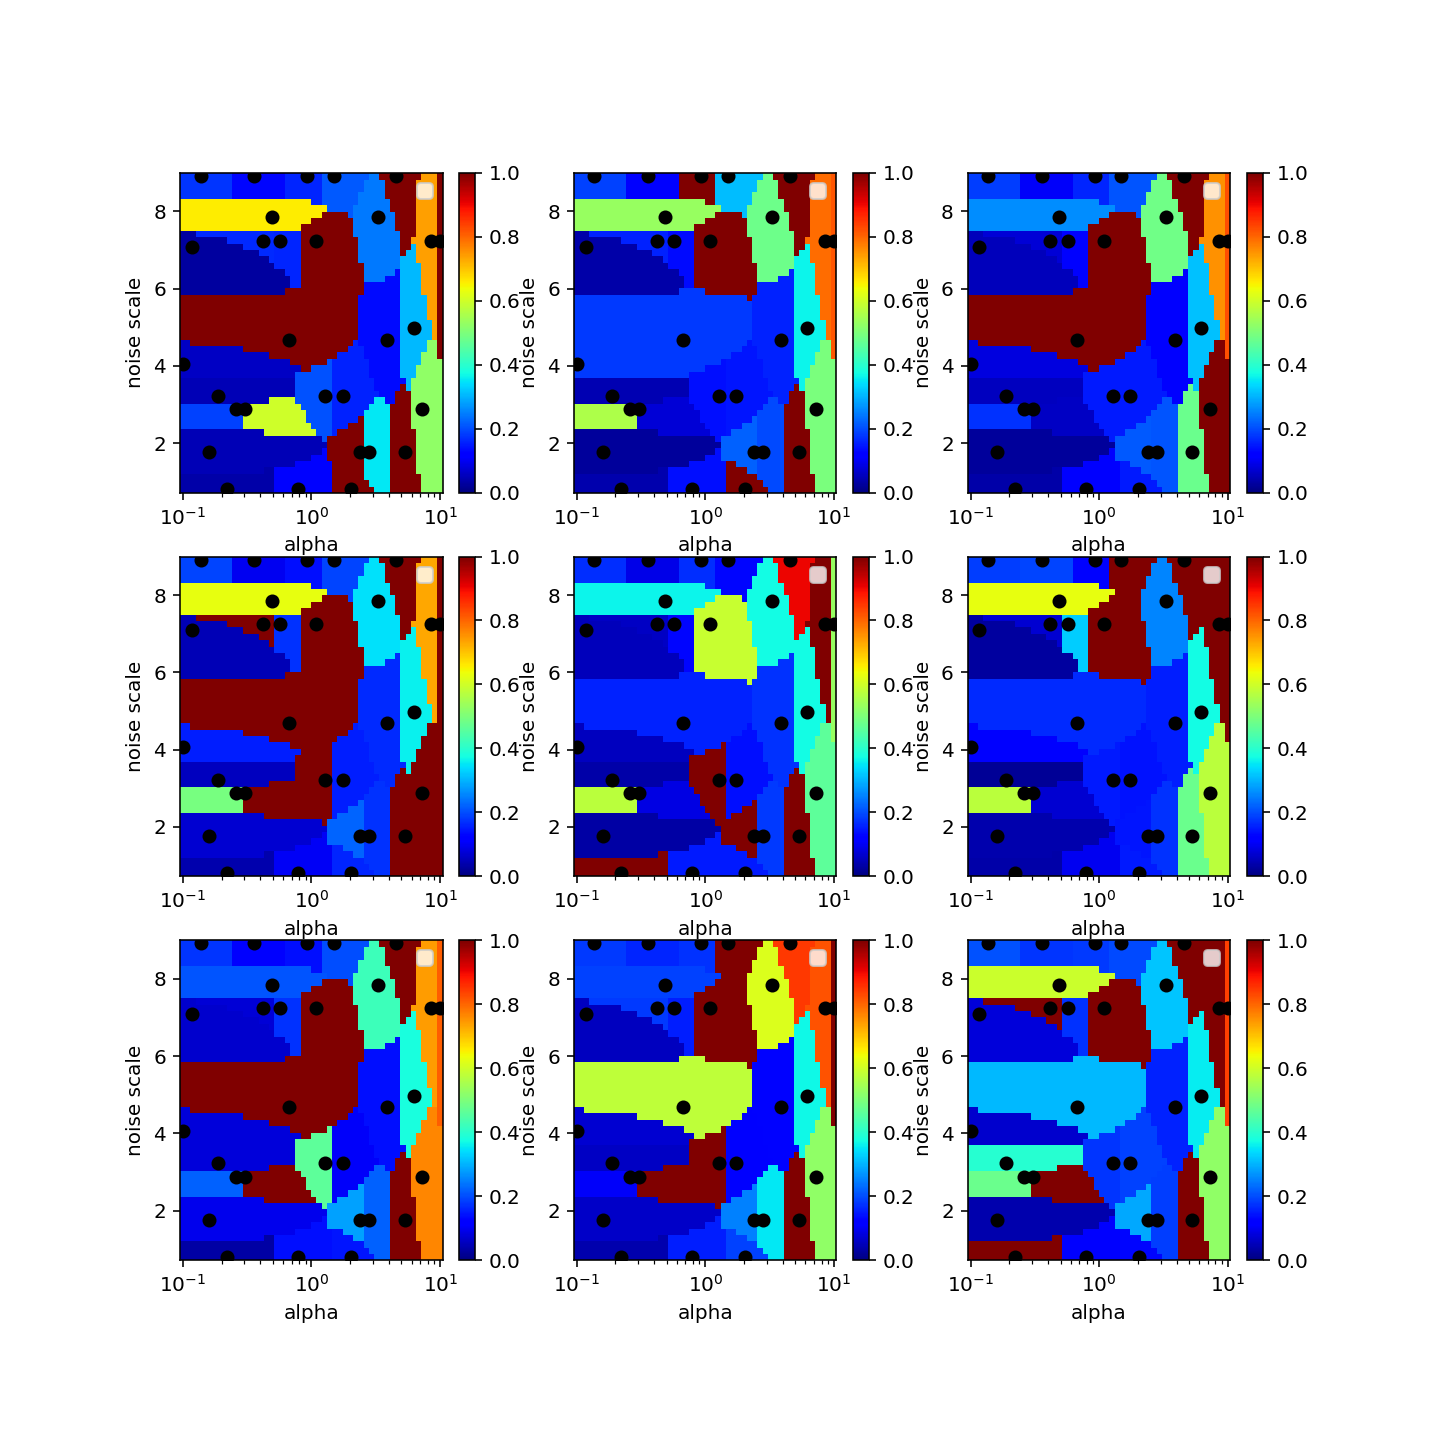

In [202]:
%matplotlib notebook
mpl.rcParams['figure.figsize'] =(10,10)
a, b = 3, 3

for i in range(9):
    plt.subplot(a, b, i + 1)
    plt_heatmap_alpha_noise(reruns[i])

In [207]:
%matplotlib notebook
[plt.plot(r[7]['log_likelihoods'][:]) for r in reruns]
#plt.semilogy()

<IPython.core.display.Javascript object>

[[<matplotlib.lines.Line2D at 0x7ff4fea7b0a0>],

<IPython.core.display.Javascript object>


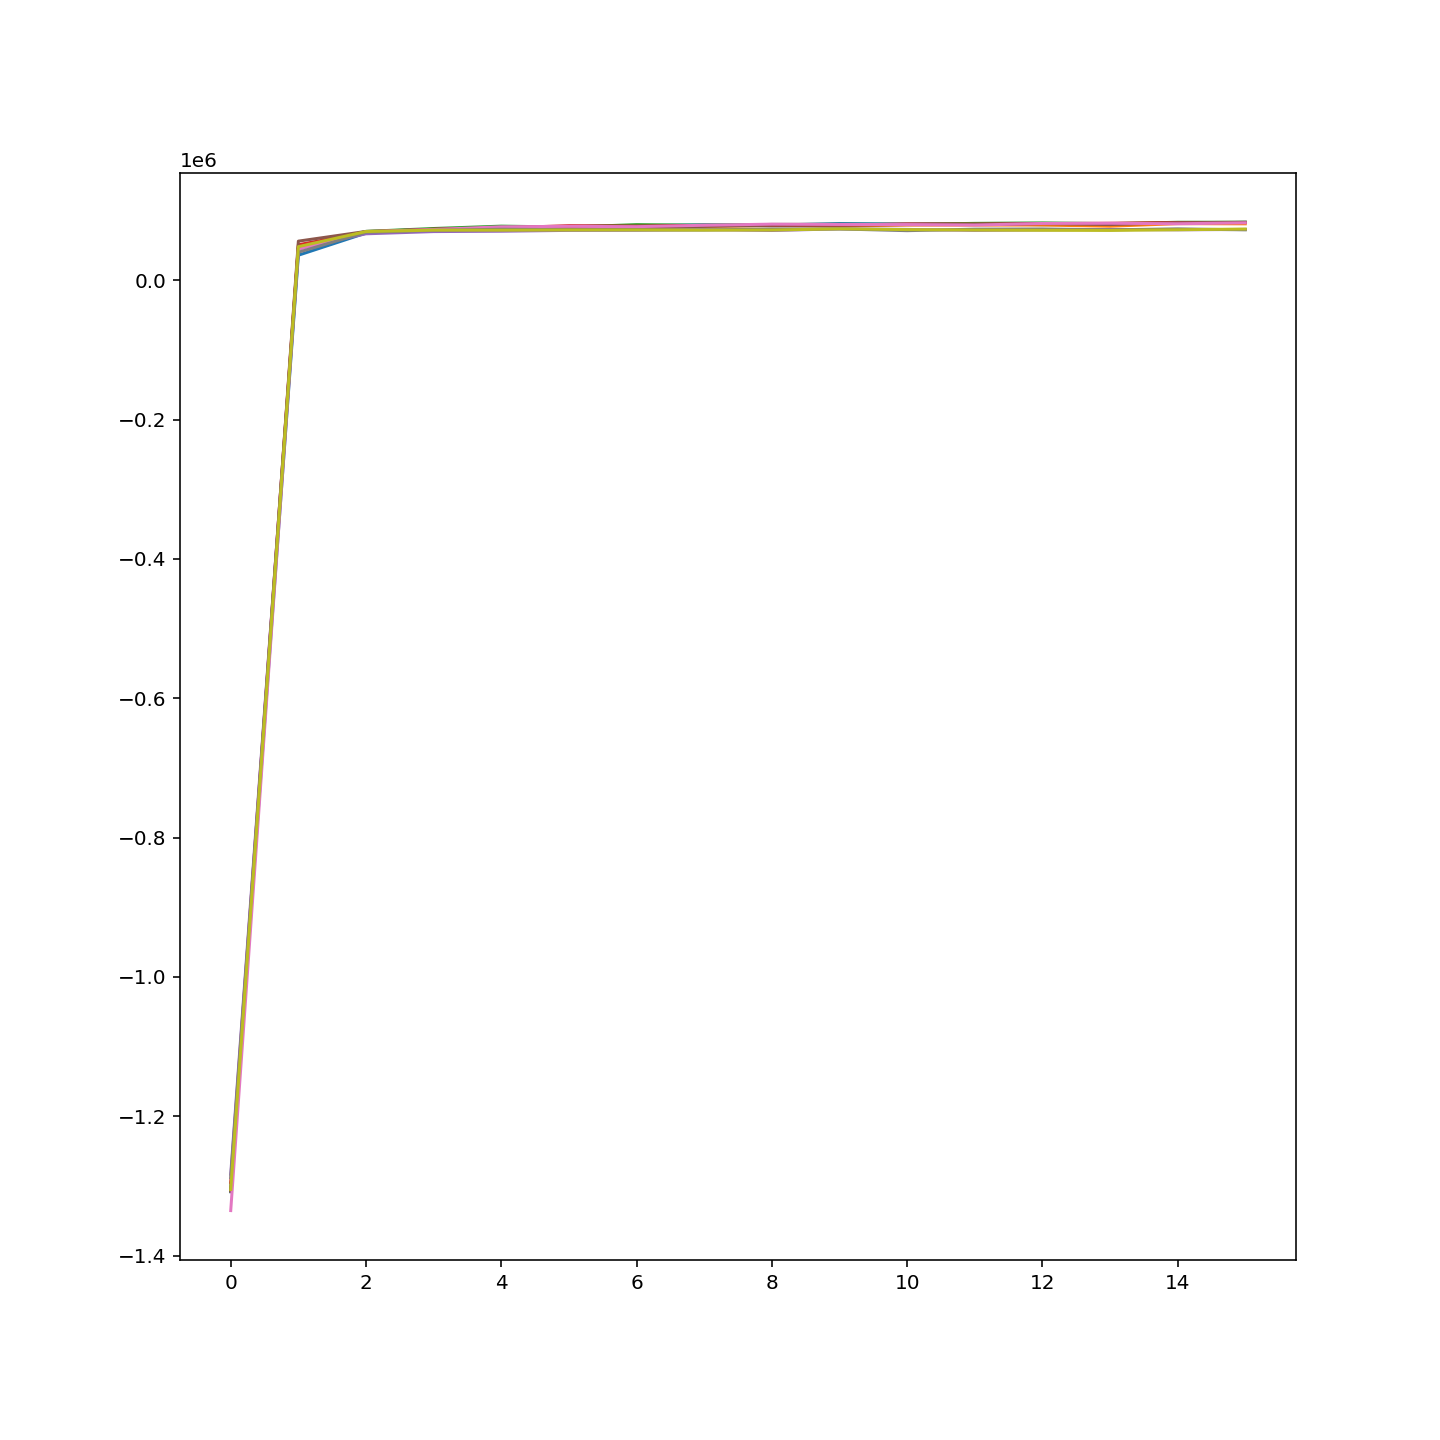

[[<matplotlib.lines.Line2D at 0x7fb67d1a0340>],

In [1889]:
[plt.plot(r[7]['log_likelihoods'][:]) for r in reruns]
#plt.semilogy()

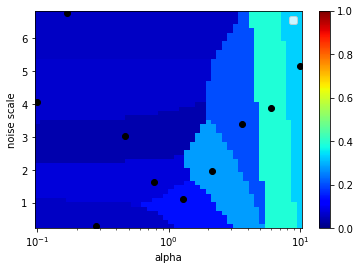

In [1913]:
%matplotlib inline
def score_run_loss(run, istart = 0, iend = 1600):
    """
    high score means better.
    """
    #return np.mean(run['losses'][:10]) - np.mean(run['losses'][-10:])
    #return -np.mean(run['losses'][istart:iend])
    #return (np.mean(run['log_likelihoods'][0]) - np.mean(run['log_likelihoods'][-1]))
    return np.mean(run['log_likelihoods'][:])

# def score_by_elbo(run, istart = 0, iend = 1600):
#     """
#     high score means better.
#     """
#     return -np.mean(run['losses'][0])

[append_scores(runs, score_run_loss, 'score') for runs in reruns]
best_run = select_best_runs(reruns)
plt_heatmap_alpha_noise(best_run)

In [220]:
len(res_noise[0]['log_likelihoods'])

16

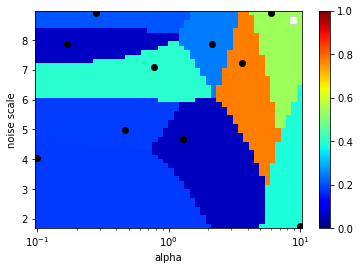

In [244]:
%matplotlib inline
def score_run_loss(run, istart = 0, iend = 1600):
    """
    high score means better.
    """
    #return np.mean(run['log_likelihoods'][:])
    #return np.mean(run['losses'][:10]) - np.mean(run['losses'][-10:])
    #return -np.mean(run['losses'][istart:iend])
    #return (np.mean(run['log_likelihoods'][0]) - np.mean(run['log_likelihoods'][-1]))
    return np.mean(run['log_likelihoods'][-8:])

# def score_by_elbo(run, istart = 0, iend = 1600):
#     """
#     high score means better.
#     """
#     return -np.mean(run['losses'][0])

[append_scores(runs, score_run_loss, 'score') for runs in reruns]
best_run = select_best_runs(reruns)
plt_heatmap_alpha_noise(best_run)

In [250]:
res_noise[0].keys(
)

dict_keys(['data', 'locs', 'samples', 'rms_locs', 'diff_locs', 'permutation', 'alpha', 'beta', 'components', 'latents', 'noise_scale', 'model', 'losses', 'init_loss', 'weighted_expectation', 'L_Omega', 'log_likelihoods', 'guide', 'posterior_locs'])

Text(0.5, 1.0, 'Variational Inference')

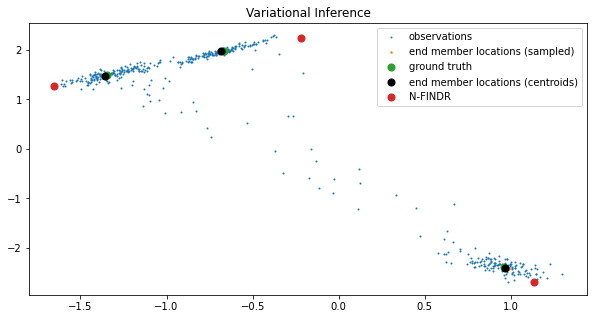

In [248]:
mpl.rcParams['figure.figsize'] =(10,5)

ploti2(res_noise, 0, save = False, xlim = None, ylim = None)
plt.title('Variational Inference')

Score by initial log likelihood (better?):

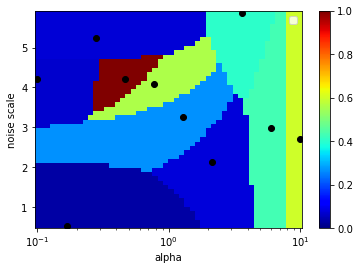

In [1633]:
[append_scores(runs, score_by_elbo, 'score') for runs in reruns]
best_run = select_best_runs(reruns)
plt_heatmap_alpha_noise(best_run)

MCMC

<IPython.core.display.Javascript object>


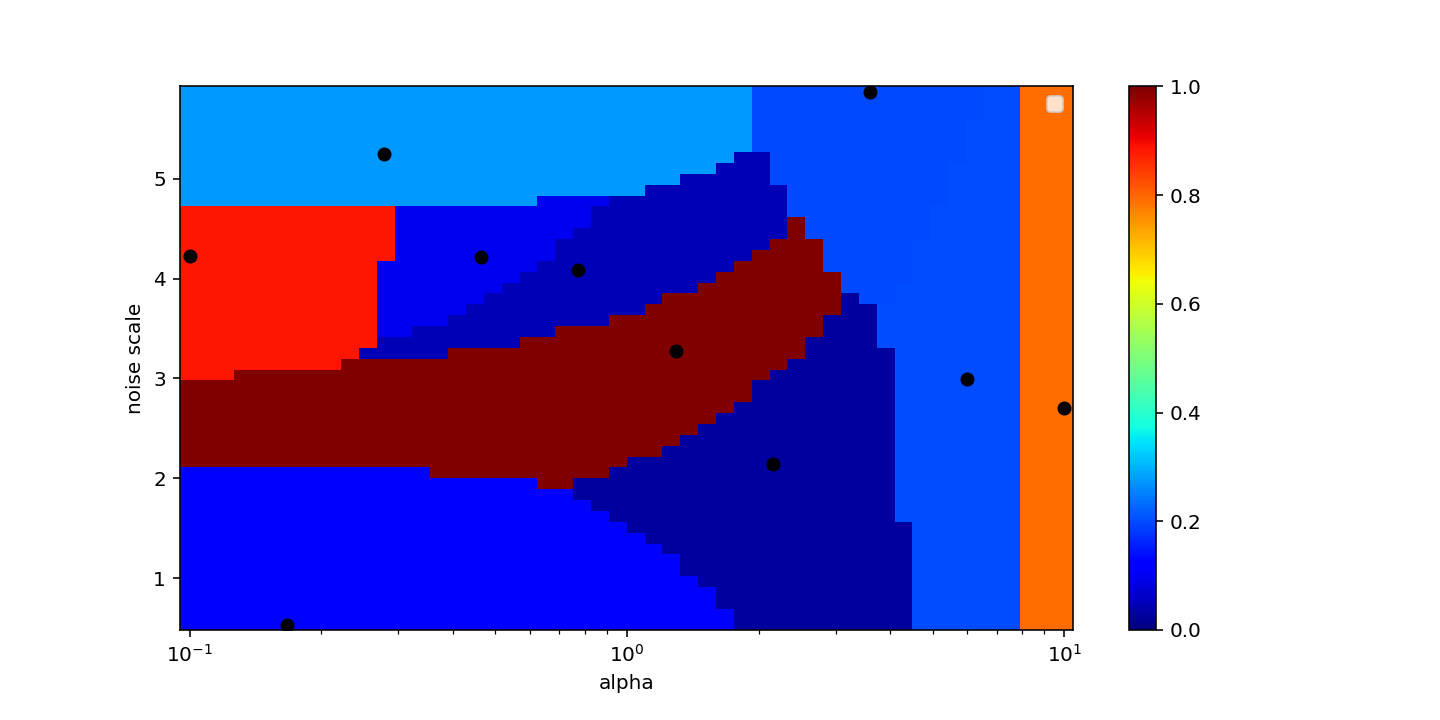

In [1020]:
plt_heatmap_alpha_noise(res_noise3)

<IPython.core.display.Javascript object>


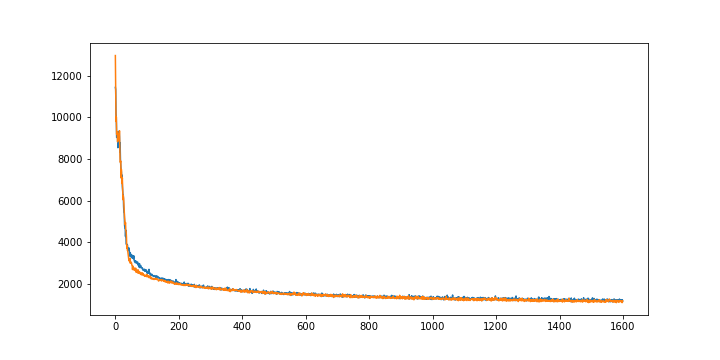

In [1017]:
%matplotlib notebook
i = 0
plt.plot(res_noise[i]['losses'][0:])
plt.plot(res_noise2[i]['losses'][0:])
#plt.semilogy()

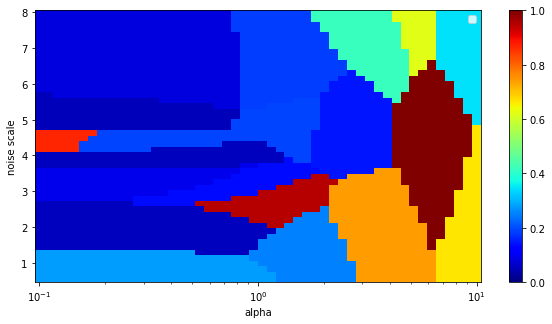

In [966]:
plt_heatmap_alpha_noise(res_noise)

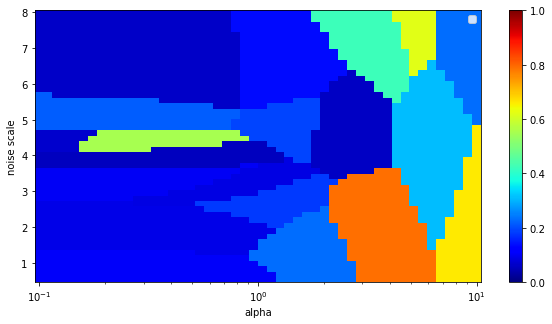

In [965]:
plt_heatmap_alpha_noise(res_noise2)

In [967]:
svi.loss(model, global_guide, data)

[{'data': tensor([[-4.2069e-02, -3.4727e-01],
          [-9.7143e-02, -2.2985e-01],
          [-1.4847e-01, -9.9071e-02],
          [ 3.4699e-02, -3.9779e-01],
          [-1.6775e-01, -3.8208e-01],
          [-3.1797e-01, -6.6696e-02],
          [-1.2277e-01, -2.7813e-01],
          [-1.8116e-01,  7.0383e-01],
          [-2.6317e-01,  9.1002e-01],
          [-2.5457e-01,  7.2756e-01],
          [-2.6210e-01, -3.5508e-01],
          [-1.3716e-01, -4.3660e-01],
          [-8.8224e-01,  5.3698e-01],
          [-2.4303e-01,  6.2498e-01],
          [-5.8432e-01,  1.7661e-01],
          [-3.7004e-02, -4.0216e-01],
          [-1.3190e-01, -3.2662e-01],
          [-6.1616e-01,  2.2319e-01],
          [-3.0708e-01,  1.4102e-01],
          [-2.3342e-01, -4.2160e-01],
          [-1.0705e-02, -4.1273e-01],
          [-1.1695e-01,  3.2086e-02],
          [-2.4969e-02, -2.9127e-01],
          [-7.7376e-02, -1.1934e-01],
          [-4.2559e-01,  6.5279e-01],
          [-3.9616e-02, -2.9249e-01],
    

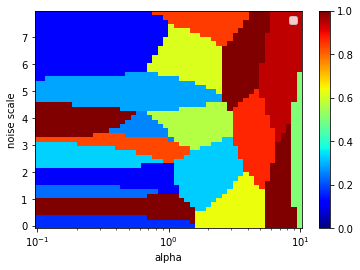

In [708]:
plt_heatmap_alpha_noise(res_noise)

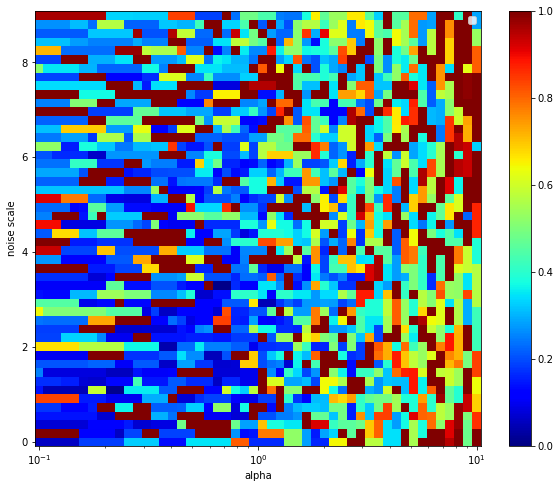

In [680]:
plt_heatmap_alpha_noise(res_noise)

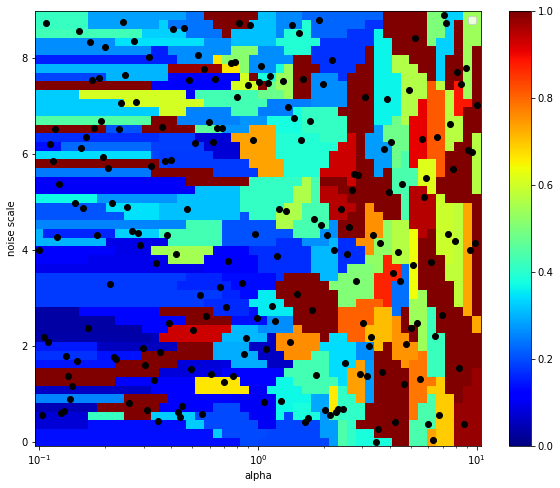

In [657]:
plt_heatmap_alpha_noise(res_noise)

In [530]:
%pdb

Automatic pdb calling has been turned ON


In [1122]:
def ff(i):
    return ploti2(res, i, save = False)
    return ploti2(res_noise, i, save = False, xlim = (-2, 2), ylim = (-2, 1))

#%matplotlib inline
vis.iplot(ff, res)

interactive(children=(IntSlider(value=2, description='i', max=4), Output(layout=Layout(height='550px'))), _dom…

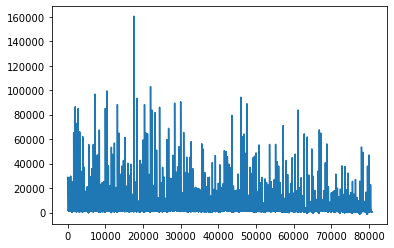

In [523]:
%matplotlib inline
plt.plot(losses)

In [ ]:
def ff(i):
    return plotnfindr(i, save = True)

seed = 3

res_noise = []
for nscale in noises:
    pyro.set_rng_seed(seed)
    we, locs, data = gen_data(N, alpha = 1, noise_scale= nscale, )
    res_noise.append({'we': we, 'data': data, 'locs': locs, 'alpha': a, 'beta': get_beta(*locs)})
    
%matplotlib inline
vis.iplot(ff, res_noise)

In [1389]:
gen_data()[0][1]

tensor([-0.0405,  0.0126])

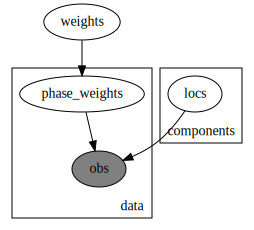

In [50]:
pyro.render_model(model, model_args=(data,))

standard GMM

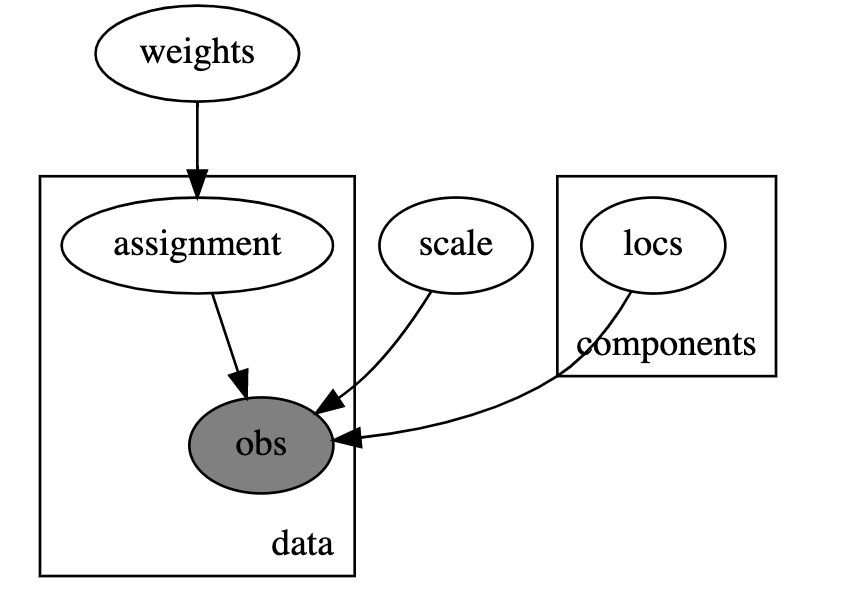

compositional GMM

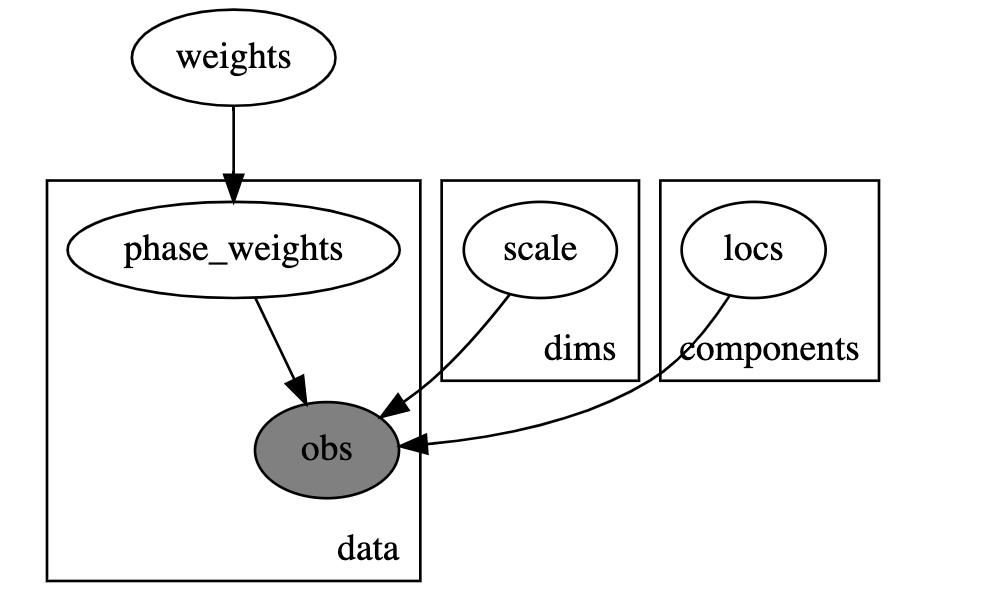

<AxesSubplot:>

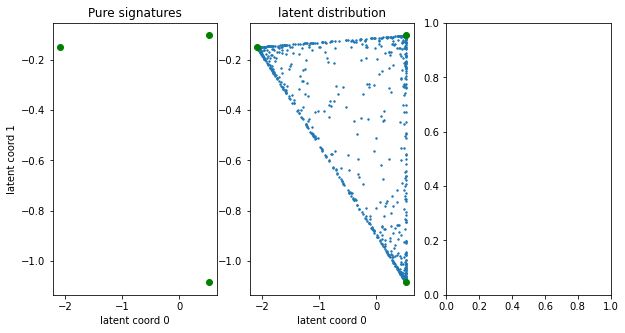

In [198]:
import matplotlib as mpl

mpl.rcParams['figure.figsize'] =(10,5)
alpha = 1

pyro.set_rng_seed(14)

we, loc, dat  = gen_data(1000, alpha = .5)
a, b = 1, 3

plt.subplot(a, b, 1)
plt.xlabel('latent coord 0')
plt.ylabel('latent coord 1')
plt.scatter(*loc.T, c = 'green')
plt.title('Pure signatures')

plt.subplot(a, b, 2)
plt.xlabel('latent coord 0')
plt.scatter(*we.T, s = 2)
plt.scatter(*loc.T, c = 'green')
plt.title('latent distribution')

plt.subplot(a, b, 3)
# plt.xlabel('latent coord 0')
# plt.scatter(*dat.T, s = 2)
# plt.scatter(*loc.T, c = 'green')
# plt.title('observations')

Text(0.5, 1.0, 'observations')

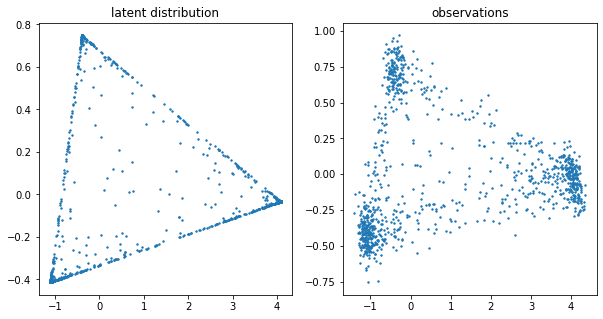

In [297]:
# TODO it's possible (though I think unlikely, because qualitative results are the same)
# that the refactor of gen_data changed its behavior
import matplotlib as mpl

mpl.rcParams['figure.figsize'] =(10,5)
alpha = 1

pyro.set_rng_seed(15)

we, _, dat = gen_data(1000, noise_scale=.01)
a, b = 1, 2
plt.subplot(a, b, 1)
plt.scatter(*we.T, s = 2)
plt.title('latent distribution')

plt.subplot(a, b, 2)
plt.scatter(*dat.T, s = 2)
plt.title('observations')

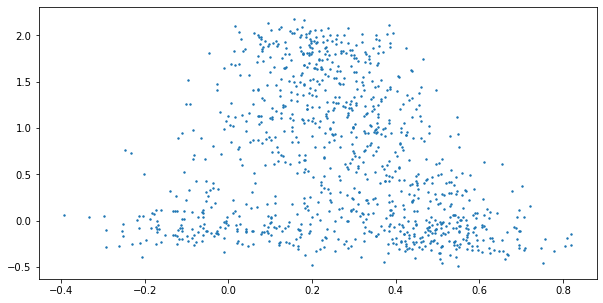

In [98]:
plt.scatter(*data.T, s = 2)
#plt.scatter(*local_weights[:, :2].T, s = 1)

In [25]:
%pdb

Automatic pdb calling has been turned OFF


## MCMC

Next we'll explore the full posterior over component parameters using collapsed NUTS, i.e. we'll use NUTS and marginalize out all discrete latent variables.

In [162]:
num_samples = 50


from pyro.infer.mcmc.api import MCMC
from pyro.infer.mcmc import NUTS
pyro.set_rng_seed(3)
kernel = NUTS(model)
mcmc = MCMC(kernel, num_samples=num_samples, warmup_steps=50)
mcmc.run(data)
posterior_samples = mcmc.get_samples()

Sample: 100%|██████████| 100/100 [01:27,  1.14it/s, step size=3.42e-02, acc. prob=0.042]


In [163]:
components = [posterior_samples["locs"][:, i, :] for i in range(T)]

<IPython.core.display.Javascript object>


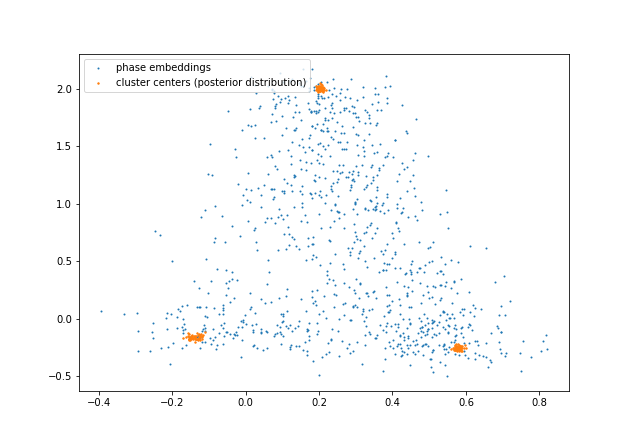

(tensor([0.2671, 0.0989, 0.6340]), tensor([0.3778, 0.3744, 0.2477]))

In [109]:
%matplotlib notebook

plt.scatter(*(data).T, s = 1, label = 'phase embeddings')
plt.scatter(*torch.vstack(components).T, s = 2, label = 'cluster centers (posterior distribution)')
#plt.scatter(*locs.T, label = 'cluster centers (ground truth)')
plt.legend(loc = 'upper left')
#plt.scatter(*np.array(local_weights[:, :2].T), s = 1)

weights, posterior_samples["weights"].mean(axis = 0)

In [45]:
%matplotlib notebook

plt.scatter(*(data).T, s = 1, label = 'phase embeddings')
plt.scatter(*torch.vstack(components).T, s = 2, label = 'cluster centers (inferred posterior distribution)')
plt.scatter(*locs.T, label = 'cluster centers (ground truth)')
plt.legend()
#plt.scatter(*np.array(local_weights[:, :2].T), s = 1)

weights, posterior_samples["weights"].mean(axis = 0)

<IPython.core.display.Javascript object>

(tensor([0.2671, 0.0989, 0.6340]), tensor([0.2834, 0.2218, 0.4948]))

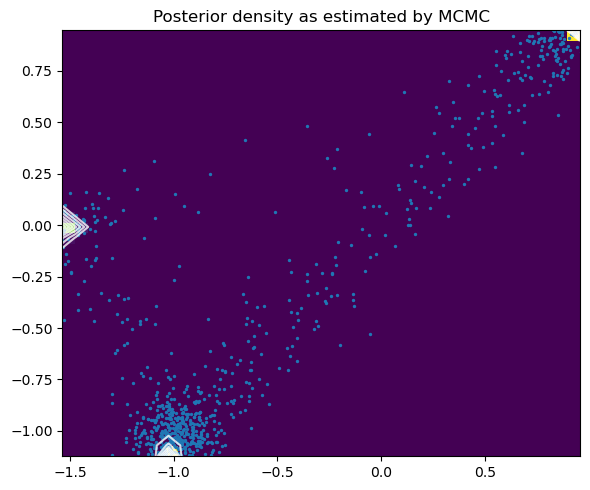

In [63]:
%matplotlib inline

# plt.scatter(*(data).T, s = 1, label = 'phase embeddings')
# plt.scatter(*torch.vstack(components).T, s = 2, label = 'cluster centers (inferred posterior distribution)')
# plt.scatter(*locs.T, label = 'cluster centers (ground truth)')
# plt.legend()
# #plt.scatter(*np.array(local_weights[:, :2].T), s = 1)

# weights, posterior_samples["weights"].mean(axis = 0)


pyplot.figure(figsize=(6, 5), dpi=100).set_facecolor('white')

#XX, YY = components[i].T
XX, YY = torch.vstack(components).T
h, xs, ys, image = pyplot.hist2d(XX.numpy(), YY.numpy(), bins=[40, 40])
pyplot.contour(np.log(h + 3).T, extent=[xs.min(), xs.max(), ys.min(), ys.max()],
               colors='white', alpha=0.8)
pyplot.title('Posterior density as estimated by MCMC')

plt.scatter(*np.array(data.T), s = 2)

pyplot.tight_layout()

Note that due to nonidentifiability of the mixture components the likelihood landscape has two equally likely modes, near `(11,0.5)` and `(0.5,11)`. NUTS has difficulty switching between the two modes.

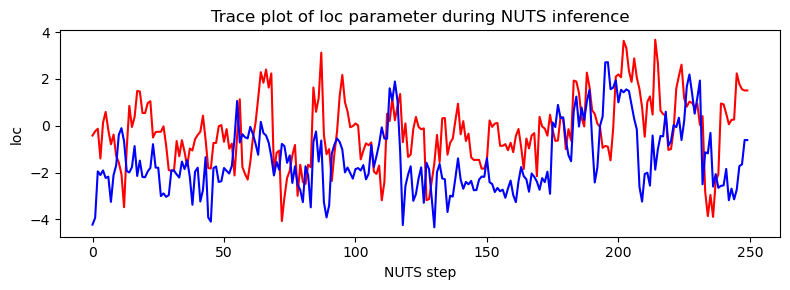

In [115]:
pyplot.figure(figsize=(8, 3), dpi=100).set_facecolor('white')
pyplot.plot(XX.numpy(), color='red')
pyplot.plot(YY.numpy(), color='blue')
pyplot.xlabel('NUTS step')
pyplot.ylabel('loc')
pyplot.title('Trace plot of loc parameter during NUTS inference')
pyplot.tight_layout()

In [460]:
import matplotlib as mpl

N = 1000

mpl.rcParams['figure.figsize'] =(10,5)


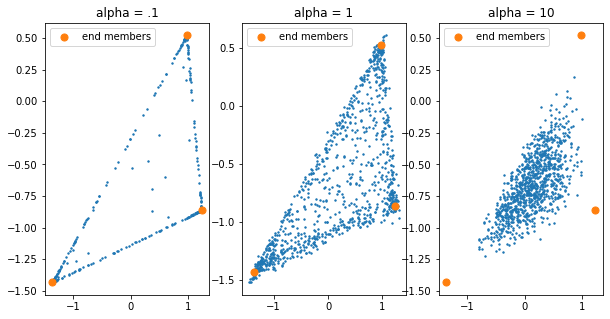

In [101]:
N = 1000

pyro.set_rng_seed(3)
we, locs, data = gen_data(N, alpha = .1, noise_scale=.2)

a, b = 1, 3
plt.subplot(a, b, 1)
plt.scatter(*we.T, s = 2)
plt.scatter(*(locs.T), s = 50, label = 'end members')
plt.title('alpha = .1')
plt.legend()

pyro.set_rng_seed(3)
we, locs, data = gen_data(N, alpha = 1, noise_scale=.2)

plt.subplot(a, b, 2)
plt.scatter(*data.T, s = 2)
plt.scatter(*(locs.T), s = 50, label = 'end members')
plt.title('alpha = 1')
plt.legend()

pyro.set_rng_seed(3)
we, locs, data = gen_data(N, alpha = 10, noise_scale=.2)

plt.subplot(a, b, 3)
plt.scatter(*data.T, s = 2)
plt.scatter(*(locs.T), s = 50, label = 'end members')
# plt.scatter(*(nfindr_locs(data).T), s = 50, label = 'N-FINDR')
plt.title('alpha = 10')
plt.legend()

## High concentration:

In [ ]:
mark

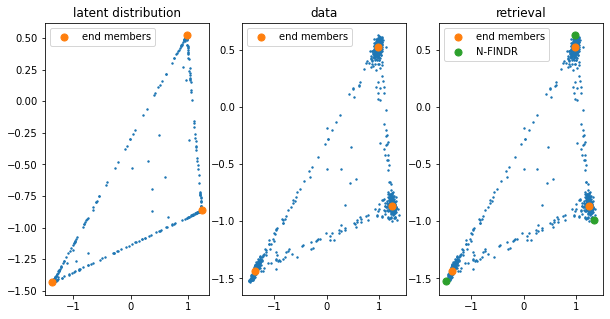

In [102]:
N = 1000

pyro.set_rng_seed(3)

alpha = .1

we, locs, data = gen_data(N, alpha = alpha, noise_scale=.2)

a, b = 1, 3
plt.subplot(a, b, 1)
plt.scatter(*we.T, s = 2)
plt.scatter(*(locs.T), s = 50, label = 'end members')
plt.title('latent distribution')
plt.legend()

plt.subplot(a, b, 2)
plt.scatter(*data.T, s = 2)
plt.scatter(*(locs.T), s = 50, label = 'end members')
plt.title('data')
plt.legend()

plt.subplot(a, b, 3)
plt.scatter(*data.T, s = 2)
plt.scatter(*(locs.T), s = 50, label = 'end members')
plt.scatter(*(nfindr_locs(data).T), s = 50, label = 'N-FINDR')
plt.title('retrieval')
plt.legend()

## Low concentration:

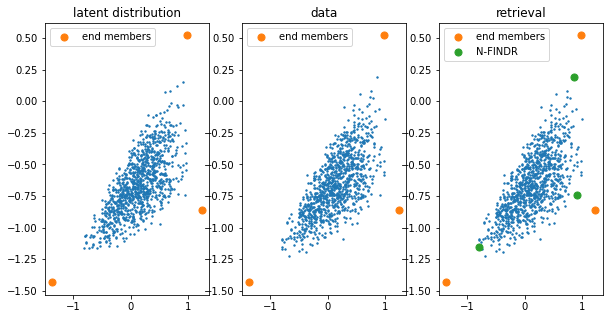

In [103]:
N = 1000

pyro.set_rng_seed(3)

alpha = 10

we, locs, data = gen_data(N, alpha=alpha, noise_scale = .2)

a, b = 1, 3
plt.subplot(a, b, 1)
plt.scatter(*we.T, s = 2)
plt.scatter(*(locs.T), s = 50, label = 'end members')
plt.title('latent distribution')
plt.legend()

plt.subplot(a, b, 2)
plt.scatter(*data.T, s = 2)
plt.scatter(*(locs.T), s = 50, label = 'end members')
plt.title('data')
plt.legend()

plt.subplot(a, b, 3)
plt.scatter(*data.T, s = 2)
plt.scatter(*(locs.T), s = 50, label = 'end members')
plt.scatter(*(nfindr_locs(data).T), s = 50, label = 'N-FINDR')
plt.title('retrieval')
plt.legend()

### Low concentration, high noise

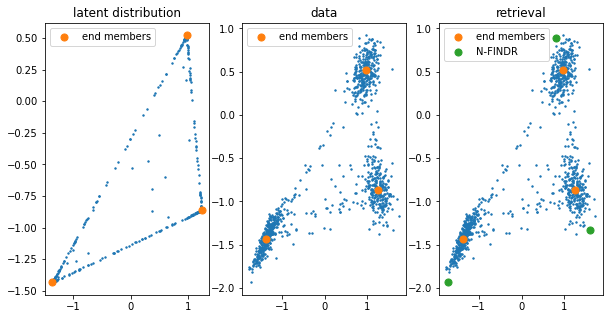

In [124]:
N = 1000

pyro.set_rng_seed(3)

alpha = .1

we, locs, data = gen_data(N, alpha = alpha, noise_scale=3)

a, b = 1, 3
plt.subplot(a, b, 1)
plt.scatter(*we.T, s = 2)
plt.scatter(*(locs.T), s = 50, label = 'end members')
plt.title('latent distribution')
plt.legend()

plt.subplot(a, b, 2)
plt.scatter(*data.T, s = 2)
plt.scatter(*(locs.T), s = 50, label = 'end members')
plt.title('data')
plt.legend()

plt.subplot(a, b, 3)
plt.scatter(*data.T, s = 2)
plt.scatter(*(locs.T), s = 50, label = 'end members')
plt.scatter(*(nfindr_locs(data).T), s = 50, label = 'N-FINDR')
plt.title('retrieval')
plt.legend()

In [ ]:
mark2

In [153]:
%matplotlib inline
mpl.rcParams['figure.figsize'] =(10,8)


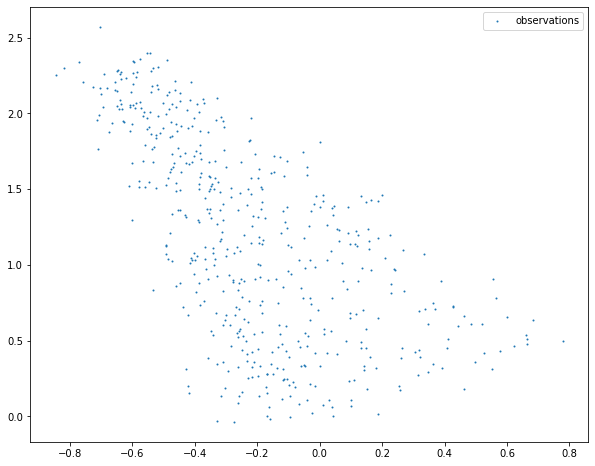

In [157]:
i = 130
data, components, locs = res[i]['data'], res[i]['components'], res[i]['locs']

plt.scatter(*(data).T, s = 1, label = 'observations')
# plt.scatter(*(locs.T), s = 50, label = 'ground truth')
# plt.scatter(*torch.vstack(components).T, s = 2, label = 'cluster centers (posterior samples)')
# plt.scatter(*(nfindr_locs(data).T), s = 50, label = 'N-FINDR')

#plt.scatter(*locs.T, label = 'cluster centers (ground truth)')
plt.legend()#loc = 'upper left')
#plt.scatter(*np.array(local_weights[:, :2].T), s = 1)


In [229]:
alpha = 1

def f(*args):
    return model(*args, scale = .01)

kernel = NUTS(f)
mcmc = MCMC(kernel, num_samples=num_samples, warmup_steps=50)
mcmc.run(data2)
posterior_samples = mcmc.get_samples()

components = [posterior_samples["locs"][:, i, :] for i in range(T)]

Sample: 100%|██████████| 100/100 [01:54,  1.15s/it, step size=2.49e-02, acc. prob=0.952]


In [ ]:
components = [posterior_samples["locs"][:, i, :] for i in range(T)]

In [466]:
posterior_samples["locs"].swapaxes(0, 1)

torch.Size([3, 50, 2])

In [464]:
posterior_samples["locs"]

torch.Size([50, 3, 2])

<IPython.core.display.Javascript object>


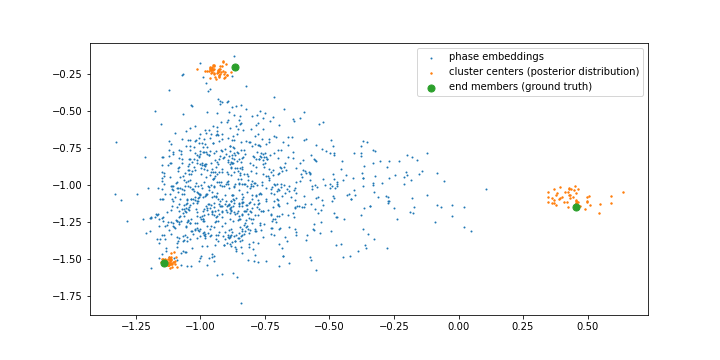

(tensor([0.2671, 0.0989, 0.6340]), tensor([0.3302, 0.5220, 0.1478]))

In [216]:
%matplotlib notebook

plt.scatter(*(data2).T, s = 1, label = 'phase embeddings')
plt.scatter(*torch.vstack(components).T, s = 2, label = 'cluster centers (posterior distribution)')
plt.scatter(*(locs.T), s = 50, label = 'end members (ground truth)')

#plt.scatter(*locs.T, label = 'cluster centers (ground truth)')
plt.legend(loc = 'upper right')
#plt.scatter(*np.array(local_weights[:, :2].T), s = 1)

weights, posterior_samples["weights"].mean(axis = 0)

## Workflow week of 4/17

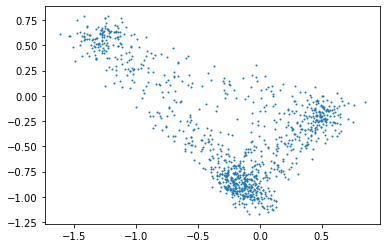

In [8]:
N = 1000

# mpl.rcParams['figure.figsize'] =(10,5)
alpha = .5

we, locs, data = gen_data(N)

plt.scatter(*(data).T, s = 1, label = 'phase embeddings')


In [1555]:
pwd

'/home/ollie/Documents/scratch/xrd_clustering/notebooks'

In [251]:
def rms(arr):
    arr = np.array(arr)
    return np.sqrt((arr**2).sum() / len(arr))

def loc_stds(component_locs):
    return np.sqrt((component_locs.std(axis = 0)**2).sum() / component_locs.shape[1])

def loc_means(component_locs):
    return component_locs.mean(axis = 0)

alpha = 1
num_samples = 50
N = 500

# mpl.rcParams['figure.figsize'] =(10,5)
#alpha = .5
pyro.set_rng_seed(3)

def closest_permutation_diffs(locs_posterior_means, locs):
    # Figure out mapping from ground truth end members to inferred end members
    clust_permutations = list(permutations(np.arange(T), r = T))
    permutation_norms = [np.linalg.norm(locs_posterior_means[ci_permute, :] - np.array(locs))
                         for ci_permute in clust_permutations]
    best_permutation = clust_permutations[np.argmin(permutation_norms)]

    locs_diffs = locs_posterior_means[best_permutation, :] - np.array(locs)
    return locs_diffs

def get_beta(va, vb, vc, norm = True):
    # area of the simplex drawn by the endmember coordinates, relative to that of the regular simplex
    vmean = reduce(lambda a, b: a + np.linalg.norm(b),
                   [vb - va, vc - vb, va - vc], 0) / 3
    ref_area = np.sqrt(3) * vmean**2 / 4 # area of equal-surface regular simplex
    beta = np.abs(np.cross((vb - va), (vc - va)))
    if norm:
        beta /= (2 * ref_area)
    return beta

def mcmc_posterior(data, num_samples, N, alpha, noise_scale = .01):
    def f(*args):
        return model(*args, scale = noise_scale, alpha = alpha, N = N)

    kernel = NUTS(f)
    mcmc = MCMC(kernel, num_samples=num_samples, warmup_steps=50)
    mcmc.run(data)
    posterior_samples = mcmc.get_samples()
    return posterior_samples, f, [None]


class Run(object):
    """
    If datadict is provided, use it as a sample set. Otherwise generate observations using the given
    alpha, noise_scale and N
    """
    def __init__(self, alpha, datadict = None, num_samples = 100, N = 500, noise_scale = .01,
                inference_posterior_fn = mcmc_posterior, inference_seed = None,
                infer_noise_scale = .01, n_warmup = 0):
    # set this if you want the same cluster params independent of alpha
    #pyro.set_rng_seed(3)
    
    # TODO noise_scale hyperparameter tuning?
        if datadict is None:
            we, locs, data = gen_data(N, alpha = alpha, noise_scale = noise_scale)
        else:
            we, locs, data = datadict['latents'], datadict['locs'], datadict['data']
        
        self.we = we
        self.locs = locs
        self.data = data
        self.num_samples = num_samples
        self.N = N
        self.alpha = alpha
        self.inference_seed = inference_seed
        self.noise_scale = noise_scale
        self.infer_noise_scale = infer_noise_scale
        self.inference_posterior_fn = inference_posterior_fn
        
        if inference_seed is not None:
            pyro.set_rng_seed(inference_seed)
            
        self.warmup(n_iter = n_warmup)
        pyro.clear_param_store()

    def get_loglikelihood(self, num_samples = 50, set_seed = True):
#         if set_seed:
#             if self.inference_seed is not None:
#                 pyro.set_rng_seed(self.inference_seed)
        return get_log_likelihood(self.inference_output['model'],
                                  #None,
                                  self.inference_output['guide'],
                                  self.data,
                                  num_samples = num_samples)

    def warmup(self, n_iter = 1600,
           inference_posterior_fn = mcmc_posterior):
        # TODO setting noise_scale hyperparameter
        self.inference_output = self.inference_posterior_fn(self.data, self.num_samples, self.N,
                                                self.alpha, noise_scale = self.infer_noise_scale,
                                                n_iter = n_iter, seed = self.inference_seed,
                                                n_likelihood_samples = num_samples)
        return self

    def run(self, n_iter = 1600):
        if self.inference_seed is not None:
            pyro.set_rng_seed(self.inference_seed)
            
        self.warmup(n_iter = n_iter)
#         return inference_output

#     def test_seed_likelihood(self, seed):
#         def initialize(seed, *args, **kwargs):
#     global global_guide, svi, prior_sample
#     pyro.set_rng_seed(seed + 1000) # add offset to avoid collision with other places where we're setting the seed
#     #prior_sample = init()
#     pyro.clear_param_store()
    
# #     we, locs, data = gen_data(N, alpha = alpha, noise_scale = noise_scale)
    
#     vi_init = Run(*args, n_iter = 0, **kwargs).inference_output
# #     vi_inference(data, num_samples, N, alpha, n_iter = n_iter, noise_scale = .01,
# #                 n_likelihood_samples = 400)

#     def postprocess(self):
        # TODO cleanup
        we = self.we  
        locs = self.locs  
        data = self.data  
        inference_output = self.inference_output  

        posterior_samples = inference_output['predictive']
        wrapped_model = inference_output['model']
        losses = inference_output['losses']

        components = [posterior_samples["locs"][:, i, :] for i in range(T)]

        posterior_locs = np.array(posterior_samples["locs"])
        locs_posterior_means = np.vstack([loc_means(posterior_locs[:, i, :]) for i in range(posterior_locs.shape[1])])

        # TODO generalize
        va, vb, vc = locs
        beta = get_beta(va, vb, vc)

        rms_locs = rms([loc_stds(posterior_locs[:, i, :]) for i in range(posterior_locs.shape[1])])

        # TODO refactor
        # Figure out mapping from ground truth end members to inferred end members
        clust_permutations = list(permutations(np.arange(T), r = T))
        permutation_norms = [np.linalg.norm(locs_posterior_means[ci_permute, :] - np.array(locs))
                             for ci_permute in clust_permutations]
        best_permutation = clust_permutations[np.argmin(permutation_norms)]

        locs_diffs = locs_posterior_means[best_permutation, :] - np.array(locs)
        
        # reshuffle random seed 
        pyro.set_rng_seed(np.random.randint(1e9))

        # merge with the posterior samples dictionary, instead of extracting sites
        # individually
        result_dict = {'data': data, 'locs': locs, 'samples': posterior_samples, 'rms_locs': rms_locs,
                       'diff_locs': locs_diffs, 'permutation': best_permutation, 'alpha': alpha, 'beta': beta,
                      'components': components, 'latents': we, 'noise_scale': self.noise_scale,
                      'model': wrapped_model, 'losses': losses, 'init_loss': losses[0],
                      'weighted_expectation': posterior_samples['weighted_expectation'],
                      'L_Omega': posterior_samples['L_Omega'],
                      'log_likelihoods': inference_output['log_likelihoods'],
                      'guide': guide, 'posterior_locs': posterior_locs,
                      'inference_output': inference_output}
        
        return result_dict

# def run_instance(alpha, datadict = None, num_samples = 50, N = 500, noise_scale = .01,
#                 inference_posterior_fn = mcmc_posterior, n_iter = 1600):
#     """
#     If datadict is provided, use it as a sample set. Otherwise generate observations using the given
#     alpha, noise_scale and N
#     """
#     # set this if you want the same cluster params independent of alpha
#     #pyro.set_rng_seed(3)
    
#     # TODO noise_scale hyperparameter tuning?
#     if datadict is None:
#         we, locs, data = gen_data(N, alpha = alpha, noise_scale = noise_scale)
#     else:
#         we, locs, data = datadict['latents'], datadict['locs'], datadict['data']
    
#     # TODO setting noise_scale hyperparameter
#     inference_output = inference_posterior_fn(data, num_samples, N, alpha, noise_scale = .01,
#                                              n_iter = n_iter)
    
    
#     posterior_samples = inference_output['predictive']
#     wrapped_model = inference_output['model']
#     losses = inference_output['losses']

#     components = [posterior_samples["locs"][:, i, :] for i in range(T)]

#     posterior_locs = np.array(posterior_samples["locs"])
#     locs_posterior_means = np.vstack([loc_means(posterior_locs[:, i, :]) for i in range(posterior_locs.shape[1])])

#     # TODO generalize
#     va, vb, vc = locs
#     beta = get_beta(va, vb, vc)

#     rms_locs = rms([loc_stds(posterior_locs[:, i, :]) for i in range(posterior_locs.shape[1])])

#     # TODO refactor
#     # Figure out mapping from ground truth end members to inferred end members
#     clust_permutations = list(permutations(np.arange(T), r = T))
#     permutation_norms = [np.linalg.norm(locs_posterior_means[ci_permute, :] - np.array(locs))
#                          for ci_permute in clust_permutations]
#     best_permutation = clust_permutations[np.argmin(permutation_norms)]

#     locs_diffs = locs_posterior_means[best_permutation, :] - np.array(locs)

#     # merge with the posterior samples dictionary, instead of extracting sites
#     # individually
#     result_dict = {'data': data, 'locs': locs, 'samples': posterior_samples, 'rms_locs': rms_locs,
#                    'diff_locs': locs_diffs, 'permutation': best_permutation, 'alpha': alpha, 'beta': beta,
#                   'components': components, 'latents': we, 'noise_scale': noise_scale,
#                   'model': wrapped_model, 'losses': losses, 'init_loss': losses[0],
#                   'weighted_expectation': posterior_samples['weighted_expectation'],
#                   'L_Omega': posterior_samples['L_Omega'],
#                   'log_likelihoods': inference_output['log_likelihoods'],
#                   'guide': guide}
    
#     return result_dict

# def run_instance_general(alpha, datadict = None, num_samples = 50, N = 500, noise_scale = .01,
#                 inference_posterior_fn = mcmc_posterior):
#     """
#     If datadict is provided, use it as observations. Otherwise generate using the given
#     alpha, noise_scale and N
#     """
#     # set this if you want the same cluster params independent of alpha
#     #pyro.set_rng_seed(3)

#     if datadict is None:
#         we, locs, data = gen_data(N, alpha = alpha, noise_scale = noise_scale)
#     else:
#         we, locs, data = datadict['latents'], datadict['locs'], datadict['data']
    
#     posterior_samples = inference_posterior_fn(data, num_samples, N)

#     components = [posterior_samples["locs"][:, i, :] for i in range(T)]

#     posterior_locs = np.array(posterior_samples["locs"])
#     locs_posterior_means = np.vstack([loc_means(posterior_locs[:, i, :]) for i in range(posterior_locs.shape[1])])

# #     # TODO generalize
# #     va, vb, vc = locs
# #     beta = get_beta(va, vb, vc)

#     rms_locs = rms([loc_stds(posterior_locs[:, i, :]) for i in range(posterior_locs.shape[1])])

# #     # TODO refactor
# #     # Figure out mapping from ground truth end members to inferred end members
# #     clust_permutations = list(permutations(np.arange(T), r = T))
# #     permutation_norms = [np.linalg.norm(locs_posterior_means[ci_permute, :] - np.array(locs))
# #                          for ci_permute in clust_permutations]
# #     best_permutation = clust_permutations[np.argmin(permutation_norms)]

#     locs_diffs = locs_posterior_means - np.array(locs)

#     result_dict = {'data': data, 'locs': locs, 'samples': posterior_samples, 'rms_locs': rms_locs,
#                    'diff_locs': locs_diffs, 'alpha': alpha, 
#                   'components': components, 'latents': we, 'noise_scale': noise_scale}
#     return result_dict


def nfindr_locs(data):
    data = np.array(data).copy()
    data = np.array(data)[:, None, :]
    #print(data.shape)
    nfindr = eea.NFINDR()
    U = nfindr.extract(data, T, maxit = 1500, normalize=False, ATGP_init=False)
    return U

def score_nfindr(elt):
    """
    Get end members using nfindr and return the endmember coordinate errors
    """
#     posterior_samples = elt['samples']
    locs = elt['locs']
    data = elt['data']
    
    for _ in range(1000):
        try:
            #U = nfindr_locs(data)
            U = get_max(nfindr_locs, lambda inp: get_beta(*inp, norm=False), data)
            break
        except ValueError:
            pass
    return closest_permutation_diffs(U, locs)

def plotnfindr(i, save = False, xlim = None, ylim = None):
    U= get_max(nfindr_locs, lambda inp: get_beta(*inp, norm = False), res_noise[i]['data'])
    #U = nfindr_locs(res_noise[i]['data'])
    plt.scatter(*(res_noise[i]['data']).T, s = 1, label = 'phase embeddings')
    plt.scatter(*(res_noise[i]['locs'].T), s = 50, label = 'end members (ground truth)')
    plt.scatter(*U.T, label = 'nfindr')

    plt.legend(loc = 'upper left')
    #plt.title('alpha = {:.2f}; beta = {:.2f}'.format(alphas[i], betas[i]))
    if xlim:
        plt.xlim(xlim)
    if ylim:
        plt.ylim(ylim)
    if save:
        plt.savefig('data/figs/{}.png'.format(i))
    
def get_max(f, metric, *args, attempts = 1):
    res = []
    for _ in range(attempts):
        out = f(*args)
        score = metric(out)
        res.append((score, out))
#     print(res)
#     print(sorted(res))
    best = sorted(res, key = lambda tup: tup[0])[-1]
    #print(best[0])
    return best[1]

In [463]:
torch.get_num_threads()

12

In [189]:
# alphas = np.logspace(-1, 1, 200)
# res = []
# for a in alphas:
#     res.append(run_instance(a, num_samples = 50, N = 500))

In [230]:
from importlib import reload
reload(vis)

<module 'xrdc.visualization' from '/home/ollie/anaconda3/lib/python3.8/site-packages/xrdc-1.0-py3.8.egg/xrdc/visualization.py'>

In [556]:
def ploti3(res, i, save = False, xlim = None, ylim = None):
    locs = res[i]['locs']
    data = res[i]['data']
    plt.scatter(*(data).T, s = 1, label = 'observations')
    plt.scatter(*torch.vstack(res[i]['components']).T.detach(), s = 2, label = 'end member locations (sampled)')
    
    plt.scatter(*(locs.T), s = 50, label = 'ground truth')
    
    post_loc_centroids = np.vstack([comp.mean(axis = 0).detach() for comp in res[i]['components']])
    plt.scatter(*post_loc_centroids.T, c = 'k', s = 50, label = 'end member locations (centroids)')
    plt.scatter(*(nfindr_locs(data).T), s = 50, label = 'N-FINDR')


    plt.legend()
    #plt.legend(loc = 'upper left')

    #plt.title('alpha = {:.2f}; beta = {:.2f}'.format(alphas[i], betas[i]))
    if xlim:
        plt.xlim(xlim)
    if ylim:
        plt.ylim(ylim)
    if save:
        plt.savefig('data/figs/{}.png'.format(i))
    #plt.title('alpha = {:.2f}; beta = {:.2f}'.format(alphas[i], betas[i]))

In [247]:
def ploti2(res, i, save = False, xlim = None, ylim = None):
    locs = res[i]['locs']
    data = res[i]['data']
    plt.scatter(*(data).T, s = 1, label = 'observations')
    plt.scatter(*torch.vstack(res[i]['components']).T, s = 2, label = 'end member locations (sampled)')
    
    plt.scatter(*(locs.T), s = 50, label = 'ground truth')
    
    post_loc_centroids = np.vstack([comp.mean(axis = 0) for comp in res[i]['components']])
    plt.scatter(*post_loc_centroids.T, c = 'k', s = 50, label = 'end member locations (centroids)')
    plt.scatter(*(nfindr_locs(data).T), s = 50, label = 'N-FINDR')


    plt.legend()
    #plt.legend(loc = 'upper left')

    #plt.title('alpha = {:.2f}; beta = {:.2f}'.format(alphas[i], betas[i]))
    if xlim:
        plt.xlim(xlim)
    if ylim:
        plt.ylim(ylim)
    if save:
        plt.savefig('data/figs/{}.png'.format(i))
    #plt.title('alpha = {:.2f}; beta = {:.2f}'.format(alphas[i], betas[i]))
    
# def plotnfindr(i, save = False, xlim = None, ylim = None):
#     U= get_max(nfindr_locs, lambda inp: get_beta(*inp, norm = False), res_noise[i]['data'])
#     #U = nfindr_locs(res_noise[i]['data'])
#     plt.scatter(*(res_noise[i]['data']).T, s = 1, label = 'phase embeddings')
#     plt.scatter(*(res_noise[i]['locs'].T), s = 50, label = 'end members (ground truth)')
#     plt.scatter(*U.T, label = 'nfindr')

#     plt.legend(loc = 'upper left')
#     #plt.title('alpha = {:.2f}; beta = {:.2f}'.format(alphas[i], betas[i]))
#     if xlim:
#         plt.xlim(xlim)
#     if ylim:
#         plt.ylim(ylim)
#     if save:
#         plt.savefig('data/figs/{}.png'.format(i))

In [106]:
from xrdc import source_separation as sep

In [107]:
# notable examples: 194, 
%matplotlib inline
vis.iplot(ploti, res)

interactive(children=(IntSlider(value=99, description='i', max=199), Output(layout=Layout(height='550px'))), _…

In [161]:
# notable examples: 194, 
%matplotlib inline
vis.iplot(ploti2, res)

interactive(children=(IntSlider(value=99, description='i', max=199), Output(layout=Layout(height='550px'))), _…

In [169]:
va, vb, vc = res[3]['locs']

In [170]:
# vmean = reduce(lambda a, b: a + np.linalg.norm(b), [vb - va, vc - vb, va - vc], 0) / 3
# ref_area = np.sqrt(3) * vmean**2 / 4
# beta = np.abs(np.cross((vb - va), (vc - va)) / (2 * ref_area))

In [206]:
res[0].keys()

dict_keys(['data', 'locs', 'samples', 'rms_locs', 'diff_locs', 'permutation', 'alpha', 'beta', 'components'])

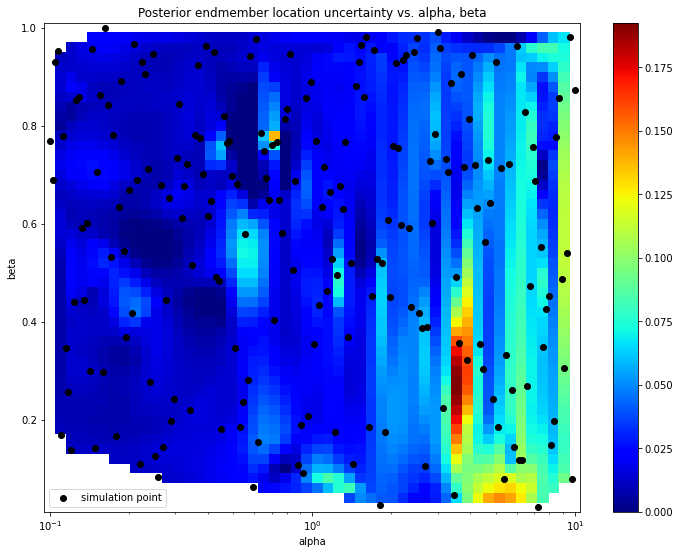

In [258]:
betas = np.array([elt['beta'] for elt in res])


x = alphas
y = betas
z = np.array([elt['rms_locs'] for elt in res])

X = np.logspace(np.log10(min(x)), np.log10(max(x)))
Y = np.linspace(min(y), max(y))
X, Y = np.meshgrid(X, Y)  # 2D grid for interpolation
interp = CloughTocher2DInterpolator(list(zip(x, y)), z)
#interp = NearestNDInterpolator(list(zip(x, y)), z)
Z = interp(X, Y)
plt.title("Posterior endmember location uncertainty vs. alpha, beta")
plt.pcolormesh(X, Y, Z, shading='auto', cmap = 'jet', vmin = 0)
plt.plot(x, y, "ok", label="simulation point")
plt.legend()
plt.colorbar()
#plt.axis("equal")
plt.xlabel('alpha')
plt.ylabel('beta')
plt.semilogx()
plt.show()

In [211]:
np.linalg.norm(res[0]['diff_locs'])

0.099819675

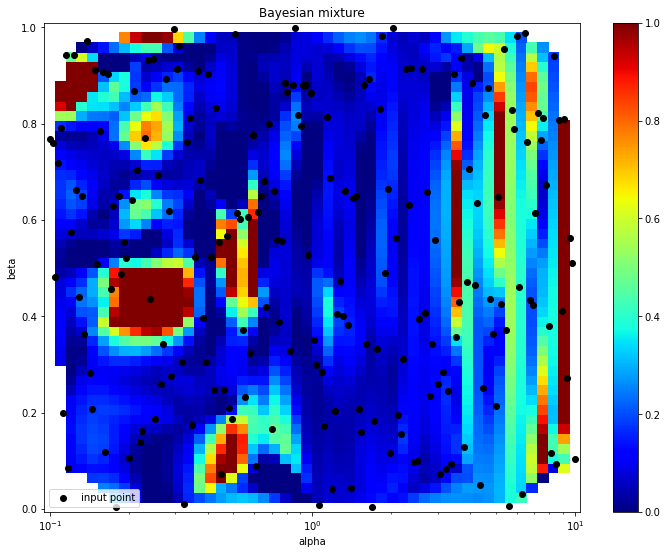

In [40]:
x = alphas
y = betas
z = np.array([np.linalg.norm(elt['diff_locs']) for elt in res])

X = np.logspace(np.log10(min(x)), np.log10(max(x)))
Y = np.linspace(min(y), max(y))
X, Y = np.meshgrid(X, Y)  # 2D grid for interpolation
interp = CloughTocher2DInterpolator(list(zip(x, y)), z)
#interp = NearestNDInterpolator(list(zip(x, y)), z)
Z = interp(X, Y)
plt.pcolormesh(X, Y, Z, shading='auto', cmap = 'jet', vmin = 0, vmax = 1)
plt.plot(x, y, "ok", label="input point")
plt.legend()
plt.colorbar()
#plt.axis("equal")
plt.xlabel('alpha')
plt.ylabel('beta')
plt.title('Bayesian mixture')
plt.semilogx()
plt.show()

In [469]:
# component_locs = np.array(posterior_samples["locs"][:, 0, :])

In [479]:
# loc_stds = np.sqrt((component_locs.std(axis = 0)**2).sum() / component_locs.shape[1])

In [231]:
posterior_samples.keys()

dict_keys(['L_omega', 'locs', 'phase_weights', 'scale', 'weights'])

In [12]:
from xrdc import misc

In [414]:
from importlib import reload
reload(misc)

with open('data/synthetic_simple.npy', 'rb') as f:
    patterns_pp = np.load(f)

In [415]:
with open('data/synthetic_mask.npy', 'rb') as f:
    mask = np.load(f)

In [416]:
with open('data/synthetic_simple_composition.npy', 'rb') as f:
    composition = np.load(f).reshape(patterns_pp.shape[:2] + (-1,))[mask]

In [417]:
composition.shape

(93, 3)

In [418]:
patterns_pp.shape

(15, 15, 43)

In [423]:
X = patterns_pp[mask]#.reshape(-1, 33)

#X += 100 * np.random.normal(size = X.shape)

#X = X / (np.std(X, axis = 0))
X = torch.from_numpy(X)

from sklearn.decomposition import PCA

pca = PCA(n_components=ndim, svd_solver = 'arpack')
Xpca = pca.fit_transform(X)

Xpca -= Xpca.mean(axis = 0)
Xpca /= Xpca.std(axis = 0)

In [385]:
# i = 0
# U,S,V = torch.linalg.svd(X, full_matrices = False)
# eigvecs=U.t()[:, i:ndim + i] #the first k vectors will be kept
# y=torch.mm(U,eigvecs)

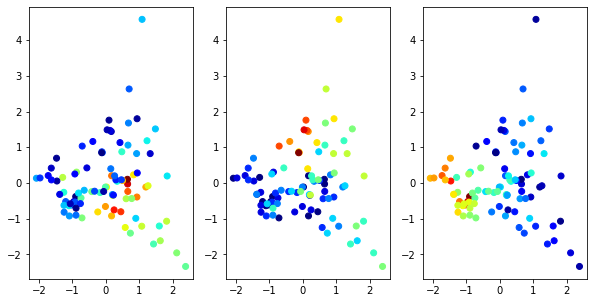

In [420]:
a, b = 1, 3

plt.subplot(a,b, 1)
plt.scatter(*(Xpca.T), c = composition[:, 0], cmap = 'jet')

plt.subplot(a,b, 2)
plt.scatter(*(Xpca.T), c = composition[:, 1], cmap = 'jet')

plt.subplot(a, b, 3)
plt.scatter(*(Xpca.T), c = composition[:, 2], cmap = 'jet')

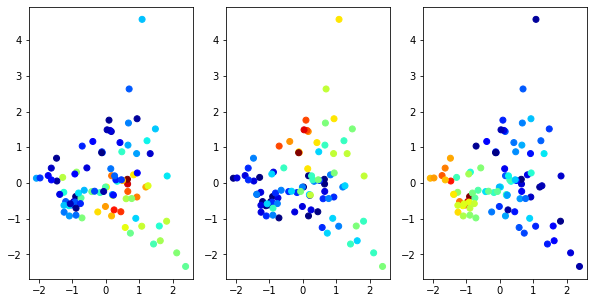

In [430]:
a, b = 1, 3

plt.subplot(a,b, 1)
plt.scatter(*(Xpca.T), c = composition[:, 0], cmap = 'jet')

plt.subplot(a,b, 2)
plt.scatter(*(Xpca.T), c = composition[:, 1], cmap = 'jet')

plt.subplot(a, b, 3)
plt.scatter(*(Xpca.T), c = composition[:, 2], cmap = 'jet')

In [424]:
Xpca = torch.from_numpy(Xpca.copy())
Xpca = Xpca.type(torch.float32)

In [437]:
alpha = 1
N = 93
num_samples = 50

def f(*args):
    return model(*args, scale = .2)

from pyro.infer.mcmc.api import MCMC
from pyro.infer.mcmc import NUTS
pyro.set_rng_seed(3)
kernel = NUTS(model)
mcmc = MCMC(kernel, num_samples=num_samples, warmup_steps=50)
mcmc.run(Xpca)
posterior_samples = mcmc.get_samples()

components = [posterior_samples["locs"][:, i, :] for i in range(T)]

Sample: 100%|██████████| 100/100 [01:55,  1.16s/it, step size=8.80e-03, acc. prob=0.908]


In [390]:
cimax, cjmax, ckmax = composition[:, 0].argmax(), composition[:, 1].argmax(), composition[:, 2].argmax()

In [393]:
composition[[cimax, cjmax, ckmax]], Xpca[[cimax, cjmax, ckmax]]

(array([[1.        , 0.        , 0.        ],
        [0.00512834, 0.98974332, 0.00512834],
        [0.        , 0.        , 1.        ]]),
 tensor([[2.0211, 0.5490],
         [0.0481, 0.5073],
         [2.0211, 0.5490]]))

tensor([0.3955, 0.3592, 0.2452])

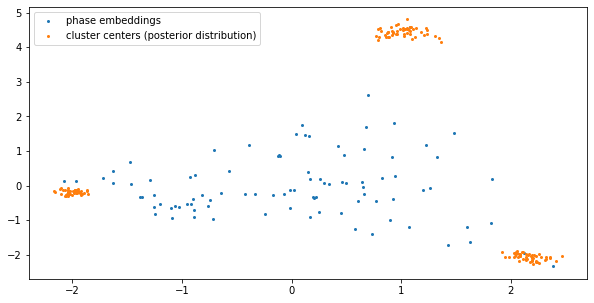

In [438]:
%matplotlib inline
mpl.rcParams['figure.figsize'] =(10,5)

plt.scatter(*(Xpca).T, s = 4, label = 'phase embeddings')
plt.scatter(*torch.vstack(components).T, s = 4, label = 'cluster centers (posterior distribution)')
plt.legend(loc = 'upper left')

#plt.scatter(*(Xpca[[cimax, cjmax, ckmax]].T), s = 50, label = 'end members (ground truth)')
posterior_samples["weights"].mean(axis = 0)

tensor([0.3934, 0.3600, 0.2466])

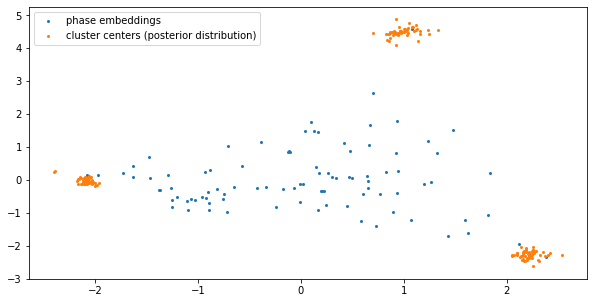

In [428]:
%matplotlib inline
mpl.rcParams['figure.figsize'] =(10,5)

plt.scatter(*(Xpca).T, s = 4, label = 'phase embeddings')
plt.scatter(*torch.vstack(components).T, s = 4, label = 'cluster centers (posterior distribution)')
plt.legend(loc = 'upper left')


#plt.scatter(*(Xpca[[cimax, cjmax, ckmax]].T), s = 50, label = 'end members (ground truth)')
posterior_samples["weights"].mean(axis = 0)

tensor([0.2710, 0.5233, 0.2057])

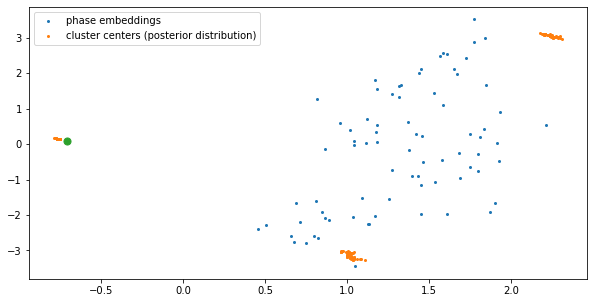

In [353]:
%matplotlib inline
mpl.rcParams['figure.figsize'] =(10,5)

plt.scatter(*(Xpca).T, s = 4, label = 'phase embeddings')
plt.scatter(*torch.vstack(components).T, s = 4, label = 'cluster centers (posterior distribution)')
plt.legend(loc = 'upper left')


plt.scatter(*(Xpca[[cjmax]].T), s = 50, label = 'end members (ground truth)')
posterior_samples["weights"].mean(axis = 0)

In [369]:
# ndim, T = 2, 3
# we, locs, data = gen_data(N, alpha = 1)
#.swapaxes(0, 1)[:, None, :].swapaxes(0, 2)
#data = np.array(data.swapaxes(0, 1))[:, None, :]

In [172]:
nfindr = eea.NFINDR()

In [343]:
nfindr.extract?

In [365]:
from importlib import reload
reload(eea)

<module 'pysptools.eea' from '/home/ollie/anaconda3/lib/python3.8/site-packages/pysptools/eea/__init__.py'>

In [24]:
nfindr_locs(res_noise[0]['data'])

array([[ 0.977432 ,  0.5220516],
       [ 1.2379189, -0.8646371],
       [-1.3682615, -1.4351814]], dtype=float32)

In [358]:
%pdb

Automatic pdb calling has been turned OFF


In [275]:
get_max(nfindr_locs, lambda inp: get_beta(*inp, norm=False), data)

0.15970203


array([[ 0.52427506, -0.31664747],
       [ 0.37536922, -1.2943693 ],
       [ 0.71849966, -0.11386427]], dtype=float32)

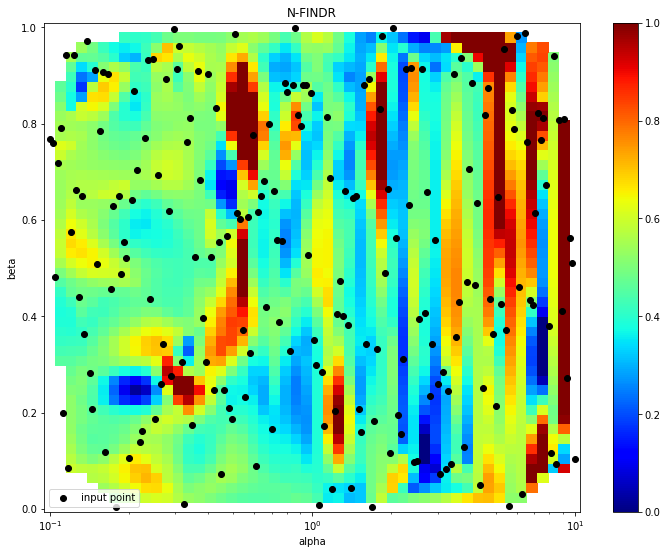

In [36]:
x = alphas
y = betas
z = np.array([np.linalg.norm(score_nfindr(elt)) for elt in res])

X = np.logspace(np.log10(min(x)), np.log10(max(x)))
Y = np.linspace(min(y), max(y))
X, Y = np.meshgrid(X, Y)  # 2D grid for interpolation
interp = CloughTocher2DInterpolator(list(zip(x, y)), z)
#interp = NearestNDInterpolator(list(zip(x, y)), z)
Z = interp(X, Y)


plt.pcolormesh(X, Y, Z, shading='auto', cmap = 'jet', vmin = 0, vmax = 1)
plt.plot(x, y, "ok", label="input point")
plt.legend()
plt.colorbar()
#plt.axis("equal")
plt.xlabel('alpha')
plt.ylabel('beta')
plt.title('N-FINDR')
plt.semilogx()
plt.show()

In [37]:
score_nfindr(res[0])

array([[-0.21623635, -0.31373537],
       [-0.13054466,  0.12960452],
       [ 0.23225927, -0.15612829]], dtype=float32)

In [434]:
closest_permutation_diffs(U, locs)

array([[-0.23506176, -0.21817684],
       [ 0.20596111, -1.4281216 ],
       [-0.21088588, -0.08614886]], dtype=float32)

In [16]:
# data = np.array(res_noise[0]['data']).copy()
# data = np.array(data)[:, None, :]
# nfindr = eea.NFINDR()
# U = nfindr.extract(data, T, maxit=1500, normalize=False, ATGP_init=True)

In [7]:
import dill

# Saved output of the following:
# alphas = np.logspace(-1, 1, 200)

# pyro.set_rng_seed(3)

# res = []
# for a in alphas:
#     res.append(run_instance(a, num_samples = 50, N = 500))

# with open('data/gmm_run_output.dill', 'wb') as f:
#     dill.dump(res, f)

with open('data/gmm_run_output.dill', 'rb') as f:
    res = dill.load(f)
    
alphas = np.array([elt['alpha'] for elt in res])
betas = np.array([elt['beta'] for elt in res])

In [174]:
mkdir data/figs

In [195]:
seed = 3

noises = np.linspace(.01, 3, 50)
noise_scale = 1

def ff(i):
    return plotnfindr(i, save = True, xlim = (-2, 2), ylim = (-2, 1))

res_noise = []
for nscale in noises:
    pyro.set_rng_seed(seed)
    we, locs, data = gen_data(N, alpha = 1, noise_scale= nscale)
    res_noise.append({'we': we, 'data': data, 'locs': locs, 'alpha': a, 'beta': get_beta(*locs)})
    
%matplotlib inline
vis.iplot(ff, res_noise)

interactive(children=(IntSlider(value=24, description='i', max=49), Output(layout=Layout(height='550px'))), _d…

In [170]:
len(noises)

50

In [25]:
pyro.set_rng_seed(3)

noise_scale = 1e-10

res_noise = []
for a in alphas:
    _, locs, data = gen_data(N, alpha = a, noise_scale= noise_scale)
    res_noise.append({'data': data, 'locs': locs, 'alpha': a, 'beta': get_beta(*locs)})
    
%matplotlib inline
vis.iplot(plotnfindr, res_noise)

interactive(children=(IntSlider(value=99, description='i', max=199), Output(layout=Layout(height='550px'))), _…

In [539]:
x = alphas
y = betas
z = np.array([np.linalg.norm(score_nfindr(elt)) for elt in res_noise])

X = np.logspace(np.log10(min(x)), np.log10(max(x)))
Y = np.linspace(min(y), max(y))
X, Y = np.meshgrid(X, Y)  # 2D grid for interpolation
interp = CloughTocher2DInterpolator(list(zip(x, y)), z)
#interp = NearestNDInterpolator(list(zip(x, y)), z)
Z = interp(X, Y)

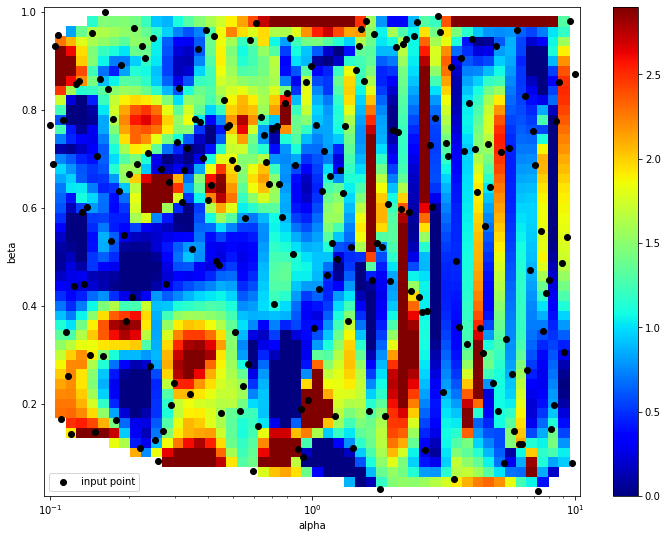

In [540]:
plt.pcolormesh(X, Y, Z, shading='auto', cmap = 'jet', vmin = 0, vmax = 2.9)
plt.plot(x, y, "ok", label="input point")
plt.legend()
plt.colorbar()
#plt.axis("equal")
plt.xlabel('alpha')
plt.ylabel('beta')
plt.semilogx()
plt.show()

In [216]:
U = get_max(nfindr_locs, lambda inp: get_beta(*inp), res_noise[0]['data'])
#nfindr_locs(res_noise[0]['data'])
U

0.9643750398018348


array([[ 0.10259872, -0.21195327],
       [ 1.0455846 ,  0.15879695],
       [ 1.1448426 , -0.7342544 ]], dtype=float32)

In [147]:
# data = res_noise[0]['data']
# data = np.array(data).copy().astype(float)#.swapaxes(0, 1)
# offsets = data.min(axis = 0)

# data = data - offsets

# initial_spectra = np.vstack([data.mean(axis = 0) for _ in range(T)]).astype(float)#np.array(Dirichlet(torch.ones(T)).sample([ndim]).T).astype(float)
# initial_spectra = initial_spectra + np.array([-.1, 0, .1])[:, None]
# assert initial_spectra.shape[1] == ndim

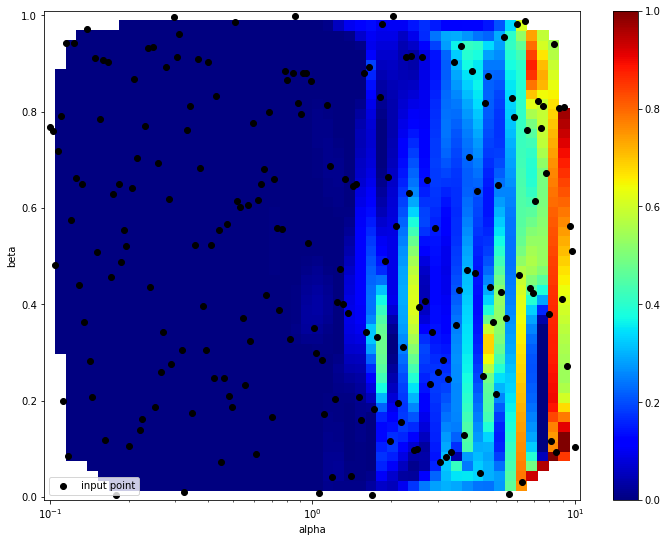

In [39]:
# generate
pyro.set_rng_seed(3)

noise_scale = 1e-10

res_noise = []
for a in alphas:
    _, locs, data = gen_data(N, alpha = a, noise_scale= noise_scale)
    res_noise.append({'data': data, 'locs': locs, 'alpha': a, 'beta': get_beta(*locs)})

# plot
alphas = np.array([elt['alpha'] for elt in res_noise])
betas = np.array([elt['beta'] for elt in res_noise])

x = alphas
y = betas


z = np.array([np.linalg.norm(score_nfindr(elt)) for elt in res_noise])
#z = np.array([np.linalg.norm(get_max(nfindr_locs, lambda inp: get_beta(*inp, norm=False), elt['data'])) for elt in res_noise])

X = np.logspace(np.log10(min(x)), np.log10(max(x)))
Y = np.linspace(min(y), max(y))
X, Y = np.meshgrid(X, Y)  # 2D grid for interpolation
interp = CloughTocher2DInterpolator(list(zip(x, y)), z)
#interp = NearestNDInterpolator(list(zip(x, y)), z)
Z = interp(X, Y)


plt.pcolormesh(X, Y, Z, shading='auto', cmap = 'jet', vmin = 0, vmax = 1)
plt.plot(x, y, "ok", label="input point")
plt.legend()
plt.colorbar()
#plt.axis("equal")
plt.xlabel('alpha')
plt.ylabel('beta')
plt.semilogx()
plt.show()

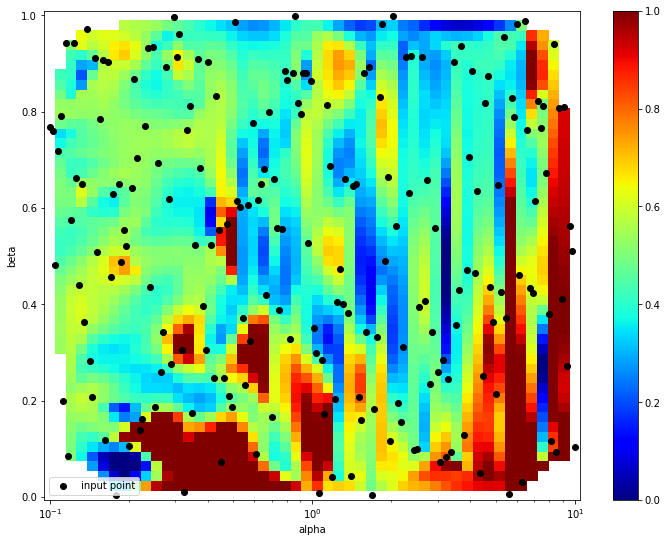

In [29]:
# generate
pyro.set_rng_seed(3)

noise_scale = 1

res_noise = []
for a in alphas:
    _, locs, data = gen_data(N, alpha = a, noise_scale= noise_scale)
    res_noise.append({'data': data, 'locs': locs, 'alpha': a, 'beta': get_beta(*locs)})

# plot
alphas = np.array([elt['alpha'] for elt in res_noise])
betas = np.array([elt['beta'] for elt in res_noise])

x = alphas
y = betas


z = np.array([np.linalg.norm(score_nfindr(elt)) for elt in res_noise])
#z = np.array([np.linalg.norm(get_max(nfindr_locs, lambda inp: get_beta(*inp, norm=False), elt['data'])) for elt in res_noise])

X = np.logspace(np.log10(min(x)), np.log10(max(x)))
Y = np.linspace(min(y), max(y))
X, Y = np.meshgrid(X, Y)  # 2D grid for interpolation
interp = CloughTocher2DInterpolator(list(zip(x, y)), z)
#interp = NearestNDInterpolator(list(zip(x, y)), z)
Z = interp(X, Y)


plt.pcolormesh(X, Y, Z, shading='auto', cmap = 'jet', vmin = 0, vmax = 1)
plt.plot(x, y, "ok", label="input point")
plt.legend()
plt.colorbar()
#plt.axis("equal")
plt.xlabel('alpha')
plt.ylabel('beta')
plt.semilogx()
plt.show()

In [ ]:
seed = 3

noise_scale = 1

alpha_progression = []
for a in alphas:
    pyro.set_rng_seed(seed)
    _, locs, data = gen_data(N, alpha = a, noise_scale= noise_scale)
    alpha_progression.append({'data': data, 'locs': locs, 'alpha': a, 'beta': get_beta(*locs)})

In [166]:
vis.iplot(ploti2, alpha_progression)

interactive(children=(IntSlider(value=99, description='i', max=199), Output(layout=Layout(height='550px'))), _…

## Scaling tests

In [596]:
bigd['data'].shape, bigd['components'][0].shape

(torch.Size([500, 9]), torch.Size([50, 9]))

In [599]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2, svd_solver = 'arpack')

def ploti4(res, i, save = False, xlim = None, ylim = None):
    data = res[i]['data']
    data_pca = pca.fit_transform(data)

    locs = pca.transform(res[i]['locs'])

    plt.scatter(*(data_pca).T, s = 1, label = 'observations')
    plt.scatter(*pca.transform(torch.vstack(res[i]['components'])).T, s = 2, label = 'end member locations (sampled)')
    
    plt.scatter(*(locs.T), s = 50, label = 'ground truth')
    
    post_loc_centroids = np.vstack([pca.transform(comp).mean(axis = 0) for comp in res[i]['components']])
    plt.scatter(*post_loc_centroids.T, c = 'k', s = 50, label = 'end member locations (centroids)')
    plt.scatter(*(pca.transform(nfindr_locs(data)).T), s = 50, label = 'N-FINDR')


    plt.legend()
    #plt.legend(loc = 'upper left')

    #plt.title('alpha = {:.2f}; beta = {:.2f}'.format(alphas[i], betas[i]))
    if xlim:
        plt.xlim(xlim)
    if ylim:
        plt.ylim(ylim)
    if save:
        plt.savefig('data/figs/{}.png'.format(i))

### T = 10

In [580]:
N = 1000
K = T = 10
ndim = T - 1

In [1246]:
pyro.set_rng_seed(9)
bigd_vi = run_instance_general(1, num_samples = 50, N = 500, noise_scale=.02, inference_posterior_fn=vi_inference)

TypeError: vi_posterior() missing 1 required positional argument: 'alpha'

> <ipython-input-983-38a744100cc4>(108)run_instance_general()
    106         we, locs, data = datadict['latents'], datadict['locs'], datadict['data']
    107 
--> 108     posterior_samples = inference_posterior_fn(data, num_samples, N)
    109 
    110     components = [posterior_samples["locs"][:, i, :] for i in range(T)]

ipdb> c


In [629]:
pyro.set_rng_seed(9)
bigd = run_instance_general(1, num_samples = 50, N = 500, noise_scale=.01, inference_posterior_fn=mcmc_posterior)

Sample: 100%|██████████| 100/100 [05:51,  3.52s/it, step size=1.13e-03, acc. prob=0.647]


In [604]:
losses = []

[]

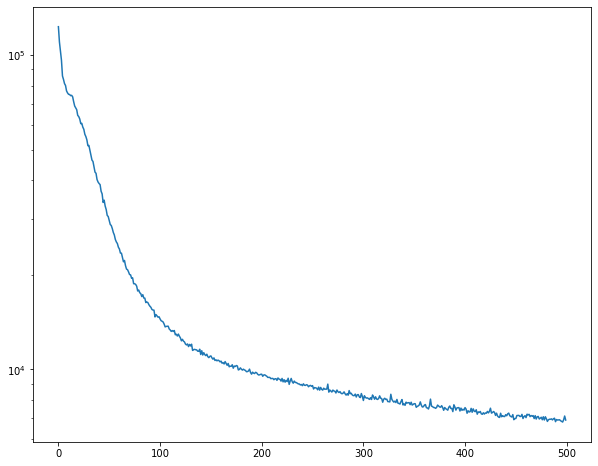

In [607]:
plt.plot(losses)
plt.semilogy()

In [565]:
%pdb

Automatic pdb calling has been turned ON


Text(0.5, 1.0, 'MCMC')

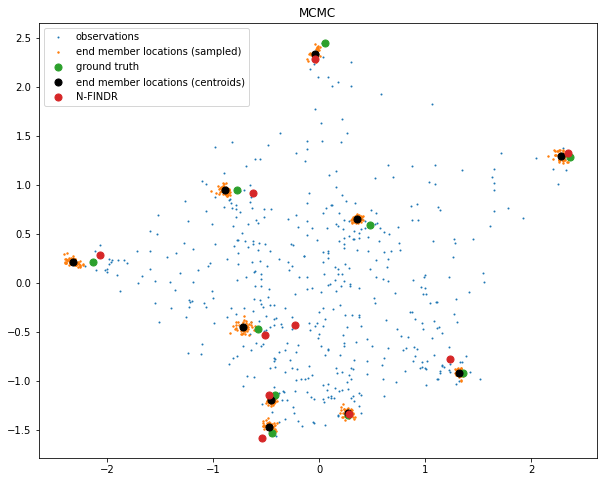

In [630]:
mpl.rcParams['figure.figsize'] =(10,8)

ploti4([bigd], 0, save = False, xlim = None, ylim = None)
plt.title('MCMC')

Text(0.5, 1.0, 'VI')

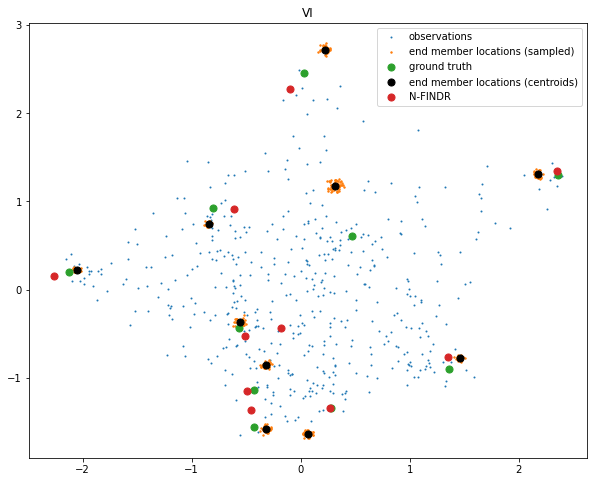

In [626]:
mpl.rcParams['figure.figsize'] =(10,8)

ploti4([bigd_vi], 0, save = False, xlim = None, ylim = None)
plt.title('VI')

In [628]:
bigd_vi.keys()

dict_keys(['data', 'locs', 'samples', 'rms_locs', 'diff_locs', 'alpha', 'components', 'latents', 'noise_scale'])

In [631]:
K = T = 5
ndim = T - 1

In [636]:
pyro.set_rng_seed(11)
bigd_vi2 = run_instance_general(1, num_samples = 50, N = 500, noise_scale=.02, inference_posterior_fn=vi_inference)


100%|██████████| 500/500 [00:03<00:00, 146.01it/s]


In [638]:
pyro.set_rng_seed(11)
bigd2 = run_instance_general(1, num_samples = 50, N = 500, noise_scale=.01, inference_posterior_fn=mcmc_posterior)

Sample: 100%|██████████| 100/100 [05:11,  3.12s/it, step size=1.73e-03, acc. prob=0.654]


### T = 5

Text(0.5, 1.0, 'MCMC')

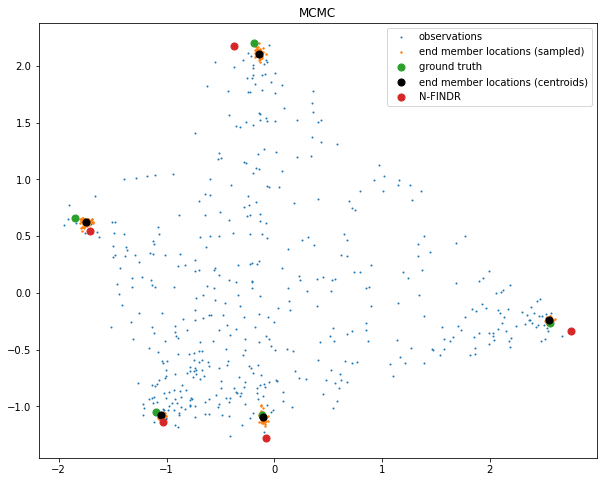

In [643]:
ploti4([bigd2], 0, save = False, xlim = None, ylim = None)
plt.title('MCMC')

Text(0.5, 1.0, 'VI')

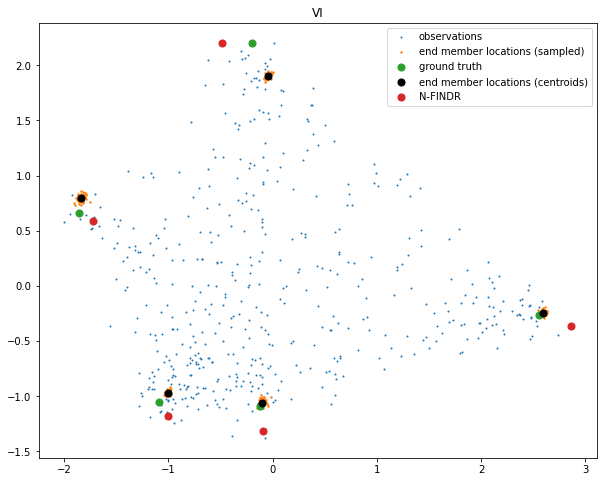

In [637]:
ploti4([bigd_vi2], 0, save = False, xlim = None, ylim = None)
plt.title('VI')